# **Overview**

**Challenge:** Helping an e-commerce business boost their revenue by customer and customer conversion rate.

**Goal:** Harness the power of ML and big data to create a e-commerce product recommender system.

**Data:** We utilized the Iowa Liquor Sales dataset from the Google Cloud Platform public database. There are no product ranking information so we utilized purchase history instead.

**Core ML tool:** Turicreate 

**Method:** Create 3 datasets (purchase volume, dummy and normalized purchase volume) and run them against 3 different ML models (popularity, collaborative filtering with cosine similarity and collaborative filtering with pearson similarity). This creates 9 different models where we will evaluate the RMSE and precision-recall and select the best. The best model is selected and we tuned it and observed if there are any improvements before making the final selection. 

**Output:**
1. Recommend 10 items based on matching similar users' preferences.
2. Recommend 10 items based on item selection.
3. Recommend 10 most popular items.

**Application:**
Each of the outputs are used as a different feature on our website.


---



# **First, housekeeping**

In [1]:
# Package installation
!pip install sklearn
!pip install turicreate

In [2]:
# Import dependencies

# For data manipulation and EDA
import numpy as np
import pandas as pd
import time

# For data visualisation
import matplotlib.pyplot as plt

# For splitting data into train and test sets
from sklearn.model_selection import train_test_split

# For machine learning modelling, model evaluation and selection
import turicreate as tc
import turicreate.aggregate as agg

# **Input Data**

In [3]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


We have queried the iowa liquor database from bigquery and inserted it into a database within our google project id. Query for reference below:

SELECT store_number, item_number, sum(volume_sold_liters) AS volume


FROM `bigquery-public-data.iowa_liquor_sales.sales`

WHERE data > date'2020-01-01' 

GROUP BY store_number, item_number

Query from own table stored in personal database

In [4]:
project_id = 'cosmic-antenna-281600'

from google.cloud import bigquery

client = bigquery.Client(project=project_id)

sample_count = 2000
df = client.query('''SELECT *
  FROM `cosmic-antenna-281600.iowa_2020.iowa_liquor_2020`''').to_dataframe()

print(df.shape)
df.head()

(446139, 3)


,store_number,item_number,volume
0,4829,27066,360.00
1,4311,43031,1.35
2,2627,43040,26.25
3,2500,27175,60.00
4,5054,5037,5.00


Import drive so we can save the model later

In [5]:
# Import drive first before exporting as csv file - !need to change to read from Git/BigQuery!
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Exploratory Data Analysis**

In [6]:
sf = tc.SFrame(df)
sf.plot()

Materializing SFrame

**Total number of records:** 446,139

**Number of unique users:** 1,841

**Number of unique items:** 3,846

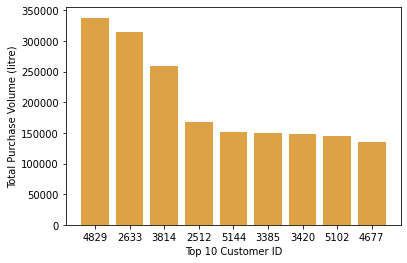

In [7]:
# Top customers by purchase volume
purchaser_by_vol = df.groupby('store_number').sum()
purchaser_by_vol = purchaser_by_vol.reset_index().sort_values(by='volume', ascending=False)

fig, ax = plt.subplots()
plt.bar(purchaser_by_vol.store_number[0:9], purchaser_by_vol.volume[0:9], color='#dda146')
plt.ylabel('Total Purchase Volume (litre)')
plt.xlabel('Top 10 Customer ID')
plt.show()

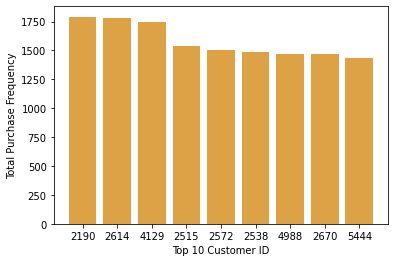

In [8]:
# Top customers by purchase frequency
purchaser_by_freq = df.groupby('store_number').count()
purchaser_by_freq = purchaser_by_freq.reset_index().sort_values(by='volume', ascending=False)
purchaser_by_freq = purchaser_by_freq[['store_number', 'volume']]

fig, ax = plt.subplots()
plt.bar(purchaser_by_freq.store_number[0:9], purchaser_by_freq.volume[0:9], color='#dda146')
plt.ylabel('Total Purchase Frequency')
plt.xlabel('Top 10 Customer ID')
plt.show()

item_number            inf
volume         4641.864119
dtype: float64


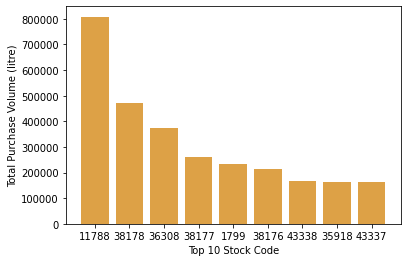

In [9]:
# Highest purchase volume items 
item_by_vol = df.groupby('item_number').sum()
item_by_vol = item_by_vol.reset_index().sort_values(by='volume', ascending=False)
print(item_by_vol.mean())

fig, ax = plt.subplots()
plt.bar(item_by_vol.item_number[0:9], item_by_vol.volume[0:9], color='#dda146')
plt.ylabel('Total Purchase Volume (litre)')
plt.xlabel('Top 10 Stock Code')
plt.show()

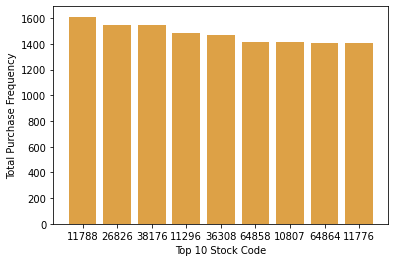

In [10]:
# Most commonly purchased items
item_by_freq = df.groupby('item_number').count()
item_by_freq = item_by_freq.reset_index().sort_values(by='volume', ascending=False)
item_by_freq = item_by_freq[['item_number', 'volume']]

fig, ax = plt.subplots()
plt.bar(item_by_freq.item_number[0:9], item_by_freq.volume[0:9], color='#dda146')
plt.ylabel('Total Purchase Frequency')
plt.xlabel('Top 10 Stock Code')
plt.show()

# **Data Preparation**

In [11]:
# Get rename data for product/customer matrix
df.rename(columns={'store_number': 'CustomerID', \
                   'item_number': 'StockCode', \
                   'volume': 'Quantity'}, inplace=True)
data = df
print(data.shape)
data.head()

(446139, 3)


,CustomerID,StockCode,Quantity
0,4829,27066,360.00
1,4311,43031,1.35
2,2627,43040,26.25
3,2500,27175,60.00
4,5054,5037,5.00


**Create Data with User, Product and Purchase Count**

In [12]:
# Group by to get purchase quantity by customer ID and stock code
data = data.groupby(['CustomerID','StockCode']) \
    .agg({'Quantity':'sum'}) \
    .reset_index().sort_values(by=['Quantity'], ascending=False)
print(data.shape)
data.head()

(446139, 3)


,CustomerID,StockCode,Quantity
160410,3814,936600,79852.5
255205,4677,936600,41580.0
160413,3814,962094,31185.0
387312,5666,936600,28350.0
267831,4829,38177,26280.0


In [13]:
# Check to ensure no negative purchase order quantity
data[data['Quantity']<0]

,CustomerID,StockCode,Quantity


In [14]:
# Check for null values
data.isnull().sum()

CustomerID    0
StockCode     0
Quantity      0
dtype: int64

In [15]:
# Check data types for current dataframe. CustomerID must be string
data.dtypes

CustomerID     object
StockCode      object
Quantity      float64
dtype: object

**Create Dummy Dataset**

A dummy set is created where by, we assign the value 1 where a user made a purchase. In the event where a user did not make a purchase, the value is 0.

Rationale for a dummy set is so we can have a dataset that is not impacted by purchase volume and/or frequency.

In [16]:
# Define function to create dummy dataset
def create_data_dummy(data):
    data_dummy = data.copy()
    dummy_matrix = pd.pivot_table(data_dummy, values='Quantity', index='CustomerID', columns='StockCode')
    dummy = dummy_matrix.reset_index()
    dummy.index.names = ['purchase_dummy']
    data_dummy = pd.melt(dummy, id_vars=['CustomerID'], value_name='purchase_dummy')
    # Replace any purchase value as 1
    data_dummy.loc[data_dummy['purchase_dummy'] > 0, 'purchase_dummy'] = 1
    # Replace any null value as 0
    data_dummy['purchase_dummy'].fillna(0, inplace=True)
    return data_dummy

In [17]:
# Execute function
data_dummy = create_data_dummy(data)
print(data_dummy.shape)
data_dummy.head()

(7080486, 3)


,CustomerID,StockCode,purchase_dummy
0,2106,100015,0.0
1,2113,100015,0.0
2,2130,100015,0.0
3,2178,100015,0.0
4,2190,100015,0.0


**Normalize Item Values Across Users**

Purchase volume is normalised for each product interaction by calculating an interaction score for each customer as follows:

interactionScore = (interactionScore-product.minScore)/(product.maxScore-product.minScore)

This follows the feature scaling method.

In [18]:
# Define function to normalize item values across users
def normalize_data(data):
    df_matrix = pd.pivot_table(data, values='Quantity', index='CustomerID', columns='StockCode')
    df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
    d = df_matrix_norm.reset_index()
    d.index.names = ['scaled_purchase_freq']
    return pd.melt(d, id_vars=['CustomerID'], value_name='scaled_purchase_freq').dropna()

In [19]:
# Execute function
norm_data = normalize_data(data)
print(norm_data.shape)
norm_data.head()

(443400, 3)


,CustomerID,StockCode,scaled_purchase_freq
18,2502,100015,0.482759
20,2506,100015,0.137931
27,2515,100015,0.482759
35,2528,100015,0.586207
39,2536,100015,0.482759


# **Split Train and Test Datasets**

We use SK learn to split our 3 datasets into train and test sets at a ratio of 80:20 

In [20]:
# Declare function to split train and test data
def split_data(data):
    '''
    Splits dataset into training and test set.
    
    Args:
        data (pandas.DataFrame)
        
    Returns
        train_data (tc.SFrame)
        test_data (tc.SFrame)
    '''
    train, test = train_test_split(data, test_size = .2)
    train_data = tc.SFrame(train)
    test_data = tc.SFrame(test)
    return train_data, test_data

In [21]:
# Split normalised scaled frequency data
train_data_norm, test_data_norm = split_data(norm_data)

In [22]:
# Split dummy data
train_data_dummy, test_data_dummy = split_data(data_dummy)

In [23]:
# Split purchase count data
train_data, test_data = split_data(data)

# **Define Models Using Turicreate Library**

Using Turicreate, we create 3 ML models for our datasets. 


1.   Popularity model
2.   Collaborative filtering with cosine similarity
3.   Collaborative filtering with pearson similarity



In [24]:
# Define variables for field names
user_id = 'CustomerID'
item_id = 'StockCode'
users_to_recommend = list(data['CustomerID'])
test_items = tc.SArray(sf['item_number'][10:12])
n_rec = 10 # number of items to recommend
n_display = 10 # to display the first few rows in an output dataset

In [25]:
# Declare function for all models
def model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display):
    if name == 'popularity':
        model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)
    elif name == 'cosine':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
    elif name == 'pearson':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='pearson')
        
    recom = model.recommend(users=users_to_recommend, k=n_rec)
    recom.print_rows(n_display)

    return model

# **Popularity Model**

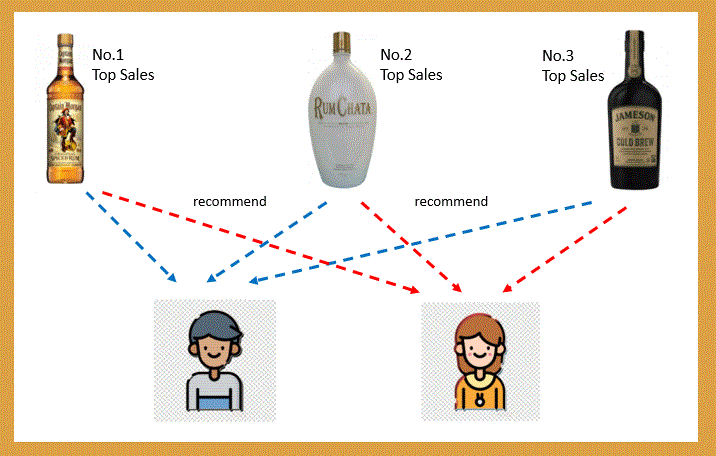

Popularity model recommends the most popular items across all users. This simple model will be used as a baseline comparison and also will be used as a feature on our website (Best selling items recommendation).

**Model based on Purchase Count**

In [26]:
# Using Purchase Count
name = 'popularity'
target = 'Quantity'
popularity = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 356911 observations with 1841 users and 3713 items.

Data prepared in: 0.536446s

356911 observations to process; with 3713 unique items.

recommendations finished on 1000/446139 queries. users per second: 15020.4

recommendations finished on 2000/446139 queries. users per second: 14747.8

recommendations finished on 3000/446139 queries. users per second: 14717

recommendations finished on 4000/446139 queries. users per second: 14823.7

recommendations finished on 5000/446139 queries. users per second: 15184.6

recommendations finished on 6000/446139 queries. users per second: 15046.2

recommendations finished on 7000/446139 queries. users per second: 15310.3

recommendations finished on 8000/446139 queries. users per second: 15445.8

recommendations finished on 9000/446139 queries. users per second: 15545.8

recommendations finished on 10000/446139 queries. users per second: 15676.5

recommendations finished on 11000/446139 queries. users per second: 15748.3

recommendations finished on 12000/446139 queries. users per second: 15817.2

recommendations finished on 13000/446139 queries. users per second: 15885

recommendations finished on 14000/446139 queries. users per second: 15813.4

recommendations finished on 15000/446139 queries. users per second: 15894.2

recommendations finished on 16000/446139 queries. users per second: 15910.6

recommendations finished on 17000/446139 queries. users per second: 15908.7

recommendations finished on 18000/446139 queries. users per second: 15945.6

recommendations finished on 19000/446139 queries. users per second: 15880.2

recommendations finished on 20000/446139 queries. users per second: 15788.8

recommendations finished on 21000/446139 queries. users per second: 15731

recommendations finished on 22000/446139 queries. users per second: 15754.4

recommendations finished on 23000/446139 queries. users per second: 15657.9

recommendations finished on 24000/446139 queries. users per second: 15501.3

recommendations finished on 25000/446139 queries. users per second: 15379.4

recommendations finished on 26000/446139 queries. users per second: 15176.6

recommendations finished on 27000/446139 queries. users per second: 15235

recommendations finished on 28000/446139 queries. users per second: 15241

recommendations finished on 29000/446139 queries. users per second: 15293.5

recommendations finished on 30000/446139 queries. users per second: 15295.4

recommendations finished on 31000/446139 queries. users per second: 15311.1

recommendations finished on 32000/446139 queries. users per second: 15376.3

recommendations finished on 33000/446139 queries. users per second: 15463.3

recommendations finished on 34000/446139 queries. users per second: 15461.6

recommendations finished on 35000/446139 queries. users per second: 15447.4

recommendations finished on 36000/446139 queries. users per second: 15482.3

recommendations finished on 37000/446139 queries. users per second: 15543.3

recommendations finished on 38000/446139 queries. users per second: 15540.5

recommendations finished on 39000/446139 queries. users per second: 15582.3

recommendations finished on 40000/446139 queries. users per second: 15616.3

recommendations finished on 41000/446139 queries. users per second: 15643.8

recommendations finished on 42000/446139 queries. users per second: 15697.4

recommendations finished on 43000/446139 queries. users per second: 15760.9

recommendations finished on 44000/446139 queries. users per second: 15747.2

recommendations finished on 45000/446139 queries. users per second: 15719.1

recommendations finished on 46000/446139 queries. users per second: 15727.5

recommendations finished on 47000/446139 queries. users per second: 15745.9

recommendations finished on 48000/446139 queries. users per second: 15748.4

recommendations finished on 49000/446139 queries. users per second: 15683

recommendations finished on 50000/446139 queries. users per second: 15716.7

recommendations finished on 51000/446139 queries. users per second: 15719.1

recommendations finished on 52000/446139 queries. users per second: 15733.1

recommendations finished on 53000/446139 queries. users per second: 15703.7

recommendations finished on 54000/446139 queries. users per second: 15679

recommendations finished on 55000/446139 queries. users per second: 15636

recommendations finished on 56000/446139 queries. users per second: 15549.8

recommendations finished on 57000/446139 queries. users per second: 15519.4

recommendations finished on 58000/446139 queries. users per second: 15482.7

recommendations finished on 59000/446139 queries. users per second: 15425.1

recommendations finished on 60000/446139 queries. users per second: 15349.6

recommendations finished on 61000/446139 queries. users per second: 15298.6

recommendations finished on 62000/446139 queries. users per second: 15225.9

recommendations finished on 63000/446139 queries. users per second: 15194.9

recommendations finished on 64000/446139 queries. users per second: 15151.7

recommendations finished on 65000/446139 queries. users per second: 15084.3

recommendations finished on 66000/446139 queries. users per second: 15034.5

recommendations finished on 67000/446139 queries. users per second: 14910.9

recommendations finished on 68000/446139 queries. users per second: 14845.4

recommendations finished on 69000/446139 queries. users per second: 14819.3

recommendations finished on 70000/446139 queries. users per second: 14791

recommendations finished on 71000/446139 queries. users per second: 14742.5

recommendations finished on 72000/446139 queries. users per second: 14715.9

recommendations finished on 73000/446139 queries. users per second: 14687.2

recommendations finished on 74000/446139 queries. users per second: 14628.8

recommendations finished on 75000/446139 queries. users per second: 14595.9

recommendations finished on 76000/446139 queries. users per second: 14568.1

recommendations finished on 77000/446139 queries. users per second: 14549.1

recommendations finished on 78000/446139 queries. users per second: 14523.7

recommendations finished on 79000/446139 queries. users per second: 14488.3

recommendations finished on 80000/446139 queries. users per second: 14440.1

recommendations finished on 81000/446139 queries. users per second: 14397.6

recommendations finished on 82000/446139 queries. users per second: 14384.6

recommendations finished on 83000/446139 queries. users per second: 14364.9

recommendations finished on 84000/446139 queries. users per second: 14342.9

recommendations finished on 85000/446139 queries. users per second: 14308.4

recommendations finished on 86000/446139 queries. users per second: 14288.1

recommendations finished on 87000/446139 queries. users per second: 14268.3

recommendations finished on 88000/446139 queries. users per second: 14230.8

recommendations finished on 89000/446139 queries. users per second: 14193.4

recommendations finished on 90000/446139 queries. users per second: 14173

recommendations finished on 91000/446139 queries. users per second: 14131.3

recommendations finished on 92000/446139 queries. users per second: 14090.1

recommendations finished on 93000/446139 queries. users per second: 14063.1

recommendations finished on 94000/446139 queries. users per second: 14044.6

recommendations finished on 95000/446139 queries. users per second: 14017.6

recommendations finished on 96000/446139 queries. users per second: 13998.8

recommendations finished on 97000/446139 queries. users per second: 13977.3

recommendations finished on 98000/446139 queries. users per second: 13974.1

recommendations finished on 99000/446139 queries. users per second: 13965.5

recommendations finished on 100000/446139 queries. users per second: 13938.6

recommendations finished on 101000/446139 queries. users per second: 13927.4

recommendations finished on 102000/446139 queries. users per second: 13901

recommendations finished on 103000/446139 queries. users per second: 13844.7

recommendations finished on 104000/446139 queries. users per second: 13827.4

recommendations finished on 105000/446139 queries. users per second: 13798.9

recommendations finished on 106000/446139 queries. users per second: 13768.8

recommendations finished on 107000/446139 queries. users per second: 13759.6

recommendations finished on 108000/446139 queries. users per second: 13744

recommendations finished on 109000/446139 queries. users per second: 13742.1

recommendations finished on 110000/446139 queries. users per second: 13749.6

recommendations finished on 111000/446139 queries. users per second: 13748.8

recommendations finished on 112000/446139 queries. users per second: 13740.1

recommendations finished on 113000/446139 queries. users per second: 13736.2

recommendations finished on 114000/446139 queries. users per second: 13740.1

recommendations finished on 115000/446139 queries. users per second: 13726.7

recommendations finished on 116000/446139 queries. users per second: 13730.5

recommendations finished on 117000/446139 queries. users per second: 13722.3

recommendations finished on 118000/446139 queries. users per second: 13681.5

recommendations finished on 119000/446139 queries. users per second: 13658.9

recommendations finished on 120000/446139 queries. users per second: 13648.7

recommendations finished on 121000/446139 queries. users per second: 13632.4

recommendations finished on 122000/446139 queries. users per second: 13593.6

recommendations finished on 123000/446139 queries. users per second: 13599.5

recommendations finished on 124000/446139 queries. users per second: 13589.3

recommendations finished on 125000/446139 queries. users per second: 13593.9

recommendations finished on 126000/446139 queries. users per second: 13599.2

recommendations finished on 127000/446139 queries. users per second: 13583.2

recommendations finished on 128000/446139 queries. users per second: 13573.1

recommendations finished on 129000/446139 queries. users per second: 13582

recommendations finished on 130000/446139 queries. users per second: 13579.3

recommendations finished on 131000/446139 queries. users per second: 13559.6

recommendations finished on 132000/446139 queries. users per second: 13557.6

recommendations finished on 133000/446139 queries. users per second: 13567.1

recommendations finished on 134000/446139 queries. users per second: 13562.8

recommendations finished on 135000/446139 queries. users per second: 13568.3

recommendations finished on 136000/446139 queries. users per second: 13561.5

recommendations finished on 137000/446139 queries. users per second: 13565.1

recommendations finished on 138000/446139 queries. users per second: 13562.2

recommendations finished on 139000/446139 queries. users per second: 13570.3

recommendations finished on 140000/446139 queries. users per second: 13584.3

recommendations finished on 141000/446139 queries. users per second: 13580.3

recommendations finished on 142000/446139 queries. users per second: 13581

recommendations finished on 143000/446139 queries. users per second: 13600.7

recommendations finished on 144000/446139 queries. users per second: 13618.3

recommendations finished on 145000/446139 queries. users per second: 13629

recommendations finished on 146000/446139 queries. users per second: 13639

recommendations finished on 147000/446139 queries. users per second: 13653.5

recommendations finished on 148000/446139 queries. users per second: 13662

recommendations finished on 149000/446139 queries. users per second: 13677.6

recommendations finished on 150000/446139 queries. users per second: 13695.5

recommendations finished on 151000/446139 queries. users per second: 13710.6

recommendations finished on 152000/446139 queries. users per second: 13729.1

recommendations finished on 153000/446139 queries. users per second: 13744.7

recommendations finished on 154000/446139 queries. users per second: 13761.2

recommendations finished on 155000/446139 queries. users per second: 13786.1

recommendations finished on 156000/446139 queries. users per second: 13756

recommendations finished on 157000/446139 queries. users per second: 13782.7

recommendations finished on 158000/446139 queries. users per second: 13803.4

recommendations finished on 159000/446139 queries. users per second: 13819.4

recommendations finished on 160000/446139 queries. users per second: 13837.4

recommendations finished on 161000/446139 queries. users per second: 13816.9

recommendations finished on 162000/446139 queries. users per second: 13824.5

recommendations finished on 163000/446139 queries. users per second: 13824.4

recommendations finished on 164000/446139 queries. users per second: 13814.2

recommendations finished on 165000/446139 queries. users per second: 13807

recommendations finished on 166000/446139 queries. users per second: 13792.3

recommendations finished on 167000/446139 queries. users per second: 13787.2

recommendations finished on 168000/446139 queries. users per second: 13784.8

recommendations finished on 169000/446139 queries. users per second: 13781.1

recommendations finished on 170000/446139 queries. users per second: 13782.3

recommendations finished on 171000/446139 queries. users per second: 13779.7

recommendations finished on 172000/446139 queries. users per second: 13779.6

recommendations finished on 173000/446139 queries. users per second: 13784.3

recommendations finished on 174000/446139 queries. users per second: 13791.6

recommendations finished on 175000/446139 queries. users per second: 13778.9

recommendations finished on 176000/446139 queries. users per second: 13783.8

recommendations finished on 177000/446139 queries. users per second: 13782.3

recommendations finished on 178000/446139 queries. users per second: 13782.6

recommendations finished on 179000/446139 queries. users per second: 13783

recommendations finished on 180000/446139 queries. users per second: 13789.7

recommendations finished on 181000/446139 queries. users per second: 13784.1

recommendations finished on 182000/446139 queries. users per second: 13753.9

recommendations finished on 183000/446139 queries. users per second: 13745.2

recommendations finished on 184000/446139 queries. users per second: 13743.2

recommendations finished on 185000/446139 queries. users per second: 13740.6

recommendations finished on 186000/446139 queries. users per second: 13735.2

recommendations finished on 187000/446139 queries. users per second: 13719.8

recommendations finished on 188000/446139 queries. users per second: 13678.5

recommendations finished on 189000/446139 queries. users per second: 13670.1

recommendations finished on 190000/446139 queries. users per second: 13667.5

recommendations finished on 191000/446139 queries. users per second: 13668.6

recommendations finished on 192000/446139 queries. users per second: 13678.5

recommendations finished on 193000/446139 queries. users per second: 13683.5

recommendations finished on 194000/446139 queries. users per second: 13693

recommendations finished on 195000/446139 queries. users per second: 13698

recommendations finished on 196000/446139 queries. users per second: 13698.5

recommendations finished on 197000/446139 queries. users per second: 13707

recommendations finished on 198000/446139 queries. users per second: 13713.2

recommendations finished on 199000/446139 queries. users per second: 13718.2

recommendations finished on 200000/446139 queries. users per second: 13722

recommendations finished on 201000/446139 queries. users per second: 13723.7

recommendations finished on 202000/446139 queries. users per second: 13719.9

recommendations finished on 203000/446139 queries. users per second: 13720.5

recommendations finished on 204000/446139 queries. users per second: 13719.9

recommendations finished on 205000/446139 queries. users per second: 13725.6

recommendations finished on 206000/446139 queries. users per second: 13728.7

recommendations finished on 207000/446139 queries. users per second: 13730.3

recommendations finished on 208000/446139 queries. users per second: 13737.5

recommendations finished on 209000/446139 queries. users per second: 13737.7

recommendations finished on 210000/446139 queries. users per second: 13745.5

recommendations finished on 211000/446139 queries. users per second: 13744.4

recommendations finished on 212000/446139 queries. users per second: 13743.3

recommendations finished on 213000/446139 queries. users per second: 13740.5

recommendations finished on 214000/446139 queries. users per second: 13738.6

recommendations finished on 215000/446139 queries. users per second: 13729.9

recommendations finished on 216000/446139 queries. users per second: 13720.7

recommendations finished on 217000/446139 queries. users per second: 13715.5

recommendations finished on 218000/446139 queries. users per second: 13712.7

recommendations finished on 219000/446139 queries. users per second: 13723.2

recommendations finished on 220000/446139 queries. users per second: 13736.1

recommendations finished on 221000/446139 queries. users per second: 13740.6

recommendations finished on 222000/446139 queries. users per second: 13741.7

recommendations finished on 223000/446139 queries. users per second: 13743.7

recommendations finished on 224000/446139 queries. users per second: 13747.3

recommendations finished on 225000/446139 queries. users per second: 13756.2

recommendations finished on 226000/446139 queries. users per second: 13757

recommendations finished on 227000/446139 queries. users per second: 13761.7

recommendations finished on 228000/446139 queries. users per second: 13766.8

recommendations finished on 229000/446139 queries. users per second: 13768.9

recommendations finished on 230000/446139 queries. users per second: 13769.6

recommendations finished on 231000/446139 queries. users per second: 13764.3

recommendations finished on 232000/446139 queries. users per second: 13775.8

recommendations finished on 233000/446139 queries. users per second: 13787.7

recommendations finished on 234000/446139 queries. users per second: 13789.4

recommendations finished on 235000/446139 queries. users per second: 13795.5

recommendations finished on 236000/446139 queries. users per second: 13791.4

recommendations finished on 237000/446139 queries. users per second: 13799.8

recommendations finished on 238000/446139 queries. users per second: 13806

recommendations finished on 239000/446139 queries. users per second: 13805.8

recommendations finished on 240000/446139 queries. users per second: 13810.2

recommendations finished on 241000/446139 queries. users per second: 13805.5

recommendations finished on 242000/446139 queries. users per second: 13805.6

recommendations finished on 243000/446139 queries. users per second: 13790.7

recommendations finished on 244000/446139 queries. users per second: 13791.1

recommendations finished on 245000/446139 queries. users per second: 13785.6

recommendations finished on 246000/446139 queries. users per second: 13770.7

recommendations finished on 247000/446139 queries. users per second: 13769.1

recommendations finished on 248000/446139 queries. users per second: 13763.3

recommendations finished on 249000/446139 queries. users per second: 13749.4

recommendations finished on 250000/446139 queries. users per second: 13744.3

recommendations finished on 251000/446139 queries. users per second: 13737.4

recommendations finished on 252000/446139 queries. users per second: 13732.2

recommendations finished on 253000/446139 queries. users per second: 13726.1

recommendations finished on 254000/446139 queries. users per second: 13719.9

recommendations finished on 255000/446139 queries. users per second: 13709.8

recommendations finished on 256000/446139 queries. users per second: 13707.6

recommendations finished on 257000/446139 queries. users per second: 13703.8

recommendations finished on 258000/446139 queries. users per second: 13689.2

recommendations finished on 259000/446139 queries. users per second: 13683.6

recommendations finished on 260000/446139 queries. users per second: 13681.1

recommendations finished on 261000/446139 queries. users per second: 13680.2

recommendations finished on 262000/446139 queries. users per second: 13671.2

recommendations finished on 263000/446139 queries. users per second: 13664.4

recommendations finished on 264000/446139 queries. users per second: 13662.6

recommendations finished on 265000/446139 queries. users per second: 13671.2

recommendations finished on 266000/446139 queries. users per second: 13673.2

recommendations finished on 267000/446139 queries. users per second: 13673.5

recommendations finished on 268000/446139 queries. users per second: 13681.4

recommendations finished on 269000/446139 queries. users per second: 13679

recommendations finished on 270000/446139 queries. users per second: 13681.9

recommendations finished on 271000/446139 queries. users per second: 13689.4

recommendations finished on 272000/446139 queries. users per second: 13687.2

recommendations finished on 273000/446139 queries. users per second: 13693.5

recommendations finished on 274000/446139 queries. users per second: 13699.5

recommendations finished on 275000/446139 queries. users per second: 13709.2

recommendations finished on 276000/446139 queries. users per second: 13714.8

recommendations finished on 277000/446139 queries. users per second: 13720.7

recommendations finished on 278000/446139 queries. users per second: 13725.1

recommendations finished on 279000/446139 queries. users per second: 13731.5

recommendations finished on 280000/446139 queries. users per second: 13736.7

recommendations finished on 281000/446139 queries. users per second: 13737.2

recommendations finished on 282000/446139 queries. users per second: 13742.1

recommendations finished on 283000/446139 queries. users per second: 13743.4

recommendations finished on 284000/446139 queries. users per second: 13738.5

recommendations finished on 285000/446139 queries. users per second: 13745.4

recommendations finished on 286000/446139 queries. users per second: 13748.2

recommendations finished on 287000/446139 queries. users per second: 13745.6

recommendations finished on 288000/446139 queries. users per second: 13742

recommendations finished on 289000/446139 queries. users per second: 13738.8

recommendations finished on 290000/446139 queries. users per second: 13740.6

recommendations finished on 291000/446139 queries. users per second: 13744.4

recommendations finished on 292000/446139 queries. users per second: 13741.6

recommendations finished on 293000/446139 queries. users per second: 13740.7

recommendations finished on 294000/446139 queries. users per second: 13741.9

recommendations finished on 295000/446139 queries. users per second: 13740.3

recommendations finished on 296000/446139 queries. users per second: 13738.7

recommendations finished on 297000/446139 queries. users per second: 13720.2

recommendations finished on 298000/446139 queries. users per second: 13713.2

recommendations finished on 299000/446139 queries. users per second: 13697

recommendations finished on 300000/446139 queries. users per second: 13680.7

recommendations finished on 301000/446139 queries. users per second: 13669.3

recommendations finished on 302000/446139 queries. users per second: 13654.7

recommendations finished on 303000/446139 queries. users per second: 13647.7

recommendations finished on 304000/446139 queries. users per second: 13643.9

recommendations finished on 305000/446139 queries. users per second: 13642.4

recommendations finished on 306000/446139 queries. users per second: 13643.2

recommendations finished on 307000/446139 queries. users per second: 13639.3

recommendations finished on 308000/446139 queries. users per second: 13637.3

recommendations finished on 309000/446139 queries. users per second: 13634.2

recommendations finished on 310000/446139 queries. users per second: 13628.6

recommendations finished on 311000/446139 queries. users per second: 13622.6

recommendations finished on 312000/446139 queries. users per second: 13622.6

recommendations finished on 313000/446139 queries. users per second: 13602.5

recommendations finished on 314000/446139 queries. users per second: 13597.3

recommendations finished on 315000/446139 queries. users per second: 13590.1

recommendations finished on 316000/446139 queries. users per second: 13580.4

recommendations finished on 317000/446139 queries. users per second: 13570.1

recommendations finished on 318000/446139 queries. users per second: 13562

recommendations finished on 319000/446139 queries. users per second: 13560.2

recommendations finished on 320000/446139 queries. users per second: 13557.2

recommendations finished on 321000/446139 queries. users per second: 13552

recommendations finished on 322000/446139 queries. users per second: 13546.9

recommendations finished on 323000/446139 queries. users per second: 13548.2

recommendations finished on 324000/446139 queries. users per second: 13550

recommendations finished on 325000/446139 queries. users per second: 13542.4

recommendations finished on 326000/446139 queries. users per second: 13541.9

recommendations finished on 327000/446139 queries. users per second: 13536.1

recommendations finished on 328000/446139 queries. users per second: 13533.4

recommendations finished on 329000/446139 queries. users per second: 13532.8

recommendations finished on 330000/446139 queries. users per second: 13536.9

recommendations finished on 331000/446139 queries. users per second: 13540

recommendations finished on 332000/446139 queries. users per second: 13543.8

recommendations finished on 333000/446139 queries. users per second: 13538.4

recommendations finished on 334000/446139 queries. users per second: 13541.2

recommendations finished on 335000/446139 queries. users per second: 13551.3

recommendations finished on 336000/446139 queries. users per second: 13556.6

recommendations finished on 337000/446139 queries. users per second: 13558.1

recommendations finished on 338000/446139 queries. users per second: 13558.3

recommendations finished on 339000/446139 queries. users per second: 13549.9

recommendations finished on 340000/446139 queries. users per second: 13553.9

recommendations finished on 341000/446139 queries. users per second: 13557.7

recommendations finished on 342000/446139 queries. users per second: 13564.2

recommendations finished on 343000/446139 queries. users per second: 13561.3

recommendations finished on 344000/446139 queries. users per second: 13562.7

recommendations finished on 345000/446139 queries. users per second: 13567.8

recommendations finished on 346000/446139 queries. users per second: 13571.8

recommendations finished on 347000/446139 queries. users per second: 13573.6

recommendations finished on 348000/446139 queries. users per second: 13575

recommendations finished on 349000/446139 queries. users per second: 13580.3

recommendations finished on 350000/446139 queries. users per second: 13586.8

recommendations finished on 351000/446139 queries. users per second: 13583

recommendations finished on 352000/446139 queries. users per second: 13588.4

recommendations finished on 353000/446139 queries. users per second: 13592.7

recommendations finished on 354000/446139 queries. users per second: 13594.2

recommendations finished on 355000/446139 queries. users per second: 13601.1

recommendations finished on 356000/446139 queries. users per second: 13607.5

recommendations finished on 357000/446139 queries. users per second: 13612.8

recommendations finished on 358000/446139 queries. users per second: 13615.8

recommendations finished on 359000/446139 queries. users per second: 13619.1

recommendations finished on 360000/446139 queries. users per second: 13622.4

recommendations finished on 361000/446139 queries. users per second: 13627.9

recommendations finished on 362000/446139 queries. users per second: 13627.1

recommendations finished on 363000/446139 queries. users per second: 13627.1

recommendations finished on 364000/446139 queries. users per second: 13631.3

recommendations finished on 365000/446139 queries. users per second: 13634.3

recommendations finished on 366000/446139 queries. users per second: 13629.2

recommendations finished on 367000/446139 queries. users per second: 13619.4

recommendations finished on 368000/446139 queries. users per second: 13607.2

recommendations finished on 369000/446139 queries. users per second: 13597.8

recommendations finished on 370000/446139 queries. users per second: 13587.2

recommendations finished on 371000/446139 queries. users per second: 13582.6

recommendations finished on 372000/446139 queries. users per second: 13579.5

recommendations finished on 373000/446139 queries. users per second: 13570.3

recommendations finished on 374000/446139 queries. users per second: 13565.2

recommendations finished on 375000/446139 queries. users per second: 13557.5

recommendations finished on 376000/446139 queries. users per second: 13553.7

recommendations finished on 377000/446139 queries. users per second: 13546.4

recommendations finished on 378000/446139 queries. users per second: 13539.8

recommendations finished on 379000/446139 queries. users per second: 13535.1

recommendations finished on 380000/446139 queries. users per second: 13526.5

recommendations finished on 381000/446139 queries. users per second: 13521.7

recommendations finished on 382000/446139 queries. users per second: 13517.1

recommendations finished on 383000/446139 queries. users per second: 13514

recommendations finished on 384000/446139 queries. users per second: 13508.2

recommendations finished on 385000/446139 queries. users per second: 13503.7

recommendations finished on 386000/446139 queries. users per second: 13499.1

recommendations finished on 387000/446139 queries. users per second: 13493.7

recommendations finished on 388000/446139 queries. users per second: 13482.6

recommendations finished on 389000/446139 queries. users per second: 13478.5

recommendations finished on 390000/446139 queries. users per second: 13475.5

recommendations finished on 391000/446139 queries. users per second: 13473.4

recommendations finished on 392000/446139 queries. users per second: 13467.8

recommendations finished on 393000/446139 queries. users per second: 13465

recommendations finished on 394000/446139 queries. users per second: 13464.9

recommendations finished on 395000/446139 queries. users per second: 13466.4

recommendations finished on 396000/446139 queries. users per second: 13469

recommendations finished on 397000/446139 queries. users per second: 13466

recommendations finished on 398000/446139 queries. users per second: 13466.9

recommendations finished on 399000/446139 queries. users per second: 13465.9

recommendations finished on 400000/446139 queries. users per second: 13467.3

recommendations finished on 401000/446139 queries. users per second: 13468.2

recommendations finished on 402000/446139 queries. users per second: 13459.6

recommendations finished on 403000/446139 queries. users per second: 13457.5

recommendations finished on 404000/446139 queries. users per second: 13447.6

recommendations finished on 405000/446139 queries. users per second: 13443.3

recommendations finished on 406000/446139 queries. users per second: 13443.4

recommendations finished on 407000/446139 queries. users per second: 13445.8

recommendations finished on 408000/446139 queries. users per second: 13444.5

recommendations finished on 409000/446139 queries. users per second: 13444.3

recommendations finished on 410000/446139 queries. users per second: 13446.8

recommendations finished on 411000/446139 queries. users per second: 13446.4

recommendations finished on 412000/446139 queries. users per second: 13447.9

recommendations finished on 413000/446139 queries. users per second: 13445.9

recommendations finished on 414000/446139 queries. users per second: 13442.2

recommendations finished on 415000/446139 queries. users per second: 13439

recommendations finished on 416000/446139 queries. users per second: 13433.8

recommendations finished on 417000/446139 queries. users per second: 13427.5

recommendations finished on 418000/446139 queries. users per second: 13412.8

recommendations finished on 419000/446139 queries. users per second: 13410.2

recommendations finished on 420000/446139 queries. users per second: 13404.9

recommendations finished on 421000/446139 queries. users per second: 13400.2

recommendations finished on 422000/446139 queries. users per second: 13385.8

recommendations finished on 423000/446139 queries. users per second: 13389.3

recommendations finished on 424000/446139 queries. users per second: 13392.6

recommendations finished on 425000/446139 queries. users per second: 13395.5

recommendations finished on 426000/446139 queries. users per second: 13401.1

recommendations finished on 427000/446139 queries. users per second: 13405.4

recommendations finished on 428000/446139 queries. users per second: 13410.8

recommendations finished on 429000/446139 queries. users per second: 13416.9

recommendations finished on 430000/446139 queries. users per second: 13409.7

recommendations finished on 431000/446139 queries. users per second: 13408.7

recommendations finished on 432000/446139 queries. users per second: 13407.1

recommendations finished on 433000/446139 queries. users per second: 13395.8

recommendations finished on 434000/446139 queries. users per second: 13397.1

recommendations finished on 435000/446139 queries. users per second: 13392.5

recommendations finished on 436000/446139 queries. users per second: 13377.8

recommendations finished on 437000/446139 queries. users per second: 13371.6

recommendations finished on 438000/446139 queries. users per second: 13364.5

recommendations finished on 439000/446139 queries. users per second: 13360.9

recommendations finished on 440000/446139 queries. users per second: 13352.3

recommendations finished on 441000/446139 queries. users per second: 13350.4

recommendations finished on 442000/446139 queries. users per second: 13356.4

recommendations finished on 443000/446139 queries. users per second: 13366.2

recommendations finished on 444000/446139 queries. users per second: 13370.4

recommendations finished on 445000/446139 queries. users per second: 13375.3

recommendations finished on 446000/446139 queries. users per second: 13376.9

+------------+-----------+--------------------+------+
| CustomerID | StockCode |       score        | rank |
+------------+-----------+--------------------+------+
|    3814    |   962094  |      16537.5       |  1   |
|    3814    |   936859  |      10449.6       |  2   |
|    3814    |   989289  |       5880.0       |  3   |
|    3814    |   944650  |       5040.0       |  4   |
|    3814    |   962476  |       3402.0       |  5   |
|    3814    |   946574  |       2576.0       |  6   |
|    3814    |   988063  |       1848.0       |  7   |
|    3814    |   77487   | 1439.0566037735848 |  8   |
|    3814    |   75087   | 1390.3142857142857 |  9   |
|    3814    |   926875  |       1134.0       |  10  |
+------------+-----------+--------------------+------+
[4461390 rows x 4 columns]



**Model based on Purchase Dummy**

In [27]:
# Using purchase dummy
name = 'popularity'
target = 'purchase_dummy'
pop_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 5664388 observations with 1841 users and 3846 items.

Data prepared in: 8.29934s

5664388 observations to process; with 3846 unique items.

recommendations finished on 1000/446139 queries. users per second: 4313.15

recommendations finished on 2000/446139 queries. users per second: 3804.16

recommendations finished on 3000/446139 queries. users per second: 3858.77

recommendations finished on 4000/446139 queries. users per second: 3808.95

recommendations finished on 5000/446139 queries. users per second: 3860.89

recommendations finished on 6000/446139 queries. users per second: 3847.88

recommendations finished on 7000/446139 queries. users per second: 4002.88

recommendations finished on 8000/446139 queries. users per second: 4070.96

recommendations finished on 9000/446139 queries. users per second: 4061.83

recommendations finished on 10000/446139 queries. users per second: 4150.82

recommendations finished on 11000/446139 queries. users per second: 4154.29

recommendations finished on 12000/446139 queries. users per second: 4224.56

recommendations finished on 13000/446139 queries. users per second: 4270.76

recommendations finished on 14000/446139 queries. users per second: 4276.87

recommendations finished on 15000/446139 queries. users per second: 4311.16

recommendations finished on 16000/446139 queries. users per second: 4309.58

recommendations finished on 17000/446139 queries. users per second: 4280.82

recommendations finished on 18000/446139 queries. users per second: 4303.01

recommendations finished on 19000/446139 queries. users per second: 4323.08

recommendations finished on 20000/446139 queries. users per second: 4354.69

recommendations finished on 21000/446139 queries. users per second: 4376.2

recommendations finished on 22000/446139 queries. users per second: 4388.61

recommendations finished on 23000/446139 queries. users per second: 4382.14

recommendations finished on 24000/446139 queries. users per second: 4375.26

recommendations finished on 25000/446139 queries. users per second: 4345.14

recommendations finished on 26000/446139 queries. users per second: 4351.11

recommendations finished on 27000/446139 queries. users per second: 4406.56

recommendations finished on 28000/446139 queries. users per second: 4459.75

recommendations finished on 29000/446139 queries. users per second: 4492.87

recommendations finished on 30000/446139 queries. users per second: 4510.38

recommendations finished on 31000/446139 queries. users per second: 4516.52

recommendations finished on 32000/446139 queries. users per second: 4508.21

recommendations finished on 33000/446139 queries. users per second: 4553.54

recommendations finished on 34000/446139 queries. users per second: 4606.21

recommendations finished on 35000/446139 queries. users per second: 4648.44

recommendations finished on 36000/446139 queries. users per second: 4650.25

recommendations finished on 37000/446139 queries. users per second: 4681.73

recommendations finished on 38000/446139 queries. users per second: 4715.52

recommendations finished on 39000/446139 queries. users per second: 4737.3

recommendations finished on 40000/446139 queries. users per second: 4763.31

recommendations finished on 41000/446139 queries. users per second: 4776.14

recommendations finished on 42000/446139 queries. users per second: 4778.83

recommendations finished on 43000/446139 queries. users per second: 4791.26

recommendations finished on 44000/446139 queries. users per second: 4759.73

recommendations finished on 45000/446139 queries. users per second: 4757.39

recommendations finished on 46000/446139 queries. users per second: 4719.01

recommendations finished on 47000/446139 queries. users per second: 4689.09

recommendations finished on 48000/446139 queries. users per second: 4671.65

recommendations finished on 49000/446139 queries. users per second: 4655.43

recommendations finished on 50000/446139 queries. users per second: 4631.24

recommendations finished on 51000/446139 queries. users per second: 4599.39

recommendations finished on 52000/446139 queries. users per second: 4540.65

recommendations finished on 53000/446139 queries. users per second: 4492.48

recommendations finished on 54000/446139 queries. users per second: 4438.76

recommendations finished on 55000/446139 queries. users per second: 4402.55

recommendations finished on 56000/446139 queries. users per second: 4361.92

recommendations finished on 57000/446139 queries. users per second: 4321.67

recommendations finished on 58000/446139 queries. users per second: 4282.12

recommendations finished on 59000/446139 queries. users per second: 4235.64

recommendations finished on 60000/446139 queries. users per second: 4200.39

recommendations finished on 61000/446139 queries. users per second: 4167.41

recommendations finished on 62000/446139 queries. users per second: 4137.76

recommendations finished on 63000/446139 queries. users per second: 4110.05

recommendations finished on 64000/446139 queries. users per second: 4086.33

recommendations finished on 65000/446139 queries. users per second: 4061.27

recommendations finished on 66000/446139 queries. users per second: 4040.08

recommendations finished on 67000/446139 queries. users per second: 4014.46

recommendations finished on 68000/446139 queries. users per second: 3983.23

recommendations finished on 69000/446139 queries. users per second: 3962.95

recommendations finished on 70000/446139 queries. users per second: 3944.09

recommendations finished on 71000/446139 queries. users per second: 3918.46

recommendations finished on 72000/446139 queries. users per second: 3897.93

recommendations finished on 73000/446139 queries. users per second: 3879.26

recommendations finished on 74000/446139 queries. users per second: 3859.14

recommendations finished on 75000/446139 queries. users per second: 3843.22

recommendations finished on 76000/446139 queries. users per second: 3826.39

recommendations finished on 77000/446139 queries. users per second: 3807.17

recommendations finished on 78000/446139 queries. users per second: 3791.19

recommendations finished on 79000/446139 queries. users per second: 3775.21

recommendations finished on 80000/446139 queries. users per second: 3759.89

recommendations finished on 81000/446139 queries. users per second: 3744.47

recommendations finished on 82000/446139 queries. users per second: 3724.29

recommendations finished on 83000/446139 queries. users per second: 3707.11

recommendations finished on 84000/446139 queries. users per second: 3694

recommendations finished on 85000/446139 queries. users per second: 3682.56

recommendations finished on 86000/446139 queries. users per second: 3669.87

recommendations finished on 87000/446139 queries. users per second: 3658.55

recommendations finished on 88000/446139 queries. users per second: 3648.7

recommendations finished on 89000/446139 queries. users per second: 3638.09

recommendations finished on 90000/446139 queries. users per second: 3629.24

recommendations finished on 91000/446139 queries. users per second: 3620.22

recommendations finished on 92000/446139 queries. users per second: 3609.41

recommendations finished on 93000/446139 queries. users per second: 3599.75

recommendations finished on 94000/446139 queries. users per second: 3586.43

recommendations finished on 95000/446139 queries. users per second: 3574.09

recommendations finished on 96000/446139 queries. users per second: 3563.38

recommendations finished on 97000/446139 queries. users per second: 3555.09

recommendations finished on 98000/446139 queries. users per second: 3551.92

recommendations finished on 99000/446139 queries. users per second: 3544.76

recommendations finished on 100000/446139 queries. users per second: 3537.95

recommendations finished on 101000/446139 queries. users per second: 3530.11

recommendations finished on 102000/446139 queries. users per second: 3526.17

recommendations finished on 103000/446139 queries. users per second: 3522.5

recommendations finished on 104000/446139 queries. users per second: 3519.44

recommendations finished on 105000/446139 queries. users per second: 3515.8

recommendations finished on 106000/446139 queries. users per second: 3510.09

recommendations finished on 107000/446139 queries. users per second: 3500.55

recommendations finished on 108000/446139 queries. users per second: 3491.44

recommendations finished on 109000/446139 queries. users per second: 3483.01

recommendations finished on 110000/446139 queries. users per second: 3475.44

recommendations finished on 111000/446139 queries. users per second: 3471.43

recommendations finished on 112000/446139 queries. users per second: 3463.78

recommendations finished on 113000/446139 queries. users per second: 3459.87

recommendations finished on 114000/446139 queries. users per second: 3451.48

recommendations finished on 115000/446139 queries. users per second: 3446.11

recommendations finished on 116000/446139 queries. users per second: 3442.49

recommendations finished on 117000/446139 queries. users per second: 3440.45

recommendations finished on 118000/446139 queries. users per second: 3441.86

recommendations finished on 119000/446139 queries. users per second: 3441.92

recommendations finished on 120000/446139 queries. users per second: 3441.59

recommendations finished on 121000/446139 queries. users per second: 3439.91

recommendations finished on 122000/446139 queries. users per second: 3437.75

recommendations finished on 123000/446139 queries. users per second: 3439.51

recommendations finished on 124000/446139 queries. users per second: 3440.19

recommendations finished on 125000/446139 queries. users per second: 3439.8

recommendations finished on 126000/446139 queries. users per second: 3438.71

recommendations finished on 127000/446139 queries. users per second: 3439

recommendations finished on 128000/446139 queries. users per second: 3438.9

recommendations finished on 129000/446139 queries. users per second: 3437.34

recommendations finished on 130000/446139 queries. users per second: 3446.96

recommendations finished on 131000/446139 queries. users per second: 3458.98

recommendations finished on 132000/446139 queries. users per second: 3470.78

recommendations finished on 133000/446139 queries. users per second: 3480.88

recommendations finished on 134000/446139 queries. users per second: 3492.3

recommendations finished on 135000/446139 queries. users per second: 3499.46

recommendations finished on 136000/446139 queries. users per second: 3504.94

recommendations finished on 137000/446139 queries. users per second: 3512.02

recommendations finished on 138000/446139 queries. users per second: 3523.13

recommendations finished on 139000/446139 queries. users per second: 3532.65

recommendations finished on 140000/446139 queries. users per second: 3542.94

recommendations finished on 141000/446139 queries. users per second: 3553.86

recommendations finished on 142000/446139 queries. users per second: 3571.11

recommendations finished on 143000/446139 queries. users per second: 3579.89

recommendations finished on 144000/446139 queries. users per second: 3591.65

recommendations finished on 145000/446139 queries. users per second: 3603.85

recommendations finished on 146000/446139 queries. users per second: 3614.42

recommendations finished on 147000/446139 queries. users per second: 3620.39

recommendations finished on 148000/446139 queries. users per second: 3632.82

recommendations finished on 149000/446139 queries. users per second: 3636.24

recommendations finished on 150000/446139 queries. users per second: 3637.36

recommendations finished on 151000/446139 queries. users per second: 3633.01

recommendations finished on 152000/446139 queries. users per second: 3625.65

recommendations finished on 153000/446139 queries. users per second: 3618.01

recommendations finished on 154000/446139 queries. users per second: 3611.59

recommendations finished on 155000/446139 queries. users per second: 3606.48

recommendations finished on 156000/446139 queries. users per second: 3601.05

recommendations finished on 157000/446139 queries. users per second: 3598.8

recommendations finished on 158000/446139 queries. users per second: 3598.62

recommendations finished on 159000/446139 queries. users per second: 3599.35

recommendations finished on 160000/446139 queries. users per second: 3598.08

recommendations finished on 161000/446139 queries. users per second: 3596.87

recommendations finished on 162000/446139 queries. users per second: 3596.94

recommendations finished on 163000/446139 queries. users per second: 3597.45

recommendations finished on 164000/446139 queries. users per second: 3598.29

recommendations finished on 165000/446139 queries. users per second: 3597.63

recommendations finished on 166000/446139 queries. users per second: 3595.11

recommendations finished on 167000/446139 queries. users per second: 3588.59

recommendations finished on 168000/446139 queries. users per second: 3583.18

recommendations finished on 169000/446139 queries. users per second: 3580.37

recommendations finished on 170000/446139 queries. users per second: 3578.89

recommendations finished on 171000/446139 queries. users per second: 3575.65

recommendations finished on 172000/446139 queries. users per second: 3573.02

recommendations finished on 173000/446139 queries. users per second: 3568.5

recommendations finished on 174000/446139 queries. users per second: 3562.84

recommendations finished on 175000/446139 queries. users per second: 3558.48

recommendations finished on 176000/446139 queries. users per second: 3559.62

recommendations finished on 177000/446139 queries. users per second: 3559.4

recommendations finished on 178000/446139 queries. users per second: 3559.7

recommendations finished on 179000/446139 queries. users per second: 3559.89

recommendations finished on 180000/446139 queries. users per second: 3562.16

recommendations finished on 181000/446139 queries. users per second: 3563.7

recommendations finished on 182000/446139 queries. users per second: 3566.74

recommendations finished on 183000/446139 queries. users per second: 3570.68

recommendations finished on 184000/446139 queries. users per second: 3575.1

recommendations finished on 185000/446139 queries. users per second: 3579.59

recommendations finished on 186000/446139 queries. users per second: 3580.31

recommendations finished on 187000/446139 queries. users per second: 3582.4

recommendations finished on 188000/446139 queries. users per second: 3584.2

recommendations finished on 189000/446139 queries. users per second: 3587.37

recommendations finished on 190000/446139 queries. users per second: 3586.62

recommendations finished on 191000/446139 queries. users per second: 3587.99

recommendations finished on 192000/446139 queries. users per second: 3590.89

recommendations finished on 193000/446139 queries. users per second: 3594.49

recommendations finished on 194000/446139 queries. users per second: 3597.5

recommendations finished on 195000/446139 queries. users per second: 3600.1

recommendations finished on 196000/446139 queries. users per second: 3598.71

recommendations finished on 197000/446139 queries. users per second: 3596.87

recommendations finished on 198000/446139 queries. users per second: 3593.14

recommendations finished on 199000/446139 queries. users per second: 3589.56

recommendations finished on 200000/446139 queries. users per second: 3587.83

recommendations finished on 201000/446139 queries. users per second: 3584.04

recommendations finished on 202000/446139 queries. users per second: 3584.57

recommendations finished on 203000/446139 queries. users per second: 3587.18

recommendations finished on 204000/446139 queries. users per second: 3589.79

recommendations finished on 205000/446139 queries. users per second: 3591.71

recommendations finished on 206000/446139 queries. users per second: 3593.07

recommendations finished on 207000/446139 queries. users per second: 3595.08

recommendations finished on 208000/446139 queries. users per second: 3598.11

recommendations finished on 209000/446139 queries. users per second: 3599.74

recommendations finished on 210000/446139 queries. users per second: 3602.66

recommendations finished on 211000/446139 queries. users per second: 3606.89

recommendations finished on 212000/446139 queries. users per second: 3608.83

recommendations finished on 213000/446139 queries. users per second: 3610.9

recommendations finished on 214000/446139 queries. users per second: 3616.7

recommendations finished on 215000/446139 queries. users per second: 3619.7

recommendations finished on 216000/446139 queries. users per second: 3622

recommendations finished on 217000/446139 queries. users per second: 3624.24

recommendations finished on 218000/446139 queries. users per second: 3624

recommendations finished on 219000/446139 queries. users per second: 3625.81

recommendations finished on 220000/446139 queries. users per second: 3625.56

recommendations finished on 221000/446139 queries. users per second: 3622.8

recommendations finished on 222000/446139 queries. users per second: 3620.95

recommendations finished on 223000/446139 queries. users per second: 3619.08

recommendations finished on 224000/446139 queries. users per second: 3617.99

recommendations finished on 225000/446139 queries. users per second: 3616.32

recommendations finished on 226000/446139 queries. users per second: 3615.94

recommendations finished on 227000/446139 queries. users per second: 3614.45

recommendations finished on 228000/446139 queries. users per second: 3612.05

recommendations finished on 229000/446139 queries. users per second: 3608.53

recommendations finished on 230000/446139 queries. users per second: 3606.86

recommendations finished on 231000/446139 queries. users per second: 3603.74

recommendations finished on 232000/446139 queries. users per second: 3602.03

recommendations finished on 233000/446139 queries. users per second: 3599.46

recommendations finished on 234000/446139 queries. users per second: 3598.5

recommendations finished on 235000/446139 queries. users per second: 3596.58

recommendations finished on 236000/446139 queries. users per second: 3595.71

recommendations finished on 237000/446139 queries. users per second: 3595.64

recommendations finished on 238000/446139 queries. users per second: 3595.14

recommendations finished on 239000/446139 queries. users per second: 3595.82

recommendations finished on 240000/446139 queries. users per second: 3595.49

recommendations finished on 241000/446139 queries. users per second: 3595.48

recommendations finished on 242000/446139 queries. users per second: 3595.97

recommendations finished on 243000/446139 queries. users per second: 3597.01

recommendations finished on 244000/446139 queries. users per second: 3593.34

recommendations finished on 245000/446139 queries. users per second: 3588.42

recommendations finished on 246000/446139 queries. users per second: 3587.89

recommendations finished on 247000/446139 queries. users per second: 3589.03

recommendations finished on 248000/446139 queries. users per second: 3589.3

recommendations finished on 249000/446139 queries. users per second: 3591.88

recommendations finished on 250000/446139 queries. users per second: 3592.36

recommendations finished on 251000/446139 queries. users per second: 3591.32

recommendations finished on 252000/446139 queries. users per second: 3595.21

recommendations finished on 253000/446139 queries. users per second: 3596.76

recommendations finished on 254000/446139 queries. users per second: 3602.32

recommendations finished on 255000/446139 queries. users per second: 3606.91

recommendations finished on 256000/446139 queries. users per second: 3611.68

recommendations finished on 257000/446139 queries. users per second: 3617.19

recommendations finished on 258000/446139 queries. users per second: 3622.81

recommendations finished on 259000/446139 queries. users per second: 3625.65

recommendations finished on 260000/446139 queries. users per second: 3630.62

recommendations finished on 261000/446139 queries. users per second: 3636.96

recommendations finished on 262000/446139 queries. users per second: 3640.81

recommendations finished on 263000/446139 queries. users per second: 3645.67

recommendations finished on 264000/446139 queries. users per second: 3647.33

recommendations finished on 265000/446139 queries. users per second: 3649.13

recommendations finished on 266000/446139 queries. users per second: 3649.44

recommendations finished on 267000/446139 queries. users per second: 3649.53

recommendations finished on 268000/446139 queries. users per second: 3648.94

recommendations finished on 269000/446139 queries. users per second: 3647.88

recommendations finished on 270000/446139 queries. users per second: 3647.57

recommendations finished on 271000/446139 queries. users per second: 3645.78

recommendations finished on 272000/446139 queries. users per second: 3644.1

recommendations finished on 273000/446139 queries. users per second: 3641.89

recommendations finished on 274000/446139 queries. users per second: 3636.97

recommendations finished on 275000/446139 queries. users per second: 3631.55

recommendations finished on 276000/446139 queries. users per second: 3627.52

recommendations finished on 277000/446139 queries. users per second: 3623.19

recommendations finished on 278000/446139 queries. users per second: 3619.32

recommendations finished on 279000/446139 queries. users per second: 3616.59

recommendations finished on 280000/446139 queries. users per second: 3613.72

recommendations finished on 281000/446139 queries. users per second: 3610.12

recommendations finished on 282000/446139 queries. users per second: 3609.13

recommendations finished on 283000/446139 queries. users per second: 3608.22

recommendations finished on 284000/446139 queries. users per second: 3606.59

recommendations finished on 285000/446139 queries. users per second: 3604.57

recommendations finished on 286000/446139 queries. users per second: 3601.74

recommendations finished on 287000/446139 queries. users per second: 3598.85

recommendations finished on 288000/446139 queries. users per second: 3597.28

recommendations finished on 289000/446139 queries. users per second: 3595.01

recommendations finished on 290000/446139 queries. users per second: 3593.52

recommendations finished on 291000/446139 queries. users per second: 3591.69

recommendations finished on 292000/446139 queries. users per second: 3589.47

recommendations finished on 293000/446139 queries. users per second: 3588.05

recommendations finished on 294000/446139 queries. users per second: 3586.37

recommendations finished on 295000/446139 queries. users per second: 3584.24

recommendations finished on 296000/446139 queries. users per second: 3581.2

recommendations finished on 297000/446139 queries. users per second: 3579.49

recommendations finished on 298000/446139 queries. users per second: 3578.59

recommendations finished on 299000/446139 queries. users per second: 3577.65

recommendations finished on 300000/446139 queries. users per second: 3576.88

recommendations finished on 301000/446139 queries. users per second: 3576.19

recommendations finished on 302000/446139 queries. users per second: 3574.98

recommendations finished on 303000/446139 queries. users per second: 3572.97

recommendations finished on 304000/446139 queries. users per second: 3571.26

recommendations finished on 305000/446139 queries. users per second: 3570.27

recommendations finished on 306000/446139 queries. users per second: 3567.58

recommendations finished on 307000/446139 queries. users per second: 3566.22

recommendations finished on 308000/446139 queries. users per second: 3566.17

recommendations finished on 309000/446139 queries. users per second: 3567.05

recommendations finished on 310000/446139 queries. users per second: 3567.32

recommendations finished on 311000/446139 queries. users per second: 3567.66

recommendations finished on 312000/446139 queries. users per second: 3568.84

recommendations finished on 313000/446139 queries. users per second: 3570.55

recommendations finished on 314000/446139 queries. users per second: 3571.48

recommendations finished on 315000/446139 queries. users per second: 3572.79

recommendations finished on 316000/446139 queries. users per second: 3572.57

recommendations finished on 317000/446139 queries. users per second: 3571.06

recommendations finished on 318000/446139 queries. users per second: 3569.93

recommendations finished on 319000/446139 queries. users per second: 3568.95

recommendations finished on 320000/446139 queries. users per second: 3568.77

recommendations finished on 321000/446139 queries. users per second: 3568.06

recommendations finished on 322000/446139 queries. users per second: 3567.29

recommendations finished on 323000/446139 queries. users per second: 3563.99

recommendations finished on 324000/446139 queries. users per second: 3560.08

recommendations finished on 325000/446139 queries. users per second: 3556.18

recommendations finished on 326000/446139 queries. users per second: 3553.37

recommendations finished on 327000/446139 queries. users per second: 3550.78

recommendations finished on 328000/446139 queries. users per second: 3549.73

recommendations finished on 329000/446139 queries. users per second: 3550.52

recommendations finished on 330000/446139 queries. users per second: 3549.75

recommendations finished on 331000/446139 queries. users per second: 3549.47

recommendations finished on 332000/446139 queries. users per second: 3549.72

recommendations finished on 333000/446139 queries. users per second: 3548.07

recommendations finished on 334000/446139 queries. users per second: 3545.94

recommendations finished on 335000/446139 queries. users per second: 3544.42

recommendations finished on 336000/446139 queries. users per second: 3542.45

recommendations finished on 337000/446139 queries. users per second: 3540.61

recommendations finished on 338000/446139 queries. users per second: 3539.4

recommendations finished on 339000/446139 queries. users per second: 3537.05

recommendations finished on 340000/446139 queries. users per second: 3533.51

recommendations finished on 341000/446139 queries. users per second: 3530.63

recommendations finished on 342000/446139 queries. users per second: 3527.54

recommendations finished on 343000/446139 queries. users per second: 3524.73

recommendations finished on 344000/446139 queries. users per second: 3521.5

recommendations finished on 345000/446139 queries. users per second: 3518.77

recommendations finished on 346000/446139 queries. users per second: 3516.5

recommendations finished on 347000/446139 queries. users per second: 3513.59

recommendations finished on 348000/446139 queries. users per second: 3510.75

recommendations finished on 349000/446139 queries. users per second: 3508.06

recommendations finished on 350000/446139 queries. users per second: 3505.65

recommendations finished on 351000/446139 queries. users per second: 3503.24

recommendations finished on 352000/446139 queries. users per second: 3500.27

recommendations finished on 353000/446139 queries. users per second: 3497.64

recommendations finished on 354000/446139 queries. users per second: 3494.72

recommendations finished on 355000/446139 queries. users per second: 3492.92

recommendations finished on 356000/446139 queries. users per second: 3491.22

recommendations finished on 357000/446139 queries. users per second: 3490.54

recommendations finished on 358000/446139 queries. users per second: 3490.73

recommendations finished on 359000/446139 queries. users per second: 3490.42

recommendations finished on 360000/446139 queries. users per second: 3488.84

recommendations finished on 361000/446139 queries. users per second: 3488.59

recommendations finished on 362000/446139 queries. users per second: 3488.92

recommendations finished on 363000/446139 queries. users per second: 3489

recommendations finished on 364000/446139 queries. users per second: 3488.29

recommendations finished on 365000/446139 queries. users per second: 3487.45

recommendations finished on 366000/446139 queries. users per second: 3489.12

recommendations finished on 367000/446139 queries. users per second: 3491.66

recommendations finished on 368000/446139 queries. users per second: 3492.61

recommendations finished on 369000/446139 queries. users per second: 3494.29

recommendations finished on 370000/446139 queries. users per second: 3495.79

recommendations finished on 371000/446139 queries. users per second: 3498.01

recommendations finished on 372000/446139 queries. users per second: 3499.07

recommendations finished on 373000/446139 queries. users per second: 3501.05

recommendations finished on 374000/446139 queries. users per second: 3504.53

recommendations finished on 375000/446139 queries. users per second: 3507

recommendations finished on 376000/446139 queries. users per second: 3508.25

recommendations finished on 377000/446139 queries. users per second: 3508.7

recommendations finished on 378000/446139 queries. users per second: 3510.67

recommendations finished on 379000/446139 queries. users per second: 3513.03

recommendations finished on 380000/446139 queries. users per second: 3514.91

recommendations finished on 381000/446139 queries. users per second: 3517

recommendations finished on 382000/446139 queries. users per second: 3519.74

recommendations finished on 383000/446139 queries. users per second: 3521.33

recommendations finished on 384000/446139 queries. users per second: 3522.17

recommendations finished on 385000/446139 queries. users per second: 3524.46

recommendations finished on 386000/446139 queries. users per second: 3524.96

recommendations finished on 387000/446139 queries. users per second: 3525.04

recommendations finished on 388000/446139 queries. users per second: 3524.97

recommendations finished on 389000/446139 queries. users per second: 3523.84

recommendations finished on 390000/446139 queries. users per second: 3523.58

recommendations finished on 391000/446139 queries. users per second: 3521.7

recommendations finished on 392000/446139 queries. users per second: 3515.45

recommendations finished on 393000/446139 queries. users per second: 3509.74

recommendations finished on 394000/446139 queries. users per second: 3504.93

recommendations finished on 395000/446139 queries. users per second: 3500.68

recommendations finished on 396000/446139 queries. users per second: 3495.33

recommendations finished on 397000/446139 queries. users per second: 3490.41

recommendations finished on 398000/446139 queries. users per second: 3484.68

recommendations finished on 399000/446139 queries. users per second: 3480.38

recommendations finished on 400000/446139 queries. users per second: 3476.59

recommendations finished on 401000/446139 queries. users per second: 3472.63

recommendations finished on 402000/446139 queries. users per second: 3471.84

recommendations finished on 403000/446139 queries. users per second: 3470.88

recommendations finished on 404000/446139 queries. users per second: 3469.58

recommendations finished on 405000/446139 queries. users per second: 3468.09

recommendations finished on 406000/446139 queries. users per second: 3467.04

recommendations finished on 407000/446139 queries. users per second: 3465.03

recommendations finished on 408000/446139 queries. users per second: 3460.39

recommendations finished on 409000/446139 queries. users per second: 3457.73

recommendations finished on 410000/446139 queries. users per second: 3453.59

recommendations finished on 411000/446139 queries. users per second: 3451.73

recommendations finished on 412000/446139 queries. users per second: 3450.87

recommendations finished on 413000/446139 queries. users per second: 3450.43

recommendations finished on 414000/446139 queries. users per second: 3450.15

recommendations finished on 415000/446139 queries. users per second: 3447.37

recommendations finished on 416000/446139 queries. users per second: 3445.1

recommendations finished on 417000/446139 queries. users per second: 3441.54

recommendations finished on 418000/446139 queries. users per second: 3436.27

recommendations finished on 419000/446139 queries. users per second: 3434.02

recommendations finished on 420000/446139 queries. users per second: 3431.2

recommendations finished on 421000/446139 queries. users per second: 3428.13

recommendations finished on 422000/446139 queries. users per second: 3423.22

recommendations finished on 423000/446139 queries. users per second: 3424

recommendations finished on 424000/446139 queries. users per second: 3426.32

recommendations finished on 425000/446139 queries. users per second: 3427.96

recommendations finished on 426000/446139 queries. users per second: 3429.57

recommendations finished on 427000/446139 queries. users per second: 3429.63

recommendations finished on 428000/446139 queries. users per second: 3431.15

recommendations finished on 429000/446139 queries. users per second: 3433

recommendations finished on 430000/446139 queries. users per second: 3432.9

recommendations finished on 431000/446139 queries. users per second: 3433.05

recommendations finished on 432000/446139 queries. users per second: 3433.34

recommendations finished on 433000/446139 queries. users per second: 3431.77

recommendations finished on 434000/446139 queries. users per second: 3431.33

recommendations finished on 435000/446139 queries. users per second: 3429.72

recommendations finished on 436000/446139 queries. users per second: 3424.86

recommendations finished on 437000/446139 queries. users per second: 3421.24

recommendations finished on 438000/446139 queries. users per second: 3418.87

recommendations finished on 439000/446139 queries. users per second: 3415.89

recommendations finished on 440000/446139 queries. users per second: 3412.89

recommendations finished on 441000/446139 queries. users per second: 3410.13

recommendations finished on 442000/446139 queries. users per second: 3414.09

recommendations finished on 443000/446139 queries. users per second: 3418.69

recommendations finished on 444000/446139 queries. users per second: 3422.62

recommendations finished on 445000/446139 queries. users per second: 3426.37

recommendations finished on 446000/446139 queries. users per second: 3430.16

+------------+-----------+--------------------+------+
| CustomerID | StockCode |       score        | rank |
+------------+-----------+--------------------+------+
|    3814    |   11776   | 0.7659717552118359 |  1   |
|    3814    |   43336   | 0.7310344827586207 |  2   |
|    3814    |   11774   | 0.720108695652174  |  3   |
|    3814    |   43126   | 0.6420416386836804 |  4   |
|    3814    |   37994   | 0.6315086782376502 |  5   |
|    3814    |   11290   | 0.6184657162253904 |  6   |
|    3814    |   86670   | 0.610469068660775  |  7   |
|    3814    |   26821   | 0.6077904633982538 |  8   |
|    3814    |   73055   | 0.6012311901504788 |  9   |
|    3814    |   64865   | 0.5944669365721997 |  10  |
+------------+-----------+--------------------+------+
[4461390 rows x 4 columns]



**Model based on Scaled Purchase Count**

In [28]:
# Using scaled purchase count
name = 'popularity'
target = 'scaled_purchase_freq'
pop_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 354720 observations with 1839 users and 3035 items.

Data prepared in: 0.537708s

354720 observations to process; with 3035 unique items.

recommendations finished on 1000/446139 queries. users per second: 16660.6

recommendations finished on 2000/446139 queries. users per second: 14743.5

recommendations finished on 3000/446139 queries. users per second: 14293.3

recommendations finished on 4000/446139 queries. users per second: 13854.9

recommendations finished on 5000/446139 queries. users per second: 14152.8

recommendations finished on 6000/446139 queries. users per second: 13817.3

recommendations finished on 7000/446139 queries. users per second: 14014.8

recommendations finished on 8000/446139 queries. users per second: 14026.6

recommendations finished on 9000/446139 queries. users per second: 13335.1

recommendations finished on 10000/446139 queries. users per second: 12986

recommendations finished on 11000/446139 queries. users per second: 13076.2

recommendations finished on 12000/446139 queries. users per second: 13305.1

recommendations finished on 13000/446139 queries. users per second: 13458

recommendations finished on 14000/446139 queries. users per second: 13580.1

recommendations finished on 15000/446139 queries. users per second: 13644.2

recommendations finished on 16000/446139 queries. users per second: 13612.7

recommendations finished on 17000/446139 queries. users per second: 13662.9

recommendations finished on 18000/446139 queries. users per second: 13725.5

recommendations finished on 19000/446139 queries. users per second: 13769.2

recommendations finished on 20000/446139 queries. users per second: 13845.9

recommendations finished on 21000/446139 queries. users per second: 13823.6

recommendations finished on 22000/446139 queries. users per second: 13815.4

recommendations finished on 23000/446139 queries. users per second: 13879.1

recommendations finished on 24000/446139 queries. users per second: 13858.5

recommendations finished on 25000/446139 queries. users per second: 13877.4

recommendations finished on 26000/446139 queries. users per second: 13959.9

recommendations finished on 27000/446139 queries. users per second: 14058.7

recommendations finished on 28000/446139 queries. users per second: 14108.3

recommendations finished on 29000/446139 queries. users per second: 14172.9

recommendations finished on 30000/446139 queries. users per second: 14213.9

recommendations finished on 31000/446139 queries. users per second: 14268.7

recommendations finished on 32000/446139 queries. users per second: 14194.2

recommendations finished on 33000/446139 queries. users per second: 14176.2

recommendations finished on 34000/446139 queries. users per second: 14184.3

recommendations finished on 35000/446139 queries. users per second: 14240.6

recommendations finished on 36000/446139 queries. users per second: 14269

recommendations finished on 37000/446139 queries. users per second: 14278.1

recommendations finished on 38000/446139 queries. users per second: 14319.9

recommendations finished on 39000/446139 queries. users per second: 14340.8

recommendations finished on 40000/446139 queries. users per second: 14356.3

recommendations finished on 41000/446139 queries. users per second: 14234.7

recommendations finished on 42000/446139 queries. users per second: 14252.7

recommendations finished on 43000/446139 queries. users per second: 14167.5

recommendations finished on 44000/446139 queries. users per second: 14128.6

recommendations finished on 45000/446139 queries. users per second: 14187.9

recommendations finished on 46000/446139 queries. users per second: 14223.3

recommendations finished on 47000/446139 queries. users per second: 14192.2

recommendations finished on 48000/446139 queries. users per second: 14237.3

recommendations finished on 49000/446139 queries. users per second: 14269.8

recommendations finished on 50000/446139 queries. users per second: 14255.9

recommendations finished on 51000/446139 queries. users per second: 14197.9

recommendations finished on 52000/446139 queries. users per second: 14156.2

recommendations finished on 53000/446139 queries. users per second: 14108.4

recommendations finished on 54000/446139 queries. users per second: 14093.7

recommendations finished on 55000/446139 queries. users per second: 14071

recommendations finished on 56000/446139 queries. users per second: 14034.1

recommendations finished on 57000/446139 queries. users per second: 13964.8

recommendations finished on 58000/446139 queries. users per second: 13912.3

recommendations finished on 59000/446139 queries. users per second: 13832.5

recommendations finished on 60000/446139 queries. users per second: 13794.3

recommendations finished on 61000/446139 queries. users per second: 13734.1

recommendations finished on 62000/446139 queries. users per second: 13686.9

recommendations finished on 63000/446139 queries. users per second: 13629.7

recommendations finished on 64000/446139 queries. users per second: 13571

recommendations finished on 65000/446139 queries. users per second: 13481.8

recommendations finished on 66000/446139 queries. users per second: 13424

recommendations finished on 67000/446139 queries. users per second: 13347.7

recommendations finished on 68000/446139 queries. users per second: 13263.6

recommendations finished on 69000/446139 queries. users per second: 13237.9

recommendations finished on 70000/446139 queries. users per second: 13197.7

recommendations finished on 71000/446139 queries. users per second: 13173.8

recommendations finished on 72000/446139 queries. users per second: 13128.8

recommendations finished on 73000/446139 queries. users per second: 13100.5

recommendations finished on 74000/446139 queries. users per second: 13070.1

recommendations finished on 75000/446139 queries. users per second: 12998.5

recommendations finished on 76000/446139 queries. users per second: 12951.6

recommendations finished on 77000/446139 queries. users per second: 12921.1

recommendations finished on 78000/446139 queries. users per second: 12880.2

recommendations finished on 79000/446139 queries. users per second: 12830.9

recommendations finished on 80000/446139 queries. users per second: 12801.1

recommendations finished on 81000/446139 queries. users per second: 12777.2

recommendations finished on 82000/446139 queries. users per second: 12754

recommendations finished on 83000/446139 queries. users per second: 12720.7

recommendations finished on 84000/446139 queries. users per second: 12694.1

recommendations finished on 85000/446139 queries. users per second: 12670

recommendations finished on 86000/446139 queries. users per second: 12609.3

recommendations finished on 87000/446139 queries. users per second: 12583.1

recommendations finished on 88000/446139 queries. users per second: 12546.5

recommendations finished on 89000/446139 queries. users per second: 12520.1

recommendations finished on 90000/446139 queries. users per second: 12488.7

recommendations finished on 91000/446139 queries. users per second: 12452.2

recommendations finished on 92000/446139 queries. users per second: 12426.5

recommendations finished on 93000/446139 queries. users per second: 12371.1

recommendations finished on 94000/446139 queries. users per second: 12348.9

recommendations finished on 95000/446139 queries. users per second: 12332.1

recommendations finished on 96000/446139 queries. users per second: 12320.5

recommendations finished on 97000/446139 queries. users per second: 12299.6

recommendations finished on 98000/446139 queries. users per second: 12295.3

recommendations finished on 99000/446139 queries. users per second: 12274.1

recommendations finished on 100000/446139 queries. users per second: 12260.4

recommendations finished on 101000/446139 queries. users per second: 12243.6

recommendations finished on 102000/446139 queries. users per second: 12229.7

recommendations finished on 103000/446139 queries. users per second: 12215.7

recommendations finished on 104000/446139 queries. users per second: 12192.2

recommendations finished on 105000/446139 queries. users per second: 12174

recommendations finished on 106000/446139 queries. users per second: 12169.4

recommendations finished on 107000/446139 queries. users per second: 12147.6

recommendations finished on 108000/446139 queries. users per second: 12121

recommendations finished on 109000/446139 queries. users per second: 12109.6

recommendations finished on 110000/446139 queries. users per second: 12092

recommendations finished on 111000/446139 queries. users per second: 12094.2

recommendations finished on 112000/446139 queries. users per second: 12077.2

recommendations finished on 113000/446139 queries. users per second: 12084.1

recommendations finished on 114000/446139 queries. users per second: 12078.9

recommendations finished on 115000/446139 queries. users per second: 12073.9

recommendations finished on 116000/446139 queries. users per second: 12067.3

recommendations finished on 117000/446139 queries. users per second: 12063.5

recommendations finished on 118000/446139 queries. users per second: 12052.4

recommendations finished on 119000/446139 queries. users per second: 12030.6

recommendations finished on 120000/446139 queries. users per second: 11997.8

recommendations finished on 121000/446139 queries. users per second: 11993.1

recommendations finished on 122000/446139 queries. users per second: 11995.1

recommendations finished on 123000/446139 queries. users per second: 11990.3

recommendations finished on 124000/446139 queries. users per second: 11978.2

recommendations finished on 125000/446139 queries. users per second: 11972

recommendations finished on 126000/446139 queries. users per second: 11970.5

recommendations finished on 127000/446139 queries. users per second: 11955.8

recommendations finished on 128000/446139 queries. users per second: 11959.8

recommendations finished on 129000/446139 queries. users per second: 11967.3

recommendations finished on 130000/446139 queries. users per second: 11971

recommendations finished on 131000/446139 queries. users per second: 11956.7

recommendations finished on 132000/446139 queries. users per second: 11960.4

recommendations finished on 133000/446139 queries. users per second: 11942.8

recommendations finished on 134000/446139 queries. users per second: 11948.1

recommendations finished on 135000/446139 queries. users per second: 11952.4

recommendations finished on 136000/446139 queries. users per second: 11953.5

recommendations finished on 137000/446139 queries. users per second: 11954.3

recommendations finished on 138000/446139 queries. users per second: 11953.1

recommendations finished on 139000/446139 queries. users per second: 11950.6

recommendations finished on 140000/446139 queries. users per second: 11951.2

recommendations finished on 141000/446139 queries. users per second: 11947.4

recommendations finished on 142000/446139 queries. users per second: 11968.6

recommendations finished on 143000/446139 queries. users per second: 11959.1

recommendations finished on 144000/446139 queries. users per second: 11984.9

recommendations finished on 145000/446139 queries. users per second: 11997.2

recommendations finished on 146000/446139 queries. users per second: 12022.1

recommendations finished on 147000/446139 queries. users per second: 12044.6

recommendations finished on 148000/446139 queries. users per second: 12061.2

recommendations finished on 149000/446139 queries. users per second: 12077.8

recommendations finished on 150000/446139 queries. users per second: 12101.2

recommendations finished on 151000/446139 queries. users per second: 12115.9

recommendations finished on 152000/446139 queries. users per second: 12141.4

recommendations finished on 153000/446139 queries. users per second: 12170.7

recommendations finished on 154000/446139 queries. users per second: 12178.1

recommendations finished on 155000/446139 queries. users per second: 12186.5

recommendations finished on 156000/446139 queries. users per second: 12202.6

recommendations finished on 157000/446139 queries. users per second: 12215.6

recommendations finished on 158000/446139 queries. users per second: 12228.6

recommendations finished on 159000/446139 queries. users per second: 12233.4

recommendations finished on 160000/446139 queries. users per second: 12258.7

recommendations finished on 161000/446139 queries. users per second: 12283.6

recommendations finished on 162000/446139 queries. users per second: 12297.2

recommendations finished on 163000/446139 queries. users per second: 12305.8

recommendations finished on 164000/446139 queries. users per second: 12314.4

recommendations finished on 165000/446139 queries. users per second: 12305.2

recommendations finished on 166000/446139 queries. users per second: 12293.8

recommendations finished on 167000/446139 queries. users per second: 12280.6

recommendations finished on 168000/446139 queries. users per second: 12269.7

recommendations finished on 169000/446139 queries. users per second: 12263.6

recommendations finished on 170000/446139 queries. users per second: 12262.1

recommendations finished on 171000/446139 queries. users per second: 12249

recommendations finished on 172000/446139 queries. users per second: 12245.5

recommendations finished on 173000/446139 queries. users per second: 12255.3

recommendations finished on 174000/446139 queries. users per second: 12260.5

recommendations finished on 175000/446139 queries. users per second: 12272.5

recommendations finished on 176000/446139 queries. users per second: 12284.8

recommendations finished on 177000/446139 queries. users per second: 12289.1

recommendations finished on 178000/446139 queries. users per second: 12291.7

recommendations finished on 179000/446139 queries. users per second: 12295.3

recommendations finished on 180000/446139 queries. users per second: 12294.9

recommendations finished on 181000/446139 queries. users per second: 12289.5

recommendations finished on 182000/446139 queries. users per second: 12266.1

recommendations finished on 183000/446139 queries. users per second: 12264.2

recommendations finished on 184000/446139 queries. users per second: 12252.4

recommendations finished on 185000/446139 queries. users per second: 12249

recommendations finished on 186000/446139 queries. users per second: 12232.5

recommendations finished on 187000/446139 queries. users per second: 12222.7

recommendations finished on 188000/446139 queries. users per second: 12205.4

recommendations finished on 189000/446139 queries. users per second: 12187.9

recommendations finished on 190000/446139 queries. users per second: 12187.3

recommendations finished on 191000/446139 queries. users per second: 12193.9

recommendations finished on 192000/446139 queries. users per second: 12198.3

recommendations finished on 193000/446139 queries. users per second: 12203.7

recommendations finished on 194000/446139 queries. users per second: 12213.7

recommendations finished on 195000/446139 queries. users per second: 12203.8

recommendations finished on 196000/446139 queries. users per second: 12202.6

recommendations finished on 197000/446139 queries. users per second: 12210.1

recommendations finished on 198000/446139 queries. users per second: 12219.3

recommendations finished on 199000/446139 queries. users per second: 12219

recommendations finished on 200000/446139 queries. users per second: 12229.8

recommendations finished on 201000/446139 queries. users per second: 12234.6

recommendations finished on 202000/446139 queries. users per second: 12235.9

recommendations finished on 203000/446139 queries. users per second: 12240.3

recommendations finished on 204000/446139 queries. users per second: 12247.5

recommendations finished on 205000/446139 queries. users per second: 12247.3

recommendations finished on 206000/446139 queries. users per second: 12246.5

recommendations finished on 207000/446139 queries. users per second: 12239.3

recommendations finished on 208000/446139 queries. users per second: 12248.8

recommendations finished on 209000/446139 queries. users per second: 12246.6

recommendations finished on 210000/446139 queries. users per second: 12244.6

recommendations finished on 211000/446139 queries. users per second: 12235.5

recommendations finished on 212000/446139 queries. users per second: 12233.6

recommendations finished on 213000/446139 queries. users per second: 12232.5

recommendations finished on 214000/446139 queries. users per second: 12228.2

recommendations finished on 215000/446139 queries. users per second: 12219.9

recommendations finished on 216000/446139 queries. users per second: 12220.3

recommendations finished on 217000/446139 queries. users per second: 12224.8

recommendations finished on 218000/446139 queries. users per second: 12236.2

recommendations finished on 219000/446139 queries. users per second: 12252.4

recommendations finished on 220000/446139 queries. users per second: 12265.7

recommendations finished on 221000/446139 queries. users per second: 12272.8

recommendations finished on 222000/446139 queries. users per second: 12275.3

recommendations finished on 223000/446139 queries. users per second: 12290

recommendations finished on 224000/446139 queries. users per second: 12297.8

recommendations finished on 225000/446139 queries. users per second: 12294.4

recommendations finished on 226000/446139 queries. users per second: 12297.2

recommendations finished on 227000/446139 queries. users per second: 12303.3

recommendations finished on 228000/446139 queries. users per second: 12310

recommendations finished on 229000/446139 queries. users per second: 12324.4

recommendations finished on 230000/446139 queries. users per second: 12336.5

recommendations finished on 231000/446139 queries. users per second: 12349.3

recommendations finished on 232000/446139 queries. users per second: 12354.4

recommendations finished on 233000/446139 queries. users per second: 12352.2

recommendations finished on 234000/446139 queries. users per second: 12362.2

recommendations finished on 235000/446139 queries. users per second: 12370.6

recommendations finished on 236000/446139 queries. users per second: 12360.5

recommendations finished on 237000/446139 queries. users per second: 12363.3

recommendations finished on 238000/446139 queries. users per second: 12362.7

recommendations finished on 239000/446139 queries. users per second: 12367.5

recommendations finished on 240000/446139 queries. users per second: 12372.3

recommendations finished on 241000/446139 queries. users per second: 12375.7

recommendations finished on 242000/446139 queries. users per second: 12378.8

recommendations finished on 243000/446139 queries. users per second: 12384.5

recommendations finished on 244000/446139 queries. users per second: 12377.6

recommendations finished on 245000/446139 queries. users per second: 12372.3

recommendations finished on 246000/446139 queries. users per second: 12363.3

recommendations finished on 247000/446139 queries. users per second: 12355

recommendations finished on 248000/446139 queries. users per second: 12351.6

recommendations finished on 249000/446139 queries. users per second: 12341.8

recommendations finished on 250000/446139 queries. users per second: 12332.4

recommendations finished on 251000/446139 queries. users per second: 12325

recommendations finished on 252000/446139 queries. users per second: 12317.2

recommendations finished on 253000/446139 queries. users per second: 12305.9

recommendations finished on 254000/446139 queries. users per second: 12295

recommendations finished on 255000/446139 queries. users per second: 12288.2

recommendations finished on 256000/446139 queries. users per second: 12288.4

recommendations finished on 257000/446139 queries. users per second: 12283.9

recommendations finished on 258000/446139 queries. users per second: 12276.9

recommendations finished on 259000/446139 queries. users per second: 12269.3

recommendations finished on 260000/446139 queries. users per second: 12259.9

recommendations finished on 261000/446139 queries. users per second: 12266.2

recommendations finished on 262000/446139 queries. users per second: 12263.6

recommendations finished on 263000/446139 queries. users per second: 12257.1

recommendations finished on 264000/446139 queries. users per second: 12244.2

recommendations finished on 265000/446139 queries. users per second: 12246

recommendations finished on 266000/446139 queries. users per second: 12252.1

recommendations finished on 267000/446139 queries. users per second: 12258.3

recommendations finished on 268000/446139 queries. users per second: 12265.2

recommendations finished on 269000/446139 queries. users per second: 12274.1

recommendations finished on 270000/446139 queries. users per second: 12283.4

recommendations finished on 271000/446139 queries. users per second: 12294

recommendations finished on 272000/446139 queries. users per second: 12306.8

recommendations finished on 273000/446139 queries. users per second: 12312.4

recommendations finished on 274000/446139 queries. users per second: 12322.9

recommendations finished on 275000/446139 queries. users per second: 12330.6

recommendations finished on 276000/446139 queries. users per second: 12342.7

recommendations finished on 277000/446139 queries. users per second: 12352.3

recommendations finished on 278000/446139 queries. users per second: 12366

recommendations finished on 279000/446139 queries. users per second: 12373.3

recommendations finished on 280000/446139 queries. users per second: 12380.8

recommendations finished on 281000/446139 queries. users per second: 12382.8

recommendations finished on 282000/446139 queries. users per second: 12390.7

recommendations finished on 283000/446139 queries. users per second: 12391

recommendations finished on 284000/446139 queries. users per second: 12382.2

recommendations finished on 285000/446139 queries. users per second: 12377.8

recommendations finished on 286000/446139 queries. users per second: 12373.7

recommendations finished on 287000/446139 queries. users per second: 12368.8

recommendations finished on 288000/446139 queries. users per second: 12364.5

recommendations finished on 289000/446139 queries. users per second: 12363.4

recommendations finished on 290000/446139 queries. users per second: 12367.4

recommendations finished on 291000/446139 queries. users per second: 12367.1

recommendations finished on 292000/446139 queries. users per second: 12365.2

recommendations finished on 293000/446139 queries. users per second: 12355

recommendations finished on 294000/446139 queries. users per second: 12349.5

recommendations finished on 295000/446139 queries. users per second: 12343

recommendations finished on 296000/446139 queries. users per second: 12337.4

recommendations finished on 297000/446139 queries. users per second: 12332

recommendations finished on 298000/446139 queries. users per second: 12325.3

recommendations finished on 299000/446139 queries. users per second: 12312.5

recommendations finished on 300000/446139 queries. users per second: 12303.3

recommendations finished on 301000/446139 queries. users per second: 12292.5

recommendations finished on 302000/446139 queries. users per second: 12284.9

recommendations finished on 303000/446139 queries. users per second: 12274.7

recommendations finished on 304000/446139 queries. users per second: 12269.7

recommendations finished on 305000/446139 queries. users per second: 12261.1

recommendations finished on 306000/446139 queries. users per second: 12256.6

recommendations finished on 307000/446139 queries. users per second: 12250.9

recommendations finished on 308000/446139 queries. users per second: 12244.2

recommendations finished on 309000/446139 queries. users per second: 12232.7

recommendations finished on 310000/446139 queries. users per second: 12228.1

recommendations finished on 311000/446139 queries. users per second: 12223.5

recommendations finished on 312000/446139 queries. users per second: 12220.5

recommendations finished on 313000/446139 queries. users per second: 12219.6

recommendations finished on 314000/446139 queries. users per second: 12219.6

recommendations finished on 315000/446139 queries. users per second: 12210.4

recommendations finished on 316000/446139 queries. users per second: 12206

recommendations finished on 317000/446139 queries. users per second: 12205.3

recommendations finished on 318000/446139 queries. users per second: 12199.6

recommendations finished on 319000/446139 queries. users per second: 12197

recommendations finished on 320000/446139 queries. users per second: 12193.6

recommendations finished on 321000/446139 queries. users per second: 12187.5

recommendations finished on 322000/446139 queries. users per second: 12184.7

recommendations finished on 323000/446139 queries. users per second: 12182.8

recommendations finished on 324000/446139 queries. users per second: 12182

recommendations finished on 325000/446139 queries. users per second: 12182.5

recommendations finished on 326000/446139 queries. users per second: 12180.6

recommendations finished on 327000/446139 queries. users per second: 12179.2

recommendations finished on 328000/446139 queries. users per second: 12178.4

recommendations finished on 329000/446139 queries. users per second: 12183.6

recommendations finished on 330000/446139 queries. users per second: 12181.3

recommendations finished on 331000/446139 queries. users per second: 12180.8

recommendations finished on 332000/446139 queries. users per second: 12180.7

recommendations finished on 333000/446139 queries. users per second: 12175.1

recommendations finished on 334000/446139 queries. users per second: 12173.6

recommendations finished on 335000/446139 queries. users per second: 12164.2

recommendations finished on 336000/446139 queries. users per second: 12163.6

recommendations finished on 337000/446139 queries. users per second: 12164.2

recommendations finished on 338000/446139 queries. users per second: 12167.1

recommendations finished on 339000/446139 queries. users per second: 12170.3

recommendations finished on 340000/446139 queries. users per second: 12173.1

recommendations finished on 341000/446139 queries. users per second: 12175

recommendations finished on 342000/446139 queries. users per second: 12176.1

recommendations finished on 343000/446139 queries. users per second: 12175.9

recommendations finished on 344000/446139 queries. users per second: 12171.3

recommendations finished on 345000/446139 queries. users per second: 12165.6

recommendations finished on 346000/446139 queries. users per second: 12166.1

recommendations finished on 347000/446139 queries. users per second: 12168.6

recommendations finished on 348000/446139 queries. users per second: 12174.6

recommendations finished on 349000/446139 queries. users per second: 12182.7

recommendations finished on 350000/446139 queries. users per second: 12189.4

recommendations finished on 351000/446139 queries. users per second: 12190.8

recommendations finished on 352000/446139 queries. users per second: 12198

recommendations finished on 353000/446139 queries. users per second: 12205.7

recommendations finished on 354000/446139 queries. users per second: 12204.5

recommendations finished on 355000/446139 queries. users per second: 12207.6

recommendations finished on 356000/446139 queries. users per second: 12207

recommendations finished on 357000/446139 queries. users per second: 12209.6

recommendations finished on 358000/446139 queries. users per second: 12214.3

recommendations finished on 359000/446139 queries. users per second: 12216.2

recommendations finished on 360000/446139 queries. users per second: 12224

recommendations finished on 361000/446139 queries. users per second: 12229.6

recommendations finished on 362000/446139 queries. users per second: 12235

recommendations finished on 363000/446139 queries. users per second: 12235.5

recommendations finished on 364000/446139 queries. users per second: 12240.3

recommendations finished on 365000/446139 queries. users per second: 12244.4

recommendations finished on 366000/446139 queries. users per second: 12241.8

recommendations finished on 367000/446139 queries. users per second: 12249.8

recommendations finished on 368000/446139 queries. users per second: 12249.6

recommendations finished on 369000/446139 queries. users per second: 12243

recommendations finished on 370000/446139 queries. users per second: 12235.8

recommendations finished on 371000/446139 queries. users per second: 12230.5

recommendations finished on 372000/446139 queries. users per second: 12221.2

recommendations finished on 373000/446139 queries. users per second: 12216.9

recommendations finished on 374000/446139 queries. users per second: 12205.6

recommendations finished on 375000/446139 queries. users per second: 12199.5

recommendations finished on 376000/446139 queries. users per second: 12193.3

recommendations finished on 377000/446139 queries. users per second: 12186.9

recommendations finished on 378000/446139 queries. users per second: 12182.7

recommendations finished on 379000/446139 queries. users per second: 12177.3

recommendations finished on 380000/446139 queries. users per second: 12175.8

recommendations finished on 381000/446139 queries. users per second: 12174.3

recommendations finished on 382000/446139 queries. users per second: 12165.1

recommendations finished on 383000/446139 queries. users per second: 12160.7

recommendations finished on 384000/446139 queries. users per second: 12154.9

recommendations finished on 385000/446139 queries. users per second: 12148

recommendations finished on 386000/446139 queries. users per second: 12140

recommendations finished on 387000/446139 queries. users per second: 12132.8

recommendations finished on 388000/446139 queries. users per second: 12131

recommendations finished on 389000/446139 queries. users per second: 12131.1

recommendations finished on 390000/446139 queries. users per second: 12129.5

recommendations finished on 391000/446139 queries. users per second: 12127.9

recommendations finished on 392000/446139 queries. users per second: 12127.8

recommendations finished on 393000/446139 queries. users per second: 12121.7

recommendations finished on 394000/446139 queries. users per second: 12121.8

recommendations finished on 395000/446139 queries. users per second: 12121.2

recommendations finished on 396000/446139 queries. users per second: 12121.3

recommendations finished on 397000/446139 queries. users per second: 12120.8

recommendations finished on 398000/446139 queries. users per second: 12119.5

recommendations finished on 399000/446139 queries. users per second: 12117.3

recommendations finished on 400000/446139 queries. users per second: 12116

recommendations finished on 401000/446139 queries. users per second: 12118.7

recommendations finished on 402000/446139 queries. users per second: 12119

recommendations finished on 403000/446139 queries. users per second: 12120.3

recommendations finished on 404000/446139 queries. users per second: 12121.6

recommendations finished on 405000/446139 queries. users per second: 12110.7

recommendations finished on 406000/446139 queries. users per second: 12112.1

recommendations finished on 407000/446139 queries. users per second: 12111.9

recommendations finished on 408000/446139 queries. users per second: 12112.9

recommendations finished on 409000/446139 queries. users per second: 12107.5

recommendations finished on 410000/446139 queries. users per second: 12093.7

recommendations finished on 411000/446139 queries. users per second: 12089.3

recommendations finished on 412000/446139 queries. users per second: 12088.1

recommendations finished on 413000/446139 queries. users per second: 12086.3

recommendations finished on 414000/446139 queries. users per second: 12086.1

recommendations finished on 415000/446139 queries. users per second: 12079.2

recommendations finished on 416000/446139 queries. users per second: 12071.1

recommendations finished on 417000/446139 queries. users per second: 12059.9

recommendations finished on 418000/446139 queries. users per second: 12045.1

recommendations finished on 419000/446139 queries. users per second: 12035

recommendations finished on 420000/446139 queries. users per second: 12023.1

recommendations finished on 421000/446139 queries. users per second: 12018.9

recommendations finished on 422000/446139 queries. users per second: 12008.1

recommendations finished on 423000/446139 queries. users per second: 12010.8

recommendations finished on 424000/446139 queries. users per second: 12017.2

recommendations finished on 425000/446139 queries. users per second: 12019.7

recommendations finished on 426000/446139 queries. users per second: 12025.2

recommendations finished on 427000/446139 queries. users per second: 12027.7

recommendations finished on 428000/446139 queries. users per second: 12029.5

recommendations finished on 429000/446139 queries. users per second: 12034.4

recommendations finished on 430000/446139 queries. users per second: 12028.7

recommendations finished on 431000/446139 queries. users per second: 12026.5

recommendations finished on 432000/446139 queries. users per second: 12027.2

recommendations finished on 433000/446139 queries. users per second: 12017.8

recommendations finished on 434000/446139 queries. users per second: 12016.4

recommendations finished on 435000/446139 queries. users per second: 12010.1

recommendations finished on 436000/446139 queries. users per second: 11998.4

recommendations finished on 437000/446139 queries. users per second: 11990.8

recommendations finished on 438000/446139 queries. users per second: 11983.3

recommendations finished on 439000/446139 queries. users per second: 11973.7

recommendations finished on 440000/446139 queries. users per second: 11963.6

recommendations finished on 441000/446139 queries. users per second: 11955.6

recommendations finished on 442000/446139 queries. users per second: 11964.8

recommendations finished on 443000/446139 queries. users per second: 11975.9

recommendations finished on 444000/446139 queries. users per second: 11986

recommendations finished on 445000/446139 queries. users per second: 11993.7

recommendations finished on 446000/446139 queries. users per second: 12001.2

+------------+-----------+-------+------+
| CustomerID | StockCode | score | rank |
+------------+-----------+-------+------+
|    3814    |   958875  |  1.0  |  1   |
|    3814    |   46320   |  1.0  |  2   |
|    3814    |   994972  |  1.0  |  3   |
|    3814    |   903698  |  1.0  |  4   |
|    3814    |   37384   |  1.0  |  5   |
|    3814    |   915640  |  1.0  |  6   |
|    3814    |   980295  |  1.0  |  7   |
|    3814    |   901230  |  1.0  |  8   |
|    3814    |   990225  |  1.0  |  9   |
|    3814    |   953233  |  1.0  |  10  |
+------------+-----------+-------+------+
[4461390 rows x 4 columns]



**Baseline Summary**

As we predicted the recommendation items using popularity scores, the popularity models will recommend the same 10 items for all customers. This is expected as popularity score is calculated by taking the most popular items across all customers.

Our 3 popularity models will have calculated different recommendation lists. The results can be verified against calculated list of the most popular products across customers.

In [29]:
# Show recommendation for popularity model (on purchase count)
popularity.recommend()

recommendations finished on 1000/1841 queries. users per second: 21978.5

CustomerID,StockCode,score,rank
2517,936600,60716.25,1
2517,962094,16537.5,2
2517,936859,10449.6,3
2517,989291,7056.0,4
2517,908806,6615.0,5
2517,989289,5880.0,6
2517,989292,5082.0,7
2517,944650,5040.0,8
2517,930746,4368.0,9
2517,989290,3696.0,10


In [30]:
# Calculate mean quantity by stock code (on purchase count)
train_data.groupby(key_column_names='StockCode', operations={'mean_qty': agg.MEAN('Quantity')}).sort('mean_qty', ascending = False).head()

StockCode,mean_qty
936600,60716.25
962094,16537.5
936859,10449.6
989291,7056.0
908806,6615.0
989289,5880.0
989292,5082.0
944650,5040.0
930746,4368.0
989290,3696.0


# **Collaborative Filtering Model**

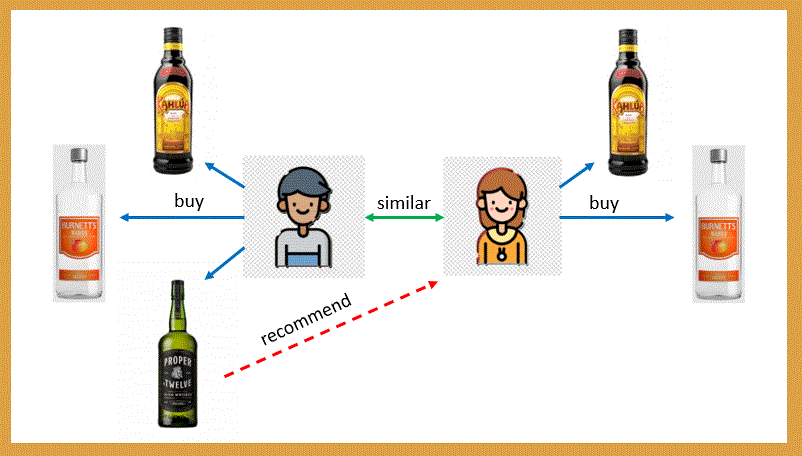

Collaborative filtering recommends items based on similar users' preferences. To calculate the similarities between the vectors, we will be using both cosine similarity and pearson similarity for comparison.

## Cosine Similarity

**Model based on Purchase Count**

In [31]:
# Using purchase count
name = 'cosine'
target = 'Quantity'
cos = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 356911 observations with 1841 users and 3713 items.

Data prepared in: 0.546864s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 18.399ms                       | 54.25      |

| 24.381ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 47.961ms                            | 0.5              | 19              |

| 1.69s                               | 100              | 3713            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.73334s

recommendations finished on 1000/446139 queries. users per second: 3333.78

recommendations finished on 2000/446139 queries. users per second: 3334.51

recommendations finished on 3000/446139 queries. users per second: 3327.48

recommendations finished on 4000/446139 queries. users per second: 3237.94

recommendations finished on 5000/446139 queries. users per second: 3204.1

recommendations finished on 6000/446139 queries. users per second: 3190.74

recommendations finished on 7000/446139 queries. users per second: 3207.67

recommendations finished on 8000/446139 queries. users per second: 3204.07

recommendations finished on 9000/446139 queries. users per second: 3211.29

recommendations finished on 10000/446139 queries. users per second: 3209.95

recommendations finished on 11000/446139 queries. users per second: 3204.5

recommendations finished on 12000/446139 queries. users per second: 3207.71

recommendations finished on 13000/446139 queries. users per second: 3242.59

recommendations finished on 14000/446139 queries. users per second: 3238.39

recommendations finished on 15000/446139 queries. users per second: 3234.74

recommendations finished on 16000/446139 queries. users per second: 3229.47

recommendations finished on 17000/446139 queries. users per second: 3228.8

recommendations finished on 18000/446139 queries. users per second: 3223.48

recommendations finished on 19000/446139 queries. users per second: 3253.05

recommendations finished on 20000/446139 queries. users per second: 3267.78

recommendations finished on 21000/446139 queries. users per second: 3290.92

recommendations finished on 22000/446139 queries. users per second: 3292.89

recommendations finished on 23000/446139 queries. users per second: 3303.98

recommendations finished on 24000/446139 queries. users per second: 3314.73

recommendations finished on 25000/446139 queries. users per second: 3325.78

recommendations finished on 26000/446139 queries. users per second: 3325.18

recommendations finished on 27000/446139 queries. users per second: 3342.33

recommendations finished on 28000/446139 queries. users per second: 3331.88

recommendations finished on 29000/446139 queries. users per second: 3340.64

recommendations finished on 30000/446139 queries. users per second: 3351.64

recommendations finished on 31000/446139 queries. users per second: 3373.37

recommendations finished on 32000/446139 queries. users per second: 3382.76

recommendations finished on 33000/446139 queries. users per second: 3401.66

recommendations finished on 34000/446139 queries. users per second: 3411.38

recommendations finished on 35000/446139 queries. users per second: 3433.78

recommendations finished on 36000/446139 queries. users per second: 3427.54

recommendations finished on 37000/446139 queries. users per second: 3429.82

recommendations finished on 38000/446139 queries. users per second: 3459.32

recommendations finished on 39000/446139 queries. users per second: 3489.54

recommendations finished on 40000/446139 queries. users per second: 3483.5

recommendations finished on 41000/446139 queries. users per second: 3500.79

recommendations finished on 42000/446139 queries. users per second: 3503.11

recommendations finished on 43000/446139 queries. users per second: 3516.24

recommendations finished on 44000/446139 queries. users per second: 3524.1

recommendations finished on 45000/446139 queries. users per second: 3523.29

recommendations finished on 46000/446139 queries. users per second: 3538.4

recommendations finished on 47000/446139 queries. users per second: 3551.65

recommendations finished on 48000/446139 queries. users per second: 3553.48

recommendations finished on 49000/446139 queries. users per second: 3560.92

recommendations finished on 50000/446139 queries. users per second: 3575.63

recommendations finished on 51000/446139 queries. users per second: 3589.61

recommendations finished on 52000/446139 queries. users per second: 3584.42

recommendations finished on 53000/446139 queries. users per second: 3582.21

recommendations finished on 54000/446139 queries. users per second: 3583.32

recommendations finished on 55000/446139 queries. users per second: 3587.06

recommendations finished on 56000/446139 queries. users per second: 3581.36

recommendations finished on 57000/446139 queries. users per second: 3577.46

recommendations finished on 58000/446139 queries. users per second: 3566.92

recommendations finished on 59000/446139 queries. users per second: 3567.66

recommendations finished on 60000/446139 queries. users per second: 3572.63

recommendations finished on 61000/446139 queries. users per second: 3581.12

recommendations finished on 62000/446139 queries. users per second: 3588.46

recommendations finished on 63000/446139 queries. users per second: 3585.62

recommendations finished on 64000/446139 queries. users per second: 3579.4

recommendations finished on 65000/446139 queries. users per second: 3569.9

recommendations finished on 66000/446139 queries. users per second: 3560.78

recommendations finished on 67000/446139 queries. users per second: 3553.68

recommendations finished on 68000/446139 queries. users per second: 3548.45

recommendations finished on 69000/446139 queries. users per second: 3537.9

recommendations finished on 70000/446139 queries. users per second: 3529.08

recommendations finished on 71000/446139 queries. users per second: 3523.21

recommendations finished on 72000/446139 queries. users per second: 3517.28

recommendations finished on 73000/446139 queries. users per second: 3514.02

recommendations finished on 74000/446139 queries. users per second: 3508.68

recommendations finished on 75000/446139 queries. users per second: 3499.21

recommendations finished on 76000/446139 queries. users per second: 3490.47

recommendations finished on 77000/446139 queries. users per second: 3480.52

recommendations finished on 78000/446139 queries. users per second: 3476.42

recommendations finished on 79000/446139 queries. users per second: 3471.25

recommendations finished on 80000/446139 queries. users per second: 3466.39

recommendations finished on 81000/446139 queries. users per second: 3463.37

recommendations finished on 82000/446139 queries. users per second: 3460.25

recommendations finished on 83000/446139 queries. users per second: 3459.07

recommendations finished on 84000/446139 queries. users per second: 3456.56

recommendations finished on 85000/446139 queries. users per second: 3451.63

recommendations finished on 86000/446139 queries. users per second: 3449.47

recommendations finished on 87000/446139 queries. users per second: 3446

recommendations finished on 88000/446139 queries. users per second: 3444.66

recommendations finished on 89000/446139 queries. users per second: 3438.23

recommendations finished on 90000/446139 queries. users per second: 3431.79

recommendations finished on 91000/446139 queries. users per second: 3428.83

recommendations finished on 92000/446139 queries. users per second: 3424.04

recommendations finished on 93000/446139 queries. users per second: 3420.68

recommendations finished on 94000/446139 queries. users per second: 3418.65

recommendations finished on 95000/446139 queries. users per second: 3412.48

recommendations finished on 96000/446139 queries. users per second: 3406.73

recommendations finished on 97000/446139 queries. users per second: 3406.05

recommendations finished on 98000/446139 queries. users per second: 3404.83

recommendations finished on 99000/446139 queries. users per second: 3402.67

recommendations finished on 100000/446139 queries. users per second: 3399.61

recommendations finished on 101000/446139 queries. users per second: 3395.4

recommendations finished on 102000/446139 queries. users per second: 3392.51

recommendations finished on 103000/446139 queries. users per second: 3391.89

recommendations finished on 104000/446139 queries. users per second: 3391.1

recommendations finished on 105000/446139 queries. users per second: 3388.51

recommendations finished on 106000/446139 queries. users per second: 3387.01

recommendations finished on 107000/446139 queries. users per second: 3385.5

recommendations finished on 108000/446139 queries. users per second: 3383.79

recommendations finished on 109000/446139 queries. users per second: 3381.89

recommendations finished on 110000/446139 queries. users per second: 3379.64

recommendations finished on 111000/446139 queries. users per second: 3377.66

recommendations finished on 112000/446139 queries. users per second: 3376.56

recommendations finished on 113000/446139 queries. users per second: 3377.17

recommendations finished on 114000/446139 queries. users per second: 3376.71

recommendations finished on 115000/446139 queries. users per second: 3372.66

recommendations finished on 116000/446139 queries. users per second: 3373.03

recommendations finished on 117000/446139 queries. users per second: 3373.59

recommendations finished on 118000/446139 queries. users per second: 3373.45

recommendations finished on 119000/446139 queries. users per second: 3372.32

recommendations finished on 120000/446139 queries. users per second: 3372.14

recommendations finished on 121000/446139 queries. users per second: 3370.4

recommendations finished on 122000/446139 queries. users per second: 3368.61

recommendations finished on 123000/446139 queries. users per second: 3369.51

recommendations finished on 124000/446139 queries. users per second: 3370.27

recommendations finished on 125000/446139 queries. users per second: 3371.64

recommendations finished on 126000/446139 queries. users per second: 3373.1

recommendations finished on 127000/446139 queries. users per second: 3372.91

recommendations finished on 128000/446139 queries. users per second: 3371.98

recommendations finished on 129000/446139 queries. users per second: 3375.65

recommendations finished on 130000/446139 queries. users per second: 3377.23

recommendations finished on 131000/446139 queries. users per second: 3381.54

recommendations finished on 132000/446139 queries. users per second: 3384.82

recommendations finished on 133000/446139 queries. users per second: 3386.51

recommendations finished on 134000/446139 queries. users per second: 3388.96

recommendations finished on 135000/446139 queries. users per second: 3392.96

recommendations finished on 136000/446139 queries. users per second: 3397.43

recommendations finished on 137000/446139 queries. users per second: 3401.57

recommendations finished on 138000/446139 queries. users per second: 3407.58

recommendations finished on 139000/446139 queries. users per second: 3411.95

recommendations finished on 140000/446139 queries. users per second: 3413.39

recommendations finished on 141000/446139 queries. users per second: 3416.73

recommendations finished on 142000/446139 queries. users per second: 3421.44

recommendations finished on 143000/446139 queries. users per second: 3424.74

recommendations finished on 144000/446139 queries. users per second: 3424.91

recommendations finished on 145000/446139 queries. users per second: 3425.84

recommendations finished on 146000/446139 queries. users per second: 3423.08

recommendations finished on 147000/446139 queries. users per second: 3422.85

recommendations finished on 148000/446139 queries. users per second: 3422.67

recommendations finished on 149000/446139 queries. users per second: 3424.6

recommendations finished on 150000/446139 queries. users per second: 3425.71

recommendations finished on 151000/446139 queries. users per second: 3434.31

recommendations finished on 152000/446139 queries. users per second: 3439.32

recommendations finished on 153000/446139 queries. users per second: 3448.01

recommendations finished on 154000/446139 queries. users per second: 3451.79

recommendations finished on 155000/446139 queries. users per second: 3456.79

recommendations finished on 156000/446139 queries. users per second: 3451.61

recommendations finished on 157000/446139 queries. users per second: 3445.1

recommendations finished on 158000/446139 queries. users per second: 3439.55

recommendations finished on 159000/446139 queries. users per second: 3432.94

recommendations finished on 160000/446139 queries. users per second: 3426.49

recommendations finished on 161000/446139 queries. users per second: 3415.95

recommendations finished on 162000/446139 queries. users per second: 3411.56

recommendations finished on 163000/446139 queries. users per second: 3408.1

recommendations finished on 164000/446139 queries. users per second: 3403.4

recommendations finished on 165000/446139 queries. users per second: 3401.44

recommendations finished on 166000/446139 queries. users per second: 3397.76

recommendations finished on 167000/446139 queries. users per second: 3400.93

recommendations finished on 168000/446139 queries. users per second: 3398

recommendations finished on 169000/446139 queries. users per second: 3392.33

recommendations finished on 170000/446139 queries. users per second: 3389.96

recommendations finished on 171000/446139 queries. users per second: 3386.02

recommendations finished on 172000/446139 queries. users per second: 3379.78

recommendations finished on 173000/446139 queries. users per second: 3377.91

recommendations finished on 174000/446139 queries. users per second: 3380.51

recommendations finished on 175000/446139 queries. users per second: 3380.31

recommendations finished on 176000/446139 queries. users per second: 3380.79

recommendations finished on 177000/446139 queries. users per second: 3381.13

recommendations finished on 178000/446139 queries. users per second: 3382

recommendations finished on 179000/446139 queries. users per second: 3382.64

recommendations finished on 180000/446139 queries. users per second: 3383.08

recommendations finished on 181000/446139 queries. users per second: 3381.64

recommendations finished on 182000/446139 queries. users per second: 3381.12

recommendations finished on 183000/446139 queries. users per second: 3378.86

recommendations finished on 184000/446139 queries. users per second: 3377.79

recommendations finished on 185000/446139 queries. users per second: 3376.06

recommendations finished on 186000/446139 queries. users per second: 3374.47

recommendations finished on 187000/446139 queries. users per second: 3375.01

recommendations finished on 188000/446139 queries. users per second: 3371.72

recommendations finished on 189000/446139 queries. users per second: 3369.49

recommendations finished on 190000/446139 queries. users per second: 3367.67

recommendations finished on 191000/446139 queries. users per second: 3369.14

recommendations finished on 192000/446139 queries. users per second: 3370.33

recommendations finished on 193000/446139 queries. users per second: 3372

recommendations finished on 194000/446139 queries. users per second: 3373.88

recommendations finished on 195000/446139 queries. users per second: 3375.98

recommendations finished on 196000/446139 queries. users per second: 3377.82

recommendations finished on 197000/446139 queries. users per second: 3379.81

recommendations finished on 198000/446139 queries. users per second: 3381.67

recommendations finished on 199000/446139 queries. users per second: 3382.72

recommendations finished on 200000/446139 queries. users per second: 3381.64

recommendations finished on 201000/446139 queries. users per second: 3381.68

recommendations finished on 202000/446139 queries. users per second: 3383.25

recommendations finished on 203000/446139 queries. users per second: 3384.98

recommendations finished on 204000/446139 queries. users per second: 3385.5

recommendations finished on 205000/446139 queries. users per second: 3385.93

recommendations finished on 206000/446139 queries. users per second: 3386.21

recommendations finished on 207000/446139 queries. users per second: 3386.02

recommendations finished on 208000/446139 queries. users per second: 3385.71

recommendations finished on 209000/446139 queries. users per second: 3385.29

recommendations finished on 210000/446139 queries. users per second: 3384.28

recommendations finished on 211000/446139 queries. users per second: 3385.15

recommendations finished on 212000/446139 queries. users per second: 3384.45

recommendations finished on 213000/446139 queries. users per second: 3383.61

recommendations finished on 214000/446139 queries. users per second: 3383.05

recommendations finished on 215000/446139 queries. users per second: 3382.2

recommendations finished on 216000/446139 queries. users per second: 3382.34

recommendations finished on 217000/446139 queries. users per second: 3382.76

recommendations finished on 218000/446139 queries. users per second: 3382.18

recommendations finished on 219000/446139 queries. users per second: 3380.38

recommendations finished on 220000/446139 queries. users per second: 3379.66

recommendations finished on 221000/446139 queries. users per second: 3378.49

recommendations finished on 222000/446139 queries. users per second: 3378.07

recommendations finished on 223000/446139 queries. users per second: 3377.47

recommendations finished on 224000/446139 queries. users per second: 3376.02

recommendations finished on 225000/446139 queries. users per second: 3375.64

recommendations finished on 226000/446139 queries. users per second: 3375.87

recommendations finished on 227000/446139 queries. users per second: 3374.73

recommendations finished on 228000/446139 queries. users per second: 3372.68

recommendations finished on 229000/446139 queries. users per second: 3371.24

recommendations finished on 230000/446139 queries. users per second: 3370.94

recommendations finished on 231000/446139 queries. users per second: 3369.71

recommendations finished on 232000/446139 queries. users per second: 3370.47

recommendations finished on 233000/446139 queries. users per second: 3370.46

recommendations finished on 234000/446139 queries. users per second: 3369.52

recommendations finished on 235000/446139 queries. users per second: 3369.49

recommendations finished on 236000/446139 queries. users per second: 3369.51

recommendations finished on 237000/446139 queries. users per second: 3370.59

recommendations finished on 238000/446139 queries. users per second: 3370.11

recommendations finished on 239000/446139 queries. users per second: 3370.33

recommendations finished on 240000/446139 queries. users per second: 3371.1

recommendations finished on 241000/446139 queries. users per second: 3371.57

recommendations finished on 242000/446139 queries. users per second: 3370.57

recommendations finished on 243000/446139 queries. users per second: 3370.32

recommendations finished on 244000/446139 queries. users per second: 3371.46

recommendations finished on 245000/446139 queries. users per second: 3372.33

recommendations finished on 246000/446139 queries. users per second: 3373.3

recommendations finished on 247000/446139 queries. users per second: 3373.8

recommendations finished on 248000/446139 queries. users per second: 3374.79

recommendations finished on 249000/446139 queries. users per second: 3374.85

recommendations finished on 250000/446139 queries. users per second: 3375.84

recommendations finished on 251000/446139 queries. users per second: 3375.52

recommendations finished on 252000/446139 queries. users per second: 3375.27

recommendations finished on 253000/446139 queries. users per second: 3374

recommendations finished on 254000/446139 queries. users per second: 3374.47

recommendations finished on 255000/446139 queries. users per second: 3375.68

recommendations finished on 256000/446139 queries. users per second: 3377.24

recommendations finished on 257000/446139 queries. users per second: 3378.69

recommendations finished on 258000/446139 queries. users per second: 3381.9

recommendations finished on 259000/446139 queries. users per second: 3383

recommendations finished on 260000/446139 queries. users per second: 3384.31

recommendations finished on 261000/446139 queries. users per second: 3385.92

recommendations finished on 262000/446139 queries. users per second: 3387.02

recommendations finished on 263000/446139 queries. users per second: 3387.2

recommendations finished on 264000/446139 queries. users per second: 3385.89

recommendations finished on 265000/446139 queries. users per second: 3384.76

recommendations finished on 266000/446139 queries. users per second: 3384.98

recommendations finished on 267000/446139 queries. users per second: 3384.81

recommendations finished on 268000/446139 queries. users per second: 3385.3

recommendations finished on 269000/446139 queries. users per second: 3384.78

recommendations finished on 270000/446139 queries. users per second: 3385.14

recommendations finished on 271000/446139 queries. users per second: 3385.08

recommendations finished on 272000/446139 queries. users per second: 3384.64

recommendations finished on 273000/446139 queries. users per second: 3384.96

recommendations finished on 274000/446139 queries. users per second: 3383.88

recommendations finished on 275000/446139 queries. users per second: 3383.95

recommendations finished on 276000/446139 queries. users per second: 3383.68

recommendations finished on 277000/446139 queries. users per second: 3382.9

recommendations finished on 278000/446139 queries. users per second: 3382.24

recommendations finished on 279000/446139 queries. users per second: 3381.8

recommendations finished on 280000/446139 queries. users per second: 3381.27

recommendations finished on 281000/446139 queries. users per second: 3380.92

recommendations finished on 282000/446139 queries. users per second: 3380.89

recommendations finished on 283000/446139 queries. users per second: 3381.63

recommendations finished on 284000/446139 queries. users per second: 3381.84

recommendations finished on 285000/446139 queries. users per second: 3381.76

recommendations finished on 286000/446139 queries. users per second: 3382.07

recommendations finished on 287000/446139 queries. users per second: 3380.9

recommendations finished on 288000/446139 queries. users per second: 3380.65

recommendations finished on 289000/446139 queries. users per second: 3380.86

recommendations finished on 290000/446139 queries. users per second: 3379.61

recommendations finished on 291000/446139 queries. users per second: 3379.93

recommendations finished on 292000/446139 queries. users per second: 3379.47

recommendations finished on 293000/446139 queries. users per second: 3379.71

recommendations finished on 294000/446139 queries. users per second: 3380.14

recommendations finished on 295000/446139 queries. users per second: 3380.4

recommendations finished on 296000/446139 queries. users per second: 3380.34

recommendations finished on 297000/446139 queries. users per second: 3380.37

recommendations finished on 298000/446139 queries. users per second: 3380.13

recommendations finished on 299000/446139 queries. users per second: 3379.87

recommendations finished on 300000/446139 queries. users per second: 3379.36

recommendations finished on 301000/446139 queries. users per second: 3377.66

recommendations finished on 302000/446139 queries. users per second: 3376.44

recommendations finished on 303000/446139 queries. users per second: 3376.3

recommendations finished on 304000/446139 queries. users per second: 3375.14

recommendations finished on 305000/446139 queries. users per second: 3373.92

recommendations finished on 306000/446139 queries. users per second: 3373.5

recommendations finished on 307000/446139 queries. users per second: 3374.57

recommendations finished on 308000/446139 queries. users per second: 3375.02

recommendations finished on 309000/446139 queries. users per second: 3373.42

recommendations finished on 310000/446139 queries. users per second: 3372.99

recommendations finished on 311000/446139 queries. users per second: 3373.15

recommendations finished on 312000/446139 queries. users per second: 3374.27

recommendations finished on 313000/446139 queries. users per second: 3375.74

recommendations finished on 314000/446139 queries. users per second: 3376.39

recommendations finished on 315000/446139 queries. users per second: 3376.82

recommendations finished on 316000/446139 queries. users per second: 3377.74

recommendations finished on 317000/446139 queries. users per second: 3377.62

recommendations finished on 318000/446139 queries. users per second: 3378.46

recommendations finished on 319000/446139 queries. users per second: 3379.37

recommendations finished on 320000/446139 queries. users per second: 3380.59

recommendations finished on 321000/446139 queries. users per second: 3381.43

recommendations finished on 322000/446139 queries. users per second: 3382.12

recommendations finished on 323000/446139 queries. users per second: 3382.14

recommendations finished on 324000/446139 queries. users per second: 3384.16

recommendations finished on 325000/446139 queries. users per second: 3385.41

recommendations finished on 326000/446139 queries. users per second: 3386.76

recommendations finished on 327000/446139 queries. users per second: 3386.79

recommendations finished on 328000/446139 queries. users per second: 3388.43

recommendations finished on 329000/446139 queries. users per second: 3390.62

recommendations finished on 330000/446139 queries. users per second: 3393.13

recommendations finished on 331000/446139 queries. users per second: 3394.43

recommendations finished on 332000/446139 queries. users per second: 3395.19

recommendations finished on 333000/446139 queries. users per second: 3394.52

recommendations finished on 334000/446139 queries. users per second: 3394.79

recommendations finished on 335000/446139 queries. users per second: 3395.55

recommendations finished on 336000/446139 queries. users per second: 3393.38

recommendations finished on 337000/446139 queries. users per second: 3392.17

recommendations finished on 338000/446139 queries. users per second: 3393.56

recommendations finished on 339000/446139 queries. users per second: 3394.03

recommendations finished on 340000/446139 queries. users per second: 3394.31

recommendations finished on 341000/446139 queries. users per second: 3395.07

recommendations finished on 342000/446139 queries. users per second: 3395.02

recommendations finished on 343000/446139 queries. users per second: 3395.28

recommendations finished on 344000/446139 queries. users per second: 3396.1

recommendations finished on 345000/446139 queries. users per second: 3396.15

recommendations finished on 346000/446139 queries. users per second: 3396.22

recommendations finished on 347000/446139 queries. users per second: 3395.74

recommendations finished on 348000/446139 queries. users per second: 3394.79

recommendations finished on 349000/446139 queries. users per second: 3393.79

recommendations finished on 350000/446139 queries. users per second: 3393.72

recommendations finished on 351000/446139 queries. users per second: 3392.97

recommendations finished on 352000/446139 queries. users per second: 3391.97

recommendations finished on 353000/446139 queries. users per second: 3391.97

recommendations finished on 354000/446139 queries. users per second: 3391.63

recommendations finished on 355000/446139 queries. users per second: 3391.11

recommendations finished on 356000/446139 queries. users per second: 3391.22

recommendations finished on 357000/446139 queries. users per second: 3391.6

recommendations finished on 358000/446139 queries. users per second: 3390.9

recommendations finished on 359000/446139 queries. users per second: 3390.21

recommendations finished on 360000/446139 queries. users per second: 3390.01

recommendations finished on 361000/446139 queries. users per second: 3389.74

recommendations finished on 362000/446139 queries. users per second: 3389.12

recommendations finished on 363000/446139 queries. users per second: 3388.13

recommendations finished on 364000/446139 queries. users per second: 3387.29

recommendations finished on 365000/446139 queries. users per second: 3386.76

recommendations finished on 366000/446139 queries. users per second: 3386.29

recommendations finished on 367000/446139 queries. users per second: 3386.24

recommendations finished on 368000/446139 queries. users per second: 3385.93

recommendations finished on 369000/446139 queries. users per second: 3385.65

recommendations finished on 370000/446139 queries. users per second: 3386.79

recommendations finished on 371000/446139 queries. users per second: 3388.12

recommendations finished on 372000/446139 queries. users per second: 3389.48

recommendations finished on 373000/446139 queries. users per second: 3391.83

recommendations finished on 374000/446139 queries. users per second: 3394.69

recommendations finished on 375000/446139 queries. users per second: 3397.47

recommendations finished on 376000/446139 queries. users per second: 3400.09

recommendations finished on 377000/446139 queries. users per second: 3400

recommendations finished on 378000/446139 queries. users per second: 3399.51

recommendations finished on 379000/446139 queries. users per second: 3399.12

recommendations finished on 380000/446139 queries. users per second: 3399.02

recommendations finished on 381000/446139 queries. users per second: 3399.08

recommendations finished on 382000/446139 queries. users per second: 3398.46

recommendations finished on 383000/446139 queries. users per second: 3397.24

recommendations finished on 384000/446139 queries. users per second: 3397.13

recommendations finished on 385000/446139 queries. users per second: 3396

recommendations finished on 386000/446139 queries. users per second: 3395.13

recommendations finished on 387000/446139 queries. users per second: 3394.49

recommendations finished on 388000/446139 queries. users per second: 3393.54

recommendations finished on 389000/446139 queries. users per second: 3393.46

recommendations finished on 390000/446139 queries. users per second: 3393.54

recommendations finished on 391000/446139 queries. users per second: 3393.07

recommendations finished on 392000/446139 queries. users per second: 3393.74

recommendations finished on 393000/446139 queries. users per second: 3393.62

recommendations finished on 394000/446139 queries. users per second: 3393.96

recommendations finished on 395000/446139 queries. users per second: 3394.56

recommendations finished on 396000/446139 queries. users per second: 3395.23

recommendations finished on 397000/446139 queries. users per second: 3395.02

recommendations finished on 398000/446139 queries. users per second: 3395.09

recommendations finished on 399000/446139 queries. users per second: 3395.4

recommendations finished on 400000/446139 queries. users per second: 3396.24

recommendations finished on 401000/446139 queries. users per second: 3395.81

recommendations finished on 402000/446139 queries. users per second: 3395.06

recommendations finished on 403000/446139 queries. users per second: 3395.3

recommendations finished on 404000/446139 queries. users per second: 3394.89

recommendations finished on 405000/446139 queries. users per second: 3394.78

recommendations finished on 406000/446139 queries. users per second: 3395.58

recommendations finished on 407000/446139 queries. users per second: 3395.74

recommendations finished on 408000/446139 queries. users per second: 3395.58

recommendations finished on 409000/446139 queries. users per second: 3396.11

recommendations finished on 410000/446139 queries. users per second: 3396.67

recommendations finished on 411000/446139 queries. users per second: 3396.33

recommendations finished on 412000/446139 queries. users per second: 3395.76

recommendations finished on 413000/446139 queries. users per second: 3396.05

recommendations finished on 414000/446139 queries. users per second: 3397.15

recommendations finished on 415000/446139 queries. users per second: 3397.14

recommendations finished on 416000/446139 queries. users per second: 3397.37

recommendations finished on 417000/446139 queries. users per second: 3397.23

recommendations finished on 418000/446139 queries. users per second: 3397.29

recommendations finished on 419000/446139 queries. users per second: 3397.9

recommendations finished on 420000/446139 queries. users per second: 3398.96

recommendations finished on 421000/446139 queries. users per second: 3399.64

recommendations finished on 422000/446139 queries. users per second: 3400.36

recommendations finished on 423000/446139 queries. users per second: 3400.92

recommendations finished on 424000/446139 queries. users per second: 3402.28

recommendations finished on 425000/446139 queries. users per second: 3402.97

recommendations finished on 426000/446139 queries. users per second: 3401.79

recommendations finished on 427000/446139 queries. users per second: 3401.04

recommendations finished on 428000/446139 queries. users per second: 3399.72

recommendations finished on 429000/446139 queries. users per second: 3399.05

recommendations finished on 430000/446139 queries. users per second: 3398.23

recommendations finished on 431000/446139 queries. users per second: 3396.36

recommendations finished on 432000/446139 queries. users per second: 3393.54

recommendations finished on 433000/446139 queries. users per second: 3392.18

recommendations finished on 434000/446139 queries. users per second: 3390.95

recommendations finished on 435000/446139 queries. users per second: 3389.05

recommendations finished on 436000/446139 queries. users per second: 3386.42

recommendations finished on 437000/446139 queries. users per second: 3383.15

recommendations finished on 438000/446139 queries. users per second: 3378.88

recommendations finished on 439000/446139 queries. users per second: 3377.7

recommendations finished on 440000/446139 queries. users per second: 3376.65

recommendations finished on 441000/446139 queries. users per second: 3375.8

recommendations finished on 442000/446139 queries. users per second: 3375.48

recommendations finished on 443000/446139 queries. users per second: 3375.79

recommendations finished on 444000/446139 queries. users per second: 3374.85

recommendations finished on 445000/446139 queries. users per second: 3374.64

recommendations finished on 446000/446139 queries. users per second: 3373.72

+------------+-----------+--------------------+------+
| CustomerID | StockCode |       score        | rank |
+------------+-----------+--------------------+------+
|    3814    |   989289  | 1111.5561349144523 |  1   |
|    3814    |   944650  | 1111.5561349144523 |  2   |
|    3814    |   962094  | 1074.785236260801  |  3   |
|    3814    |   17088   | 1052.4281993598308 |  4   |
|    3814    |    4000   | 1043.7280049740143 |  5   |
|    3814    |    4184   |  985.11771326245   |  6   |
|    3814    |   21236   | 778.9398930893755  |  7   |
|    3814    |   89838   | 681.4119823035204  |  8   |
|    3814    |   43128   | 562.6939180729524  |  9   |
|    3814    |   26828   | 483.45895597394906 |  10  |
+------------+-----------+--------------------+------+
[4461390 rows x 4 columns]



**Model based on Purchase Dummy**

In [32]:
# Using purchase dummy
name = 'cosine'
target = 'purchase_dummy'
cos_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 5664388 observations with 1841 users and 3846 items.

Data prepared in: 8.91772s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 112.323ms                      | 54.25      |

| 199.079ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 218.87ms                            | 0                | 2               |

| 3.25s                               | 2.75             | 106             |

| 6.23s                               | 5.25             | 211             |

| 9.24s                               | 8.25             | 317             |

| 12.26s                              | 11               | 423             |

| 15.27s                              | 13.5             | 528             |

| 18.24s                              | 16.5             | 635             |

| 21.25s                              | 19.25            | 741             |

| 24.29s                              | 22               | 848             |

| 27.24s                              | 24.75            | 953             |

| 30.25s                              | 27.5             | 1059            |

| 33.25s                              | 30.25            | 1166            |

| 36.23s                              | 33               | 1271            |

| 39.25s                              | 35.75            | 1377            |

| 42.24s                              | 38.5             | 1483            |

| 45.24s                              | 41.25            | 1589            |

| 48.28s                              | 44               | 1696            |

| 51.23s                              | 46.75            | 1801            |

| 54.23s                              | 49.5             | 1907            |

| 57.26s                              | 52.25            | 2014            |

| 1m 0s                               | 55               | 2120            |

| 1m 3s                               | 57.75            | 2227            |

| 1m 6s                               | 60.5             | 2332            |

| 1m 9s                               | 63.25            | 2437            |

| 1m 12s                              | 66               | 2545            |

| 1m 15s                              | 68.75            | 2650            |

| 1m 18s                              | 71.5             | 2756            |

| 1m 21s                              | 74.25            | 2862            |

| 1m 24s                              | 77               | 2970            |

| 1m 27s                              | 79.75            | 3075            |

| 1m 30s                              | 82.75            | 3183            |

| 1m 33s                              | 85.5             | 3290            |

| 1m 36s                              | 88.25            | 3394            |

| 1m 39s                              | 91               | 3503            |

| 1m 42s                              | 93.75            | 3607            |

| 1m 45s                              | 96.5             | 3714            |

| 1m 48s                              | 99.25            | 3820            |

| 1m 49s                              | 100              | 3846            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 109.595s

recommendations finished on 1000/446139 queries. users per second: 572.854

recommendations finished on 2000/446139 queries. users per second: 569.378

recommendations finished on 3000/446139 queries. users per second: 566.329

recommendations finished on 4000/446139 queries. users per second: 565.91

recommendations finished on 5000/446139 queries. users per second: 564.781

recommendations finished on 6000/446139 queries. users per second: 564.918

recommendations finished on 7000/446139 queries. users per second: 565.004

recommendations finished on 8000/446139 queries. users per second: 565.727

recommendations finished on 9000/446139 queries. users per second: 566.63

recommendations finished on 10000/446139 queries. users per second: 566.45

recommendations finished on 11000/446139 queries. users per second: 566.661

recommendations finished on 12000/446139 queries. users per second: 567.333

recommendations finished on 13000/446139 queries. users per second: 567.575

recommendations finished on 14000/446139 queries. users per second: 567.907

recommendations finished on 15000/446139 queries. users per second: 567.986

recommendations finished on 16000/446139 queries. users per second: 567.882

recommendations finished on 17000/446139 queries. users per second: 568.016

recommendations finished on 18000/446139 queries. users per second: 568.169

recommendations finished on 19000/446139 queries. users per second: 568.489

recommendations finished on 20000/446139 queries. users per second: 568.555

recommendations finished on 21000/446139 queries. users per second: 568.796

recommendations finished on 22000/446139 queries. users per second: 568.332

recommendations finished on 23000/446139 queries. users per second: 568.577

recommendations finished on 24000/446139 queries. users per second: 568.673

recommendations finished on 25000/446139 queries. users per second: 568.626

recommendations finished on 26000/446139 queries. users per second: 568.789

recommendations finished on 27000/446139 queries. users per second: 568.866

recommendations finished on 28000/446139 queries. users per second: 568.902

recommendations finished on 29000/446139 queries. users per second: 568.666

recommendations finished on 30000/446139 queries. users per second: 568.641

recommendations finished on 31000/446139 queries. users per second: 568.671

recommendations finished on 32000/446139 queries. users per second: 568.684

recommendations finished on 33000/446139 queries. users per second: 568.872

recommendations finished on 34000/446139 queries. users per second: 568.817

recommendations finished on 35000/446139 queries. users per second: 569.168

recommendations finished on 36000/446139 queries. users per second: 569.451

recommendations finished on 37000/446139 queries. users per second: 569.582

recommendations finished on 38000/446139 queries. users per second: 569.961

recommendations finished on 39000/446139 queries. users per second: 569.868

recommendations finished on 40000/446139 queries. users per second: 569.753

recommendations finished on 41000/446139 queries. users per second: 569.824

recommendations finished on 42000/446139 queries. users per second: 569.946

recommendations finished on 43000/446139 queries. users per second: 570.185

recommendations finished on 44000/446139 queries. users per second: 570.403

recommendations finished on 45000/446139 queries. users per second: 570.715

recommendations finished on 46000/446139 queries. users per second: 570.861

recommendations finished on 47000/446139 queries. users per second: 570.959

recommendations finished on 48000/446139 queries. users per second: 571.1

recommendations finished on 49000/446139 queries. users per second: 571.186

recommendations finished on 50000/446139 queries. users per second: 571.434

recommendations finished on 51000/446139 queries. users per second: 571.579

recommendations finished on 52000/446139 queries. users per second: 571.554

recommendations finished on 53000/446139 queries. users per second: 571.73

recommendations finished on 54000/446139 queries. users per second: 571.832

recommendations finished on 55000/446139 queries. users per second: 571.823

recommendations finished on 56000/446139 queries. users per second: 571.851

recommendations finished on 57000/446139 queries. users per second: 571.877

recommendations finished on 58000/446139 queries. users per second: 571.923

recommendations finished on 59000/446139 queries. users per second: 571.848

recommendations finished on 60000/446139 queries. users per second: 571.847

recommendations finished on 61000/446139 queries. users per second: 571.819

recommendations finished on 62000/446139 queries. users per second: 571.688

recommendations finished on 63000/446139 queries. users per second: 571.502

recommendations finished on 64000/446139 queries. users per second: 571.422

recommendations finished on 65000/446139 queries. users per second: 571.278

recommendations finished on 66000/446139 queries. users per second: 571.233

recommendations finished on 67000/446139 queries. users per second: 571.159

recommendations finished on 68000/446139 queries. users per second: 571.053

recommendations finished on 69000/446139 queries. users per second: 570.663

recommendations finished on 70000/446139 queries. users per second: 570.384

recommendations finished on 71000/446139 queries. users per second: 570.073

recommendations finished on 72000/446139 queries. users per second: 569.833

recommendations finished on 73000/446139 queries. users per second: 569.7

recommendations finished on 74000/446139 queries. users per second: 569.429

recommendations finished on 75000/446139 queries. users per second: 569.033

recommendations finished on 76000/446139 queries. users per second: 568.734

recommendations finished on 77000/446139 queries. users per second: 568.397

recommendations finished on 78000/446139 queries. users per second: 568.08

recommendations finished on 79000/446139 queries. users per second: 567.815

recommendations finished on 80000/446139 queries. users per second: 567.654

recommendations finished on 81000/446139 queries. users per second: 567.461

recommendations finished on 82000/446139 queries. users per second: 567.365

recommendations finished on 83000/446139 queries. users per second: 567.169

recommendations finished on 84000/446139 queries. users per second: 566.976

recommendations finished on 85000/446139 queries. users per second: 566.811

recommendations finished on 86000/446139 queries. users per second: 566.547

recommendations finished on 87000/446139 queries. users per second: 566.304

recommendations finished on 88000/446139 queries. users per second: 566.13

recommendations finished on 89000/446139 queries. users per second: 565.981

recommendations finished on 90000/446139 queries. users per second: 565.839

recommendations finished on 91000/446139 queries. users per second: 565.717

recommendations finished on 92000/446139 queries. users per second: 565.523

recommendations finished on 93000/446139 queries. users per second: 565.346

recommendations finished on 94000/446139 queries. users per second: 565.11

recommendations finished on 95000/446139 queries. users per second: 564.731

recommendations finished on 96000/446139 queries. users per second: 563.631

recommendations finished on 97000/446139 queries. users per second: 563.412

recommendations finished on 98000/446139 queries. users per second: 563.169

recommendations finished on 99000/446139 queries. users per second: 562.934

recommendations finished on 100000/446139 queries. users per second: 562.813

recommendations finished on 101000/446139 queries. users per second: 562.714

recommendations finished on 102000/446139 queries. users per second: 562.672

recommendations finished on 103000/446139 queries. users per second: 562.603

recommendations finished on 104000/446139 queries. users per second: 562.529

recommendations finished on 105000/446139 queries. users per second: 562.501

recommendations finished on 106000/446139 queries. users per second: 562.407

recommendations finished on 107000/446139 queries. users per second: 562.262

recommendations finished on 108000/446139 queries. users per second: 562.155

recommendations finished on 109000/446139 queries. users per second: 562.059

recommendations finished on 110000/446139 queries. users per second: 562.002

recommendations finished on 111000/446139 queries. users per second: 561.92

recommendations finished on 112000/446139 queries. users per second: 561.887

recommendations finished on 113000/446139 queries. users per second: 561.802

recommendations finished on 114000/446139 queries. users per second: 561.634

recommendations finished on 115000/446139 queries. users per second: 561.514

recommendations finished on 116000/446139 queries. users per second: 561.402

recommendations finished on 117000/446139 queries. users per second: 561.295

recommendations finished on 118000/446139 queries. users per second: 561.253

recommendations finished on 119000/446139 queries. users per second: 561.257

recommendations finished on 120000/446139 queries. users per second: 561.195

recommendations finished on 121000/446139 queries. users per second: 561.154

recommendations finished on 122000/446139 queries. users per second: 561.146

recommendations finished on 123000/446139 queries. users per second: 561.127

recommendations finished on 124000/446139 queries. users per second: 561.067

recommendations finished on 125000/446139 queries. users per second: 561.001

recommendations finished on 126000/446139 queries. users per second: 560.965

recommendations finished on 127000/446139 queries. users per second: 560.891

recommendations finished on 128000/446139 queries. users per second: 560.762

recommendations finished on 129000/446139 queries. users per second: 560.728

recommendations finished on 130000/446139 queries. users per second: 560.685

recommendations finished on 131000/446139 queries. users per second: 560.653

recommendations finished on 132000/446139 queries. users per second: 560.617

recommendations finished on 133000/446139 queries. users per second: 560.547

recommendations finished on 134000/446139 queries. users per second: 560.417

recommendations finished on 135000/446139 queries. users per second: 560.396

recommendations finished on 136000/446139 queries. users per second: 560.383

recommendations finished on 137000/446139 queries. users per second: 560.364

recommendations finished on 138000/446139 queries. users per second: 560.414

recommendations finished on 139000/446139 queries. users per second: 560.453

recommendations finished on 140000/446139 queries. users per second: 560.474

recommendations finished on 141000/446139 queries. users per second: 560.512

recommendations finished on 142000/446139 queries. users per second: 560.557

recommendations finished on 143000/446139 queries. users per second: 560.561

recommendations finished on 144000/446139 queries. users per second: 560.568

recommendations finished on 145000/446139 queries. users per second: 560.599

recommendations finished on 146000/446139 queries. users per second: 560.562

recommendations finished on 147000/446139 queries. users per second: 560.55

recommendations finished on 148000/446139 queries. users per second: 560.562

recommendations finished on 149000/446139 queries. users per second: 560.616

recommendations finished on 150000/446139 queries. users per second: 560.598

recommendations finished on 151000/446139 queries. users per second: 560.568

recommendations finished on 152000/446139 queries. users per second: 560.638

recommendations finished on 153000/446139 queries. users per second: 560.824

recommendations finished on 154000/446139 queries. users per second: 560.991

recommendations finished on 155000/446139 queries. users per second: 561.163

recommendations finished on 156000/446139 queries. users per second: 561.355

recommendations finished on 157000/446139 queries. users per second: 561.552

recommendations finished on 158000/446139 queries. users per second: 561.742

recommendations finished on 159000/446139 queries. users per second: 561.895

recommendations finished on 160000/446139 queries. users per second: 562.025

recommendations finished on 161000/446139 queries. users per second: 562.099

recommendations finished on 162000/446139 queries. users per second: 562.189

recommendations finished on 163000/446139 queries. users per second: 562.331

recommendations finished on 164000/446139 queries. users per second: 562.453

recommendations finished on 165000/446139 queries. users per second: 562.53

recommendations finished on 166000/446139 queries. users per second: 562.603

recommendations finished on 167000/446139 queries. users per second: 562.68

recommendations finished on 168000/446139 queries. users per second: 562.774

recommendations finished on 169000/446139 queries. users per second: 562.913

recommendations finished on 170000/446139 queries. users per second: 563.012

recommendations finished on 171000/446139 queries. users per second: 563.13

recommendations finished on 172000/446139 queries. users per second: 563.252

recommendations finished on 173000/446139 queries. users per second: 563.356

recommendations finished on 174000/446139 queries. users per second: 563.463

recommendations finished on 175000/446139 queries. users per second: 563.534

recommendations finished on 176000/446139 queries. users per second: 563.56

recommendations finished on 177000/446139 queries. users per second: 563.654

recommendations finished on 178000/446139 queries. users per second: 563.686

recommendations finished on 179000/446139 queries. users per second: 563.677

recommendations finished on 180000/446139 queries. users per second: 563.642

recommendations finished on 181000/446139 queries. users per second: 563.588

recommendations finished on 182000/446139 queries. users per second: 563.469

recommendations finished on 183000/446139 queries. users per second: 563.369

recommendations finished on 184000/446139 queries. users per second: 563.297

recommendations finished on 185000/446139 queries. users per second: 563.246

recommendations finished on 186000/446139 queries. users per second: 563.197

recommendations finished on 187000/446139 queries. users per second: 563.237

recommendations finished on 188000/446139 queries. users per second: 563.236

recommendations finished on 189000/446139 queries. users per second: 563.298

recommendations finished on 190000/446139 queries. users per second: 563.358

recommendations finished on 191000/446139 queries. users per second: 563.373

recommendations finished on 192000/446139 queries. users per second: 563.408

recommendations finished on 193000/446139 queries. users per second: 563.423

recommendations finished on 194000/446139 queries. users per second: 563.443

recommendations finished on 195000/446139 queries. users per second: 563.484

recommendations finished on 196000/446139 queries. users per second: 563.545

recommendations finished on 197000/446139 queries. users per second: 563.606

recommendations finished on 198000/446139 queries. users per second: 563.606

recommendations finished on 199000/446139 queries. users per second: 563.521

recommendations finished on 200000/446139 queries. users per second: 563.473

recommendations finished on 201000/446139 queries. users per second: 563.452

recommendations finished on 202000/446139 queries. users per second: 563.407

recommendations finished on 203000/446139 queries. users per second: 563.312

recommendations finished on 204000/446139 queries. users per second: 563.241

recommendations finished on 205000/446139 queries. users per second: 563.115

recommendations finished on 206000/446139 queries. users per second: 563.012

recommendations finished on 207000/446139 queries. users per second: 562.977

recommendations finished on 208000/446139 queries. users per second: 562.942

recommendations finished on 209000/446139 queries. users per second: 562.935

recommendations finished on 210000/446139 queries. users per second: 562.939

recommendations finished on 211000/446139 queries. users per second: 562.95

recommendations finished on 212000/446139 queries. users per second: 562.983

recommendations finished on 213000/446139 queries. users per second: 563.023

recommendations finished on 214000/446139 queries. users per second: 563.07

recommendations finished on 215000/446139 queries. users per second: 563.131

recommendations finished on 216000/446139 queries. users per second: 563.196

recommendations finished on 217000/446139 queries. users per second: 563.265

recommendations finished on 218000/446139 queries. users per second: 563.327

recommendations finished on 219000/446139 queries. users per second: 563.311

recommendations finished on 220000/446139 queries. users per second: 563.238

recommendations finished on 221000/446139 queries. users per second: 563.193

recommendations finished on 222000/446139 queries. users per second: 563.167

recommendations finished on 223000/446139 queries. users per second: 563.152

recommendations finished on 224000/446139 queries. users per second: 563.171

recommendations finished on 225000/446139 queries. users per second: 563.119

recommendations finished on 226000/446139 queries. users per second: 563.103

recommendations finished on 227000/446139 queries. users per second: 563.062

recommendations finished on 228000/446139 queries. users per second: 563.065

recommendations finished on 229000/446139 queries. users per second: 563.019

recommendations finished on 230000/446139 queries. users per second: 563.009

recommendations finished on 231000/446139 queries. users per second: 562.95

recommendations finished on 232000/446139 queries. users per second: 562.875

recommendations finished on 233000/446139 queries. users per second: 562.819

recommendations finished on 234000/446139 queries. users per second: 562.779

recommendations finished on 235000/446139 queries. users per second: 562.746

recommendations finished on 236000/446139 queries. users per second: 562.704

recommendations finished on 237000/446139 queries. users per second: 562.718

recommendations finished on 238000/446139 queries. users per second: 562.758

recommendations finished on 239000/446139 queries. users per second: 562.794

recommendations finished on 240000/446139 queries. users per second: 562.829

recommendations finished on 241000/446139 queries. users per second: 562.865

recommendations finished on 242000/446139 queries. users per second: 562.902

recommendations finished on 243000/446139 queries. users per second: 562.933

recommendations finished on 244000/446139 queries. users per second: 562.98

recommendations finished on 245000/446139 queries. users per second: 563.024

recommendations finished on 246000/446139 queries. users per second: 563.07

recommendations finished on 247000/446139 queries. users per second: 563.105

recommendations finished on 248000/446139 queries. users per second: 563.171

recommendations finished on 249000/446139 queries. users per second: 563.211

recommendations finished on 250000/446139 queries. users per second: 563.241

recommendations finished on 251000/446139 queries. users per second: 563.299

recommendations finished on 252000/446139 queries. users per second: 563.371

recommendations finished on 253000/446139 queries. users per second: 563.369

recommendations finished on 254000/446139 queries. users per second: 563.385

recommendations finished on 255000/446139 queries. users per second: 563.365

recommendations finished on 256000/446139 queries. users per second: 563.394

recommendations finished on 257000/446139 queries. users per second: 563.384

recommendations finished on 258000/446139 queries. users per second: 563.381

recommendations finished on 259000/446139 queries. users per second: 563.371

recommendations finished on 260000/446139 queries. users per second: 563.356

recommendations finished on 261000/446139 queries. users per second: 563.328

recommendations finished on 262000/446139 queries. users per second: 563.319

recommendations finished on 263000/446139 queries. users per second: 563.293

recommendations finished on 264000/446139 queries. users per second: 563.251

recommendations finished on 265000/446139 queries. users per second: 563.191

recommendations finished on 266000/446139 queries. users per second: 563.143

recommendations finished on 267000/446139 queries. users per second: 563.112

recommendations finished on 268000/446139 queries. users per second: 563.056

recommendations finished on 269000/446139 queries. users per second: 562.952

recommendations finished on 270000/446139 queries. users per second: 562.816

recommendations finished on 271000/446139 queries. users per second: 562.723

recommendations finished on 272000/446139 queries. users per second: 562.658

recommendations finished on 273000/446139 queries. users per second: 562.605

recommendations finished on 274000/446139 queries. users per second: 562.523

recommendations finished on 275000/446139 queries. users per second: 562.477

recommendations finished on 276000/446139 queries. users per second: 562.361

recommendations finished on 277000/446139 queries. users per second: 562.303

recommendations finished on 278000/446139 queries. users per second: 562.261

recommendations finished on 279000/446139 queries. users per second: 562.22

recommendations finished on 280000/446139 queries. users per second: 562.169

recommendations finished on 281000/446139 queries. users per second: 562.18

recommendations finished on 282000/446139 queries. users per second: 562.176

recommendations finished on 283000/446139 queries. users per second: 562.164

recommendations finished on 284000/446139 queries. users per second: 562.108

recommendations finished on 285000/446139 queries. users per second: 562.052

recommendations finished on 286000/446139 queries. users per second: 562.046

recommendations finished on 287000/446139 queries. users per second: 562.03

recommendations finished on 288000/446139 queries. users per second: 561.957

recommendations finished on 289000/446139 queries. users per second: 561.906

recommendations finished on 290000/446139 queries. users per second: 561.903

recommendations finished on 291000/446139 queries. users per second: 561.857

recommendations finished on 292000/446139 queries. users per second: 561.789

recommendations finished on 293000/446139 queries. users per second: 561.747

recommendations finished on 294000/446139 queries. users per second: 561.767

recommendations finished on 295000/446139 queries. users per second: 561.768

recommendations finished on 296000/446139 queries. users per second: 561.775

recommendations finished on 297000/446139 queries. users per second: 561.817

recommendations finished on 298000/446139 queries. users per second: 561.812

recommendations finished on 299000/446139 queries. users per second: 561.854

recommendations finished on 300000/446139 queries. users per second: 561.87

recommendations finished on 301000/446139 queries. users per second: 561.903

recommendations finished on 302000/446139 queries. users per second: 561.872

recommendations finished on 303000/446139 queries. users per second: 561.899

recommendations finished on 304000/446139 queries. users per second: 561.947

recommendations finished on 305000/446139 queries. users per second: 561.996

recommendations finished on 306000/446139 queries. users per second: 562.055

recommendations finished on 307000/446139 queries. users per second: 562.106

recommendations finished on 308000/446139 queries. users per second: 562.167

recommendations finished on 309000/446139 queries. users per second: 562.151

recommendations finished on 310000/446139 queries. users per second: 562.122

recommendations finished on 311000/446139 queries. users per second: 562.121

recommendations finished on 312000/446139 queries. users per second: 562.15

recommendations finished on 313000/446139 queries. users per second: 562.168

recommendations finished on 314000/446139 queries. users per second: 562.167

recommendations finished on 315000/446139 queries. users per second: 562.18

recommendations finished on 316000/446139 queries. users per second: 562.19

recommendations finished on 317000/446139 queries. users per second: 562.218

recommendations finished on 318000/446139 queries. users per second: 562.261

recommendations finished on 319000/446139 queries. users per second: 562.295

recommendations finished on 320000/446139 queries. users per second: 562.247

recommendations finished on 321000/446139 queries. users per second: 562.238

recommendations finished on 322000/446139 queries. users per second: 562.218

recommendations finished on 323000/446139 queries. users per second: 562.208

recommendations finished on 324000/446139 queries. users per second: 562.217

recommendations finished on 325000/446139 queries. users per second: 562.247

recommendations finished on 326000/446139 queries. users per second: 562.25

recommendations finished on 327000/446139 queries. users per second: 562.244

recommendations finished on 328000/446139 queries. users per second: 562.26

recommendations finished on 329000/446139 queries. users per second: 562.29

recommendations finished on 330000/446139 queries. users per second: 562.245

recommendations finished on 331000/446139 queries. users per second: 562.235

recommendations finished on 332000/446139 queries. users per second: 562.195

recommendations finished on 333000/446139 queries. users per second: 562.205

recommendations finished on 334000/446139 queries. users per second: 562.187

recommendations finished on 335000/446139 queries. users per second: 562.207

recommendations finished on 336000/446139 queries. users per second: 562.161

recommendations finished on 337000/446139 queries. users per second: 562.147

recommendations finished on 338000/446139 queries. users per second: 562.1

recommendations finished on 339000/446139 queries. users per second: 562.034

recommendations finished on 340000/446139 queries. users per second: 561.974

recommendations finished on 341000/446139 queries. users per second: 561.914

recommendations finished on 342000/446139 queries. users per second: 561.831

recommendations finished on 343000/446139 queries. users per second: 561.714

recommendations finished on 344000/446139 queries. users per second: 561.626

recommendations finished on 345000/446139 queries. users per second: 561.585

recommendations finished on 346000/446139 queries. users per second: 561.536

recommendations finished on 347000/446139 queries. users per second: 561.458

recommendations finished on 348000/446139 queries. users per second: 561.36

recommendations finished on 349000/446139 queries. users per second: 561.27

recommendations finished on 350000/446139 queries. users per second: 561.214

recommendations finished on 351000/446139 queries. users per second: 561.178

recommendations finished on 352000/446139 queries. users per second: 561.14

recommendations finished on 353000/446139 queries. users per second: 561.09

recommendations finished on 354000/446139 queries. users per second: 561.021

recommendations finished on 355000/446139 queries. users per second: 560.998

recommendations finished on 356000/446139 queries. users per second: 560.967

recommendations finished on 357000/446139 queries. users per second: 560.963

recommendations finished on 358000/446139 queries. users per second: 560.933

recommendations finished on 359000/446139 queries. users per second: 560.892

recommendations finished on 360000/446139 queries. users per second: 560.853

recommendations finished on 361000/446139 queries. users per second: 560.862

recommendations finished on 362000/446139 queries. users per second: 560.857

recommendations finished on 363000/446139 queries. users per second: 560.861

recommendations finished on 364000/446139 queries. users per second: 560.873

recommendations finished on 365000/446139 queries. users per second: 560.86

recommendations finished on 366000/446139 queries. users per second: 560.826

recommendations finished on 367000/446139 queries. users per second: 560.846

recommendations finished on 368000/446139 queries. users per second: 560.873

recommendations finished on 369000/446139 queries. users per second: 560.866

recommendations finished on 370000/446139 queries. users per second: 560.862

recommendations finished on 371000/446139 queries. users per second: 560.868

recommendations finished on 372000/446139 queries. users per second: 560.829

recommendations finished on 373000/446139 queries. users per second: 560.804

recommendations finished on 374000/446139 queries. users per second: 560.778

recommendations finished on 375000/446139 queries. users per second: 560.752

recommendations finished on 376000/446139 queries. users per second: 560.736

recommendations finished on 377000/446139 queries. users per second: 560.723

recommendations finished on 378000/446139 queries. users per second: 560.71

recommendations finished on 379000/446139 queries. users per second: 560.699

recommendations finished on 380000/446139 queries. users per second: 560.682

recommendations finished on 381000/446139 queries. users per second: 560.684

recommendations finished on 382000/446139 queries. users per second: 560.684

recommendations finished on 383000/446139 queries. users per second: 560.658

recommendations finished on 384000/446139 queries. users per second: 560.625

recommendations finished on 385000/446139 queries. users per second: 560.598

recommendations finished on 386000/446139 queries. users per second: 560.571

recommendations finished on 387000/446139 queries. users per second: 560.588

recommendations finished on 388000/446139 queries. users per second: 560.583

recommendations finished on 389000/446139 queries. users per second: 560.559

recommendations finished on 390000/446139 queries. users per second: 560.54

recommendations finished on 391000/446139 queries. users per second: 560.539

recommendations finished on 392000/446139 queries. users per second: 560.515

recommendations finished on 393000/446139 queries. users per second: 560.487

recommendations finished on 394000/446139 queries. users per second: 560.422

recommendations finished on 395000/446139 queries. users per second: 560.384

recommendations finished on 396000/446139 queries. users per second: 560.343

recommendations finished on 397000/446139 queries. users per second: 560.304

recommendations finished on 398000/446139 queries. users per second: 560.268

recommendations finished on 399000/446139 queries. users per second: 560.205

recommendations finished on 400000/446139 queries. users per second: 560.132

recommendations finished on 401000/446139 queries. users per second: 560.094

recommendations finished on 402000/446139 queries. users per second: 560.051

recommendations finished on 403000/446139 queries. users per second: 560.016

recommendations finished on 404000/446139 queries. users per second: 559.975

recommendations finished on 405000/446139 queries. users per second: 559.941

recommendations finished on 406000/446139 queries. users per second: 559.896

recommendations finished on 407000/446139 queries. users per second: 559.885

recommendations finished on 408000/446139 queries. users per second: 559.866

recommendations finished on 409000/446139 queries. users per second: 559.869

recommendations finished on 410000/446139 queries. users per second: 559.883

recommendations finished on 411000/446139 queries. users per second: 559.891

recommendations finished on 412000/446139 queries. users per second: 559.881

recommendations finished on 413000/446139 queries. users per second: 559.87

recommendations finished on 414000/446139 queries. users per second: 559.88

recommendations finished on 415000/446139 queries. users per second: 559.911

recommendations finished on 416000/446139 queries. users per second: 559.923

recommendations finished on 417000/446139 queries. users per second: 559.906

recommendations finished on 418000/446139 queries. users per second: 559.906

recommendations finished on 419000/446139 queries. users per second: 559.908

recommendations finished on 420000/446139 queries. users per second: 559.894

recommendations finished on 421000/446139 queries. users per second: 559.928

recommendations finished on 422000/446139 queries. users per second: 559.925

recommendations finished on 423000/446139 queries. users per second: 559.908

recommendations finished on 424000/446139 queries. users per second: 559.898

recommendations finished on 425000/446139 queries. users per second: 559.893

recommendations finished on 426000/446139 queries. users per second: 559.877

recommendations finished on 427000/446139 queries. users per second: 559.863

recommendations finished on 428000/446139 queries. users per second: 559.844

recommendations finished on 429000/446139 queries. users per second: 559.826

recommendations finished on 430000/446139 queries. users per second: 559.833

recommendations finished on 431000/446139 queries. users per second: 559.837

recommendations finished on 432000/446139 queries. users per second: 559.839

recommendations finished on 433000/446139 queries. users per second: 559.857

recommendations finished on 434000/446139 queries. users per second: 559.854

recommendations finished on 435000/446139 queries. users per second: 559.844

recommendations finished on 436000/446139 queries. users per second: 559.836

recommendations finished on 437000/446139 queries. users per second: 559.593

recommendations finished on 438000/446139 queries. users per second: 559.148

recommendations finished on 439000/446139 queries. users per second: 558.727

recommendations finished on 440000/446139 queries. users per second: 558.346

recommendations finished on 441000/446139 queries. users per second: 557.974

recommendations finished on 442000/446139 queries. users per second: 557.8

recommendations finished on 443000/446139 queries. users per second: 557.639

recommendations finished on 444000/446139 queries. users per second: 557.469

recommendations finished on 445000/446139 queries. users per second: 557.297

recommendations finished on 446000/446139 queries. users per second: 557.129

+------------+-----------+-----------------------+------+
| CustomerID | StockCode |         score         | rank |
+------------+-----------+-----------------------+------+
|    3814    |   64776   |  0.002809009901859547 |  1   |
|    3814    |   11298   | 0.0021878847949355694 |  2   |
|    3814    |   64147   |  0.002043371469202176 |  3   |
|    3814    |   18006   |  0.002004592000091033 |  4   |
|    3814    |   17086   |  0.001672830751127311 |  5   |
|    3814    |   46504   | 0.0016660280708715326 |  6   |
|    3814    |   41692   | 0.0016513583389142284 |  7   |
|    3814    |    4356   | 0.0015974529758657036 |  8   |
|    3814    |   65416   | 0.0015389453650223714 |  9   |
|    3814    |   15628   | 0.0014486377293111612 |  10  |
+------------+-----------+-----------------------+------+
[4461390 rows x 4 columns]



**Model based on Scaled Purchase Count**

In [33]:
# Using scaled purchase count
name = 'cosine' 
target = 'scaled_purchase_freq' 
cos_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 354720 observations with 1839 users and 3035 items.

Data prepared in: 0.571088s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 24.846ms                       | 54.25      |

| 31.024ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 48.901ms                            | 0                | 0               |

| 1.62s                               | 100              | 3035            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.67206s

recommendations finished on 1000/446139 queries. users per second: 3442.14

recommendations finished on 2000/446139 queries. users per second: 3273.08

recommendations finished on 3000/446139 queries. users per second: 3259.91

recommendations finished on 4000/446139 queries. users per second: 3181.64

recommendations finished on 5000/446139 queries. users per second: 3122.45

recommendations finished on 6000/446139 queries. users per second: 3122.01

recommendations finished on 7000/446139 queries. users per second: 3143.42

recommendations finished on 8000/446139 queries. users per second: 3134.65

recommendations finished on 9000/446139 queries. users per second: 3147.71

recommendations finished on 10000/446139 queries. users per second: 3152.19

recommendations finished on 11000/446139 queries. users per second: 3140.84

recommendations finished on 12000/446139 queries. users per second: 3142.11

recommendations finished on 13000/446139 queries. users per second: 3185.4

recommendations finished on 14000/446139 queries. users per second: 3176.04

recommendations finished on 15000/446139 queries. users per second: 3167.76

recommendations finished on 16000/446139 queries. users per second: 3159.85

recommendations finished on 17000/446139 queries. users per second: 3158.6

recommendations finished on 18000/446139 queries. users per second: 3167.83

recommendations finished on 19000/446139 queries. users per second: 3187.3

recommendations finished on 20000/446139 queries. users per second: 3225.84

recommendations finished on 21000/446139 queries. users per second: 3243.62

recommendations finished on 22000/446139 queries. users per second: 3248.74

recommendations finished on 23000/446139 queries. users per second: 3265.89

recommendations finished on 24000/446139 queries. users per second: 3281.63

recommendations finished on 25000/446139 queries. users per second: 3288.73

recommendations finished on 26000/446139 queries. users per second: 3300.17

recommendations finished on 27000/446139 queries. users per second: 3302.85

recommendations finished on 28000/446139 queries. users per second: 3313.9

recommendations finished on 29000/446139 queries. users per second: 3320.99

recommendations finished on 30000/446139 queries. users per second: 3346.28

recommendations finished on 31000/446139 queries. users per second: 3354.72

recommendations finished on 32000/446139 queries. users per second: 3377.39

recommendations finished on 33000/446139 queries. users per second: 3382.42

recommendations finished on 34000/446139 queries. users per second: 3400.11

recommendations finished on 35000/446139 queries. users per second: 3394.44

recommendations finished on 36000/446139 queries. users per second: 3409.91

recommendations finished on 37000/446139 queries. users per second: 3432.13

recommendations finished on 38000/446139 queries. users per second: 3460.27

recommendations finished on 39000/446139 queries. users per second: 3461.78

recommendations finished on 40000/446139 queries. users per second: 3476.4

recommendations finished on 41000/446139 queries. users per second: 3479.16

recommendations finished on 42000/446139 queries. users per second: 3491.07

recommendations finished on 43000/446139 queries. users per second: 3497.04

recommendations finished on 44000/446139 queries. users per second: 3497.28

recommendations finished on 45000/446139 queries. users per second: 3506.21

recommendations finished on 46000/446139 queries. users per second: 3523.41

recommendations finished on 47000/446139 queries. users per second: 3528.68

recommendations finished on 48000/446139 queries. users per second: 3542.28

recommendations finished on 49000/446139 queries. users per second: 3556.53

recommendations finished on 50000/446139 queries. users per second: 3566.62

recommendations finished on 51000/446139 queries. users per second: 3549.39

recommendations finished on 52000/446139 queries. users per second: 3555.57

recommendations finished on 53000/446139 queries. users per second: 3554.38

recommendations finished on 54000/446139 queries. users per second: 3552.73

recommendations finished on 55000/446139 queries. users per second: 3547.89

recommendations finished on 56000/446139 queries. users per second: 3537.16

recommendations finished on 57000/446139 queries. users per second: 3535.01

recommendations finished on 58000/446139 queries. users per second: 3539.65

recommendations finished on 59000/446139 queries. users per second: 3547.39

recommendations finished on 60000/446139 queries. users per second: 3548.67

recommendations finished on 61000/446139 queries. users per second: 3548.81

recommendations finished on 62000/446139 queries. users per second: 3542.73

recommendations finished on 63000/446139 queries. users per second: 3534.1

recommendations finished on 64000/446139 queries. users per second: 3524.14

recommendations finished on 65000/446139 queries. users per second: 3514.88

recommendations finished on 66000/446139 queries. users per second: 3502.11

recommendations finished on 67000/446139 queries. users per second: 3491

recommendations finished on 68000/446139 queries. users per second: 3478.96

recommendations finished on 69000/446139 queries. users per second: 3472.15

recommendations finished on 70000/446139 queries. users per second: 3467.24

recommendations finished on 71000/446139 queries. users per second: 3462.24

recommendations finished on 72000/446139 queries. users per second: 3455.18

recommendations finished on 73000/446139 queries. users per second: 3444.72

recommendations finished on 74000/446139 queries. users per second: 3433.33

recommendations finished on 75000/446139 queries. users per second: 3426.2

recommendations finished on 76000/446139 queries. users per second: 3420.08

recommendations finished on 77000/446139 queries. users per second: 3412.01

recommendations finished on 78000/446139 queries. users per second: 3407.89

recommendations finished on 79000/446139 queries. users per second: 3401.98

recommendations finished on 80000/446139 queries. users per second: 3398.57

recommendations finished on 81000/446139 queries. users per second: 3392.93

recommendations finished on 82000/446139 queries. users per second: 3386.34

recommendations finished on 83000/446139 queries. users per second: 3381.46

recommendations finished on 84000/446139 queries. users per second: 3377.83

recommendations finished on 85000/446139 queries. users per second: 3371.54

recommendations finished on 86000/446139 queries. users per second: 3368.92

recommendations finished on 87000/446139 queries. users per second: 3364.11

recommendations finished on 88000/446139 queries. users per second: 3356.62

recommendations finished on 89000/446139 queries. users per second: 3351.14

recommendations finished on 90000/446139 queries. users per second: 3345.94

recommendations finished on 91000/446139 queries. users per second: 3339.71

recommendations finished on 92000/446139 queries. users per second: 3334.83

recommendations finished on 93000/446139 queries. users per second: 3328.36

recommendations finished on 94000/446139 queries. users per second: 3319.74

recommendations finished on 95000/446139 queries. users per second: 3315.98

recommendations finished on 96000/446139 queries. users per second: 3313.4

recommendations finished on 97000/446139 queries. users per second: 3310.91

recommendations finished on 98000/446139 queries. users per second: 3308.81

recommendations finished on 99000/446139 queries. users per second: 3309.94

recommendations finished on 100000/446139 queries. users per second: 3308.26

recommendations finished on 101000/446139 queries. users per second: 3306.5

recommendations finished on 102000/446139 queries. users per second: 3302.8

recommendations finished on 103000/446139 queries. users per second: 3299.17

recommendations finished on 104000/446139 queries. users per second: 3297.77

recommendations finished on 105000/446139 queries. users per second: 3296.78

recommendations finished on 106000/446139 queries. users per second: 3296.67

recommendations finished on 107000/446139 queries. users per second: 3293.79

recommendations finished on 108000/446139 queries. users per second: 3292.45

recommendations finished on 109000/446139 queries. users per second: 3289.88

recommendations finished on 110000/446139 queries. users per second: 3288.61

recommendations finished on 111000/446139 queries. users per second: 3290.2

recommendations finished on 112000/446139 queries. users per second: 3288.06

recommendations finished on 113000/446139 queries. users per second: 3288.33

recommendations finished on 114000/446139 queries. users per second: 3287.27

recommendations finished on 115000/446139 queries. users per second: 3286.12

recommendations finished on 116000/446139 queries. users per second: 3283.51

recommendations finished on 117000/446139 queries. users per second: 3280.31

recommendations finished on 118000/446139 queries. users per second: 3279.16

recommendations finished on 119000/446139 queries. users per second: 3278.05

recommendations finished on 120000/446139 queries. users per second: 3278.35

recommendations finished on 121000/446139 queries. users per second: 3278.66

recommendations finished on 122000/446139 queries. users per second: 3278.26

recommendations finished on 123000/446139 queries. users per second: 3280.07

recommendations finished on 124000/446139 queries. users per second: 3281.32

recommendations finished on 125000/446139 queries. users per second: 3282.36

recommendations finished on 126000/446139 queries. users per second: 3283.14

recommendations finished on 127000/446139 queries. users per second: 3287.51

recommendations finished on 128000/446139 queries. users per second: 3290.09

recommendations finished on 129000/446139 queries. users per second: 3294.97

recommendations finished on 130000/446139 queries. users per second: 3298.79

recommendations finished on 131000/446139 queries. users per second: 3301.05

recommendations finished on 132000/446139 queries. users per second: 3302.86

recommendations finished on 133000/446139 queries. users per second: 3307.05

recommendations finished on 134000/446139 queries. users per second: 3309.46

recommendations finished on 135000/446139 queries. users per second: 3313.46

recommendations finished on 136000/446139 queries. users per second: 3319.93

recommendations finished on 137000/446139 queries. users per second: 3322.26

recommendations finished on 138000/446139 queries. users per second: 3323.28

recommendations finished on 139000/446139 queries. users per second: 3326.94

recommendations finished on 140000/446139 queries. users per second: 3331.7

recommendations finished on 141000/446139 queries. users per second: 3334.06

recommendations finished on 142000/446139 queries. users per second: 3334.09

recommendations finished on 143000/446139 queries. users per second: 3333.63

recommendations finished on 144000/446139 queries. users per second: 3335.65

recommendations finished on 145000/446139 queries. users per second: 3337.85

recommendations finished on 146000/446139 queries. users per second: 3337.99

recommendations finished on 147000/446139 queries. users per second: 3339.38

recommendations finished on 148000/446139 queries. users per second: 3346.13

recommendations finished on 149000/446139 queries. users per second: 3352.06

recommendations finished on 150000/446139 queries. users per second: 3358.98

recommendations finished on 151000/446139 queries. users per second: 3363.97

recommendations finished on 152000/446139 queries. users per second: 3369.55

recommendations finished on 153000/446139 queries. users per second: 3369.94

recommendations finished on 154000/446139 queries. users per second: 3366.07

recommendations finished on 155000/446139 queries. users per second: 3362.53

recommendations finished on 156000/446139 queries. users per second: 3357.91

recommendations finished on 157000/446139 queries. users per second: 3350.4

recommendations finished on 158000/446139 queries. users per second: 3341.71

recommendations finished on 159000/446139 queries. users per second: 3335.98

recommendations finished on 160000/446139 queries. users per second: 3329.04

recommendations finished on 161000/446139 queries. users per second: 3321.9

recommendations finished on 162000/446139 queries. users per second: 3315.73

recommendations finished on 163000/446139 queries. users per second: 3314.85

recommendations finished on 164000/446139 queries. users per second: 3313.95

recommendations finished on 165000/446139 queries. users per second: 3309.29

recommendations finished on 166000/446139 queries. users per second: 3307.64

recommendations finished on 167000/446139 queries. users per second: 3306.3

recommendations finished on 168000/446139 queries. users per second: 3301.84

recommendations finished on 169000/446139 queries. users per second: 3301.14

recommendations finished on 170000/446139 queries. users per second: 3302.22

recommendations finished on 171000/446139 queries. users per second: 3305.28

recommendations finished on 172000/446139 queries. users per second: 3305.25

recommendations finished on 173000/446139 queries. users per second: 3305.87

recommendations finished on 174000/446139 queries. users per second: 3306.42

recommendations finished on 175000/446139 queries. users per second: 3306.81

recommendations finished on 176000/446139 queries. users per second: 3306.11

recommendations finished on 177000/446139 queries. users per second: 3305.13

recommendations finished on 178000/446139 queries. users per second: 3304.64

recommendations finished on 179000/446139 queries. users per second: 3304.65

recommendations finished on 180000/446139 queries. users per second: 3305.79

recommendations finished on 181000/446139 queries. users per second: 3306.76

recommendations finished on 182000/446139 queries. users per second: 3305.11

recommendations finished on 183000/446139 queries. users per second: 3305.05

recommendations finished on 184000/446139 queries. users per second: 3304.71

recommendations finished on 185000/446139 queries. users per second: 3301.88

recommendations finished on 186000/446139 queries. users per second: 3299.83

recommendations finished on 187000/446139 queries. users per second: 3298.09

recommendations finished on 188000/446139 queries. users per second: 3296.93

recommendations finished on 189000/446139 queries. users per second: 3295.33

recommendations finished on 190000/446139 queries. users per second: 3295.38

recommendations finished on 191000/446139 queries. users per second: 3295.57

recommendations finished on 192000/446139 queries. users per second: 3295.22

recommendations finished on 193000/446139 queries. users per second: 3294.74

recommendations finished on 194000/446139 queries. users per second: 3294.12

recommendations finished on 195000/446139 queries. users per second: 3295.11

recommendations finished on 196000/446139 queries. users per second: 3296.43

recommendations finished on 197000/446139 queries. users per second: 3299.72

recommendations finished on 198000/446139 queries. users per second: 3302.87

recommendations finished on 199000/446139 queries. users per second: 3305.68

recommendations finished on 200000/446139 queries. users per second: 3308.27

recommendations finished on 201000/446139 queries. users per second: 3310.94

recommendations finished on 202000/446139 queries. users per second: 3314.18

recommendations finished on 203000/446139 queries. users per second: 3317.5

recommendations finished on 204000/446139 queries. users per second: 3317.98

recommendations finished on 205000/446139 queries. users per second: 3318.73

recommendations finished on 206000/446139 queries. users per second: 3318.04

recommendations finished on 207000/446139 queries. users per second: 3319.55

recommendations finished on 208000/446139 queries. users per second: 3320.54

recommendations finished on 209000/446139 queries. users per second: 3320.58

recommendations finished on 210000/446139 queries. users per second: 3320.17

recommendations finished on 211000/446139 queries. users per second: 3320.29

recommendations finished on 212000/446139 queries. users per second: 3318.53

recommendations finished on 213000/446139 queries. users per second: 3316.72

recommendations finished on 214000/446139 queries. users per second: 3316.44

recommendations finished on 215000/446139 queries. users per second: 3314.23

recommendations finished on 216000/446139 queries. users per second: 3312.36

recommendations finished on 217000/446139 queries. users per second: 3309.31

recommendations finished on 218000/446139 queries. users per second: 3308.44

recommendations finished on 219000/446139 queries. users per second: 3306.09

recommendations finished on 220000/446139 queries. users per second: 3307.25

recommendations finished on 221000/446139 queries. users per second: 3307.32

recommendations finished on 222000/446139 queries. users per second: 3306.37

recommendations finished on 223000/446139 queries. users per second: 3306.43

recommendations finished on 224000/446139 queries. users per second: 3306.19

recommendations finished on 225000/446139 queries. users per second: 3306.56

recommendations finished on 226000/446139 queries. users per second: 3306.72

recommendations finished on 227000/446139 queries. users per second: 3307.78

recommendations finished on 228000/446139 queries. users per second: 3308.17

recommendations finished on 229000/446139 queries. users per second: 3307.96

recommendations finished on 230000/446139 queries. users per second: 3309.59

recommendations finished on 231000/446139 queries. users per second: 3309.26

recommendations finished on 232000/446139 queries. users per second: 3309.48

recommendations finished on 233000/446139 queries. users per second: 3308.47

recommendations finished on 234000/446139 queries. users per second: 3306.75

recommendations finished on 235000/446139 queries. users per second: 3305.47

recommendations finished on 236000/446139 queries. users per second: 3304.3

recommendations finished on 237000/446139 queries. users per second: 3305.57

recommendations finished on 238000/446139 queries. users per second: 3303.31

recommendations finished on 239000/446139 queries. users per second: 3302.55

recommendations finished on 240000/446139 queries. users per second: 3301.34

recommendations finished on 241000/446139 queries. users per second: 3302.09

recommendations finished on 242000/446139 queries. users per second: 3302.84

recommendations finished on 243000/446139 queries. users per second: 3304.33

recommendations finished on 244000/446139 queries. users per second: 3305.81

recommendations finished on 245000/446139 queries. users per second: 3307.44

recommendations finished on 246000/446139 queries. users per second: 3307.24

recommendations finished on 247000/446139 queries. users per second: 3307.19

recommendations finished on 248000/446139 queries. users per second: 3307.33

recommendations finished on 249000/446139 queries. users per second: 3308.33

recommendations finished on 250000/446139 queries. users per second: 3309.55

recommendations finished on 251000/446139 queries. users per second: 3312.03

recommendations finished on 252000/446139 queries. users per second: 3313.66

recommendations finished on 253000/446139 queries. users per second: 3315.62

recommendations finished on 254000/446139 queries. users per second: 3317.73

recommendations finished on 255000/446139 queries. users per second: 3319.78

recommendations finished on 256000/446139 queries. users per second: 3322.25

recommendations finished on 257000/446139 queries. users per second: 3324.51

recommendations finished on 258000/446139 queries. users per second: 3325.94

recommendations finished on 259000/446139 queries. users per second: 3325.65

recommendations finished on 260000/446139 queries. users per second: 3325.67

recommendations finished on 261000/446139 queries. users per second: 3325.92

recommendations finished on 262000/446139 queries. users per second: 3326.31

recommendations finished on 263000/446139 queries. users per second: 3327.3

recommendations finished on 264000/446139 queries. users per second: 3327.84

recommendations finished on 265000/446139 queries. users per second: 3326.7

recommendations finished on 266000/446139 queries. users per second: 3326.02

recommendations finished on 267000/446139 queries. users per second: 3325.97

recommendations finished on 268000/446139 queries. users per second: 3325.12

recommendations finished on 269000/446139 queries. users per second: 3325.18

recommendations finished on 270000/446139 queries. users per second: 3325.02

recommendations finished on 271000/446139 queries. users per second: 3324.75

recommendations finished on 272000/446139 queries. users per second: 3324.46

recommendations finished on 273000/446139 queries. users per second: 3324.36

recommendations finished on 274000/446139 queries. users per second: 3323.95

recommendations finished on 275000/446139 queries. users per second: 3323.76

recommendations finished on 276000/446139 queries. users per second: 3323.88

recommendations finished on 277000/446139 queries. users per second: 3324.31

recommendations finished on 278000/446139 queries. users per second: 3324.23

recommendations finished on 279000/446139 queries. users per second: 3324.89

recommendations finished on 280000/446139 queries. users per second: 3325.48

recommendations finished on 281000/446139 queries. users per second: 3326.11

recommendations finished on 282000/446139 queries. users per second: 3324.68

recommendations finished on 283000/446139 queries. users per second: 3323

recommendations finished on 284000/446139 queries. users per second: 3322.84

recommendations finished on 285000/446139 queries. users per second: 3321.83

recommendations finished on 286000/446139 queries. users per second: 3320.86

recommendations finished on 287000/446139 queries. users per second: 3319.79

recommendations finished on 288000/446139 queries. users per second: 3316.03

recommendations finished on 289000/446139 queries. users per second: 3314.26

recommendations finished on 290000/446139 queries. users per second: 3314.42

recommendations finished on 291000/446139 queries. users per second: 3314

recommendations finished on 292000/446139 queries. users per second: 3313.96

recommendations finished on 293000/446139 queries. users per second: 3314.1

recommendations finished on 294000/446139 queries. users per second: 3313.75

recommendations finished on 295000/446139 queries. users per second: 3313.32

recommendations finished on 296000/446139 queries. users per second: 3312.56

recommendations finished on 297000/446139 queries. users per second: 3312.84

recommendations finished on 298000/446139 queries. users per second: 3313.15

recommendations finished on 299000/446139 queries. users per second: 3313.58

recommendations finished on 300000/446139 queries. users per second: 3314.87

recommendations finished on 301000/446139 queries. users per second: 3314.74

recommendations finished on 302000/446139 queries. users per second: 3315.5

recommendations finished on 303000/446139 queries. users per second: 3315.61

recommendations finished on 304000/446139 queries. users per second: 3314.41

recommendations finished on 305000/446139 queries. users per second: 3313.99

recommendations finished on 306000/446139 queries. users per second: 3314.38

recommendations finished on 307000/446139 queries. users per second: 3314.22

recommendations finished on 308000/446139 queries. users per second: 3314.13

recommendations finished on 309000/446139 queries. users per second: 3313.11

recommendations finished on 310000/446139 queries. users per second: 3312.46

recommendations finished on 311000/446139 queries. users per second: 3311.3

recommendations finished on 312000/446139 queries. users per second: 3312.15

recommendations finished on 313000/446139 queries. users per second: 3313.75

recommendations finished on 314000/446139 queries. users per second: 3314.64

recommendations finished on 315000/446139 queries. users per second: 3314.01

recommendations finished on 316000/446139 queries. users per second: 3314.07

recommendations finished on 317000/446139 queries. users per second: 3314.6

recommendations finished on 318000/446139 queries. users per second: 3315.25

recommendations finished on 319000/446139 queries. users per second: 3316.2

recommendations finished on 320000/446139 queries. users per second: 3317.42

recommendations finished on 321000/446139 queries. users per second: 3318.41

recommendations finished on 322000/446139 queries. users per second: 3318.71

recommendations finished on 323000/446139 queries. users per second: 3319.27

recommendations finished on 324000/446139 queries. users per second: 3320.42

recommendations finished on 325000/446139 queries. users per second: 3321.14

recommendations finished on 326000/446139 queries. users per second: 3321.8

recommendations finished on 327000/446139 queries. users per second: 3322.73

recommendations finished on 328000/446139 queries. users per second: 3322.85

recommendations finished on 329000/446139 queries. users per second: 3324.08

recommendations finished on 330000/446139 queries. users per second: 3325.21

recommendations finished on 331000/446139 queries. users per second: 3325.69

recommendations finished on 332000/446139 queries. users per second: 3326.19

recommendations finished on 333000/446139 queries. users per second: 3327.3

recommendations finished on 334000/446139 queries. users per second: 3329.07

recommendations finished on 335000/446139 queries. users per second: 3331.36

recommendations finished on 336000/446139 queries. users per second: 3332.74

recommendations finished on 337000/446139 queries. users per second: 3332.48

recommendations finished on 338000/446139 queries. users per second: 3331.27

recommendations finished on 339000/446139 queries. users per second: 3331.24

recommendations finished on 340000/446139 queries. users per second: 3330.67

recommendations finished on 341000/446139 queries. users per second: 3328.76

recommendations finished on 342000/446139 queries. users per second: 3329.3

recommendations finished on 343000/446139 queries. users per second: 3329.98

recommendations finished on 344000/446139 queries. users per second: 3330.99

recommendations finished on 345000/446139 queries. users per second: 3332.02

recommendations finished on 346000/446139 queries. users per second: 3333.11

recommendations finished on 347000/446139 queries. users per second: 3334.18

recommendations finished on 348000/446139 queries. users per second: 3335.88

recommendations finished on 349000/446139 queries. users per second: 3337.46

recommendations finished on 350000/446139 queries. users per second: 3338.45

recommendations finished on 351000/446139 queries. users per second: 3339.06

recommendations finished on 352000/446139 queries. users per second: 3339.85

recommendations finished on 353000/446139 queries. users per second: 3339.99

recommendations finished on 354000/446139 queries. users per second: 3338.43

recommendations finished on 355000/446139 queries. users per second: 3337.55

recommendations finished on 356000/446139 queries. users per second: 3337.43

recommendations finished on 357000/446139 queries. users per second: 3337.03

recommendations finished on 358000/446139 queries. users per second: 3335.98

recommendations finished on 359000/446139 queries. users per second: 3335.08

recommendations finished on 360000/446139 queries. users per second: 3334.28

recommendations finished on 361000/446139 queries. users per second: 3333.42

recommendations finished on 362000/446139 queries. users per second: 3333.37

recommendations finished on 363000/446139 queries. users per second: 3332.75

recommendations finished on 364000/446139 queries. users per second: 3331.81

recommendations finished on 365000/446139 queries. users per second: 3332.9

recommendations finished on 366000/446139 queries. users per second: 3333.55

recommendations finished on 367000/446139 queries. users per second: 3335.01

recommendations finished on 368000/446139 queries. users per second: 3335.71

recommendations finished on 369000/446139 queries. users per second: 3337.13

recommendations finished on 370000/446139 queries. users per second: 3338.3

recommendations finished on 371000/446139 queries. users per second: 3339.76

recommendations finished on 372000/446139 queries. users per second: 3339.42

recommendations finished on 373000/446139 queries. users per second: 3339.21

recommendations finished on 374000/446139 queries. users per second: 3339.54

recommendations finished on 375000/446139 queries. users per second: 3340.04

recommendations finished on 376000/446139 queries. users per second: 3340.89

recommendations finished on 377000/446139 queries. users per second: 3340.87

recommendations finished on 378000/446139 queries. users per second: 3340.67

recommendations finished on 379000/446139 queries. users per second: 3342.09

recommendations finished on 380000/446139 queries. users per second: 3343.62

recommendations finished on 381000/446139 queries. users per second: 3345.36

recommendations finished on 382000/446139 queries. users per second: 3347.11

recommendations finished on 383000/446139 queries. users per second: 3346.25

recommendations finished on 384000/446139 queries. users per second: 3345.01

recommendations finished on 385000/446139 queries. users per second: 3344.48

recommendations finished on 386000/446139 queries. users per second: 3343.32

recommendations finished on 387000/446139 queries. users per second: 3342.66

recommendations finished on 388000/446139 queries. users per second: 3342.24

recommendations finished on 389000/446139 queries. users per second: 3341.81

recommendations finished on 390000/446139 queries. users per second: 3341.42

recommendations finished on 391000/446139 queries. users per second: 3341.03

recommendations finished on 392000/446139 queries. users per second: 3340.72

recommendations finished on 393000/446139 queries. users per second: 3341.24

recommendations finished on 394000/446139 queries. users per second: 3341.39

recommendations finished on 395000/446139 queries. users per second: 3341.49

recommendations finished on 396000/446139 queries. users per second: 3341.17

recommendations finished on 397000/446139 queries. users per second: 3340.54

recommendations finished on 398000/446139 queries. users per second: 3340.65

recommendations finished on 399000/446139 queries. users per second: 3340.35

recommendations finished on 400000/446139 queries. users per second: 3340.21

recommendations finished on 401000/446139 queries. users per second: 3341.72

recommendations finished on 402000/446139 queries. users per second: 3342.15

recommendations finished on 403000/446139 queries. users per second: 3342.16

recommendations finished on 404000/446139 queries. users per second: 3342.69

recommendations finished on 405000/446139 queries. users per second: 3343.36

recommendations finished on 406000/446139 queries. users per second: 3343.67

recommendations finished on 407000/446139 queries. users per second: 3343.27

recommendations finished on 408000/446139 queries. users per second: 3343.28

recommendations finished on 409000/446139 queries. users per second: 3343.92

recommendations finished on 410000/446139 queries. users per second: 3344.24

recommendations finished on 411000/446139 queries. users per second: 3344.11

recommendations finished on 412000/446139 queries. users per second: 3344.5

recommendations finished on 413000/446139 queries. users per second: 3344.81

recommendations finished on 414000/446139 queries. users per second: 3345.38

recommendations finished on 415000/446139 queries. users per second: 3345.65

recommendations finished on 416000/446139 queries. users per second: 3345.82

recommendations finished on 417000/446139 queries. users per second: 3346.15

recommendations finished on 418000/446139 queries. users per second: 3345.74

recommendations finished on 419000/446139 queries. users per second: 3345.92

recommendations finished on 420000/446139 queries. users per second: 3346.37

recommendations finished on 421000/446139 queries. users per second: 3342.88

recommendations finished on 422000/446139 queries. users per second: 3339.61

recommendations finished on 423000/446139 queries. users per second: 3338.33

recommendations finished on 424000/446139 queries. users per second: 3336.63

recommendations finished on 425000/446139 queries. users per second: 3336.41

recommendations finished on 426000/446139 queries. users per second: 3334.54

recommendations finished on 427000/446139 queries. users per second: 3333.93

recommendations finished on 428000/446139 queries. users per second: 3332.96

recommendations finished on 429000/446139 queries. users per second: 3332.56

recommendations finished on 430000/446139 queries. users per second: 3331.73

recommendations finished on 431000/446139 queries. users per second: 3329.85

recommendations finished on 432000/446139 queries. users per second: 3327.59

recommendations finished on 433000/446139 queries. users per second: 3326.37

recommendations finished on 434000/446139 queries. users per second: 3325.24

recommendations finished on 435000/446139 queries. users per second: 3323.64

recommendations finished on 436000/446139 queries. users per second: 3320.98

recommendations finished on 437000/446139 queries. users per second: 3317.66

recommendations finished on 438000/446139 queries. users per second: 3313.32

recommendations finished on 439000/446139 queries. users per second: 3312.19

recommendations finished on 440000/446139 queries. users per second: 3311.29

recommendations finished on 441000/446139 queries. users per second: 3310.31

recommendations finished on 442000/446139 queries. users per second: 3310.14

recommendations finished on 443000/446139 queries. users per second: 3310.78

recommendations finished on 444000/446139 queries. users per second: 3309.69

recommendations finished on 445000/446139 queries. users per second: 3309.64

recommendations finished on 446000/446139 queries. users per second: 3309.1

+------------+-----------+---------------------+------+
| CustomerID | StockCode |        score        | rank |
+------------+-----------+---------------------+------+
|    3814    |    4356   | 0.15445290620510393 |  1   |
|    3814    |   17916   |  0.1361887500836299 |  2   |
|    3814    |   43128   | 0.11774638524422279 |  3   |
|    3814    |    4184   | 0.11228336852330428 |  4   |
|    3814    |    5555   |  0.1097065989787762 |  5   |
|    3814    |   936600  |  0.1076868325471878 |  6   |
|    3814    |   21236   | 0.10619434828941639 |  7   |
|    3814    |   27102   | 0.09965658417114845 |  8   |
|    3814    |   18352   | 0.09057853772090031 |  9   |
|    3814    |   89838   | 0.08503101536860833 |  10  |
+------------+-----------+---------------------+------+
[4461390 rows x 4 columns]



## Pearson similarity

**Model based on Purchase Count**

In [34]:
# Using purchase count
name = 'pearson'
target = 'Quantity'
pear = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 356911 observations with 1841 users and 3713 items.

Data prepared in: 0.579085s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 27.81ms                        | 54.25      |

| 32.253ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 102.713ms                           | 0                | 0               |

| 2.34s                               | 100              | 3713            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.38897s

recommendations finished on 1000/446139 queries. users per second: 3107

recommendations finished on 2000/446139 queries. users per second: 3070.94

recommendations finished on 3000/446139 queries. users per second: 3051.4

recommendations finished on 4000/446139 queries. users per second: 2996.43

recommendations finished on 5000/446139 queries. users per second: 2957.53

recommendations finished on 6000/446139 queries. users per second: 2924.43

recommendations finished on 7000/446139 queries. users per second: 2957.42

recommendations finished on 8000/446139 queries. users per second: 2956.97

recommendations finished on 9000/446139 queries. users per second: 2951.12

recommendations finished on 10000/446139 queries. users per second: 2955.1

recommendations finished on 11000/446139 queries. users per second: 2940.46

recommendations finished on 12000/446139 queries. users per second: 2932.74

recommendations finished on 13000/446139 queries. users per second: 2965.84

recommendations finished on 14000/446139 queries. users per second: 2960.23

recommendations finished on 15000/446139 queries. users per second: 2947.63

recommendations finished on 16000/446139 queries. users per second: 2944.58

recommendations finished on 17000/446139 queries. users per second: 2940.71

recommendations finished on 18000/446139 queries. users per second: 2941.65

recommendations finished on 19000/446139 queries. users per second: 2970.42

recommendations finished on 20000/446139 queries. users per second: 2991.59

recommendations finished on 21000/446139 queries. users per second: 3008.49

recommendations finished on 22000/446139 queries. users per second: 3019.06

recommendations finished on 23000/446139 queries. users per second: 3034.2

recommendations finished on 24000/446139 queries. users per second: 3044.35

recommendations finished on 25000/446139 queries. users per second: 3057.97

recommendations finished on 26000/446139 queries. users per second: 3054.76

recommendations finished on 27000/446139 queries. users per second: 3066.08

recommendations finished on 28000/446139 queries. users per second: 3053.46

recommendations finished on 29000/446139 queries. users per second: 3068.96

recommendations finished on 30000/446139 queries. users per second: 3072.04

recommendations finished on 31000/446139 queries. users per second: 3087.5

recommendations finished on 32000/446139 queries. users per second: 3096.29

recommendations finished on 33000/446139 queries. users per second: 3104.49

recommendations finished on 34000/446139 queries. users per second: 3105.69

recommendations finished on 35000/446139 queries. users per second: 3120.22

recommendations finished on 36000/446139 queries. users per second: 3115.99

recommendations finished on 37000/446139 queries. users per second: 3129.98

recommendations finished on 38000/446139 queries. users per second: 3151.6

recommendations finished on 39000/446139 queries. users per second: 3176.77

recommendations finished on 40000/446139 queries. users per second: 3179.47

recommendations finished on 41000/446139 queries. users per second: 3195.53

recommendations finished on 42000/446139 queries. users per second: 3198.35

recommendations finished on 43000/446139 queries. users per second: 3206.17

recommendations finished on 44000/446139 queries. users per second: 3209.77

recommendations finished on 45000/446139 queries. users per second: 3208.11

recommendations finished on 46000/446139 queries. users per second: 3220.03

recommendations finished on 47000/446139 queries. users per second: 3227.43

recommendations finished on 48000/446139 queries. users per second: 3227.59

recommendations finished on 49000/446139 queries. users per second: 3236.63

recommendations finished on 50000/446139 queries. users per second: 3247.9

recommendations finished on 51000/446139 queries. users per second: 3261.54

recommendations finished on 52000/446139 queries. users per second: 3251.8

recommendations finished on 53000/446139 queries. users per second: 3258.83

recommendations finished on 54000/446139 queries. users per second: 3253.31

recommendations finished on 55000/446139 queries. users per second: 3258.86

recommendations finished on 56000/446139 queries. users per second: 3255.77

recommendations finished on 57000/446139 queries. users per second: 3249.14

recommendations finished on 58000/446139 queries. users per second: 3242.48

recommendations finished on 59000/446139 queries. users per second: 3242.35

recommendations finished on 60000/446139 queries. users per second: 3246.6

recommendations finished on 61000/446139 queries. users per second: 3253.75

recommendations finished on 62000/446139 queries. users per second: 3258.74

recommendations finished on 63000/446139 queries. users per second: 3254.81

recommendations finished on 64000/446139 queries. users per second: 3249.15

recommendations finished on 65000/446139 queries. users per second: 3240.27

recommendations finished on 66000/446139 queries. users per second: 3231.99

recommendations finished on 67000/446139 queries. users per second: 3228.02

recommendations finished on 68000/446139 queries. users per second: 3223.48

recommendations finished on 69000/446139 queries. users per second: 3213.84

recommendations finished on 70000/446139 queries. users per second: 3206.16

recommendations finished on 71000/446139 queries. users per second: 3200.7

recommendations finished on 72000/446139 queries. users per second: 3196.38

recommendations finished on 73000/446139 queries. users per second: 3191.82

recommendations finished on 74000/446139 queries. users per second: 3188.66

recommendations finished on 75000/446139 queries. users per second: 3181.51

recommendations finished on 76000/446139 queries. users per second: 3176.25

recommendations finished on 77000/446139 queries. users per second: 3168.21

recommendations finished on 78000/446139 queries. users per second: 3162.6

recommendations finished on 79000/446139 queries. users per second: 3158.6

recommendations finished on 80000/446139 queries. users per second: 3155.48

recommendations finished on 81000/446139 queries. users per second: 3152.16

recommendations finished on 82000/446139 queries. users per second: 3148.58

recommendations finished on 83000/446139 queries. users per second: 3145.91

recommendations finished on 84000/446139 queries. users per second: 3143.96

recommendations finished on 85000/446139 queries. users per second: 3141.77

recommendations finished on 86000/446139 queries. users per second: 3138.18

recommendations finished on 87000/446139 queries. users per second: 3135.93

recommendations finished on 88000/446139 queries. users per second: 3133.27

recommendations finished on 89000/446139 queries. users per second: 3127.99

recommendations finished on 90000/446139 queries. users per second: 3122.96

recommendations finished on 91000/446139 queries. users per second: 3119.4

recommendations finished on 92000/446139 queries. users per second: 3115.78

recommendations finished on 93000/446139 queries. users per second: 3110.13

recommendations finished on 94000/446139 queries. users per second: 3106.81

recommendations finished on 95000/446139 queries. users per second: 3101.94

recommendations finished on 96000/446139 queries. users per second: 3098.71

recommendations finished on 97000/446139 queries. users per second: 3096.33

recommendations finished on 98000/446139 queries. users per second: 3094.51

recommendations finished on 99000/446139 queries. users per second: 3092.5

recommendations finished on 100000/446139 queries. users per second: 3091.18

recommendations finished on 101000/446139 queries. users per second: 3087.57

recommendations finished on 102000/446139 queries. users per second: 3085.97

recommendations finished on 103000/446139 queries. users per second: 3084.96

recommendations finished on 104000/446139 queries. users per second: 3082.5

recommendations finished on 105000/446139 queries. users per second: 3081.29

recommendations finished on 106000/446139 queries. users per second: 3080.4

recommendations finished on 107000/446139 queries. users per second: 3078.49

recommendations finished on 108000/446139 queries. users per second: 3077.84

recommendations finished on 109000/446139 queries. users per second: 3076.15

recommendations finished on 110000/446139 queries. users per second: 3074.78

recommendations finished on 111000/446139 queries. users per second: 3072.35

recommendations finished on 112000/446139 queries. users per second: 3071.77

recommendations finished on 113000/446139 queries. users per second: 3071.17

recommendations finished on 114000/446139 queries. users per second: 3070.19

recommendations finished on 115000/446139 queries. users per second: 3068.52

recommendations finished on 116000/446139 queries. users per second: 3066.67

recommendations finished on 117000/446139 queries. users per second: 3067.38

recommendations finished on 118000/446139 queries. users per second: 3066.72

recommendations finished on 119000/446139 queries. users per second: 3064.92

recommendations finished on 120000/446139 queries. users per second: 3064.51

recommendations finished on 121000/446139 queries. users per second: 3064

recommendations finished on 122000/446139 queries. users per second: 3063.06

recommendations finished on 123000/446139 queries. users per second: 3063.15

recommendations finished on 124000/446139 queries. users per second: 3063.42

recommendations finished on 125000/446139 queries. users per second: 3064.76

recommendations finished on 126000/446139 queries. users per second: 3066.13

recommendations finished on 127000/446139 queries. users per second: 3066.43

recommendations finished on 128000/446139 queries. users per second: 3066.98

recommendations finished on 129000/446139 queries. users per second: 3068.76

recommendations finished on 130000/446139 queries. users per second: 3070.17

recommendations finished on 131000/446139 queries. users per second: 3074.93

recommendations finished on 132000/446139 queries. users per second: 3077.37

recommendations finished on 133000/446139 queries. users per second: 3079.57

recommendations finished on 134000/446139 queries. users per second: 3081.41

recommendations finished on 135000/446139 queries. users per second: 3085.79

recommendations finished on 136000/446139 queries. users per second: 3087.85

recommendations finished on 137000/446139 queries. users per second: 3093.29

recommendations finished on 138000/446139 queries. users per second: 3098.54

recommendations finished on 139000/446139 queries. users per second: 3100.36

recommendations finished on 140000/446139 queries. users per second: 3102.52

recommendations finished on 141000/446139 queries. users per second: 3105.33

recommendations finished on 142000/446139 queries. users per second: 3109.92

recommendations finished on 143000/446139 queries. users per second: 3110.34

recommendations finished on 144000/446139 queries. users per second: 3110.48

recommendations finished on 145000/446139 queries. users per second: 3109.44

recommendations finished on 146000/446139 queries. users per second: 3108.43

recommendations finished on 147000/446139 queries. users per second: 3108.29

recommendations finished on 148000/446139 queries. users per second: 3109.27

recommendations finished on 149000/446139 queries. users per second: 3109.71

recommendations finished on 150000/446139 queries. users per second: 3115.62

recommendations finished on 151000/446139 queries. users per second: 3122.02

recommendations finished on 152000/446139 queries. users per second: 3128.31

recommendations finished on 153000/446139 queries. users per second: 3133.66

recommendations finished on 154000/446139 queries. users per second: 3138.93

recommendations finished on 155000/446139 queries. users per second: 3140.08

recommendations finished on 156000/446139 queries. users per second: 3133.65

recommendations finished on 157000/446139 queries. users per second: 3127.85

recommendations finished on 158000/446139 queries. users per second: 3122.78

recommendations finished on 159000/446139 queries. users per second: 3115.98

recommendations finished on 160000/446139 queries. users per second: 3109.55

recommendations finished on 161000/446139 queries. users per second: 3104.66

recommendations finished on 162000/446139 queries. users per second: 3098.07

recommendations finished on 163000/446139 queries. users per second: 3094.26

recommendations finished on 164000/446139 queries. users per second: 3091.41

recommendations finished on 165000/446139 queries. users per second: 3089.6

recommendations finished on 166000/446139 queries. users per second: 3091.97

recommendations finished on 167000/446139 queries. users per second: 3091.73

recommendations finished on 168000/446139 queries. users per second: 3087.49

recommendations finished on 169000/446139 queries. users per second: 3083.02

recommendations finished on 170000/446139 queries. users per second: 3080.85

recommendations finished on 171000/446139 queries. users per second: 3076.49

recommendations finished on 172000/446139 queries. users per second: 3074.42

recommendations finished on 173000/446139 queries. users per second: 3073.7

recommendations finished on 174000/446139 queries. users per second: 3074.71

recommendations finished on 175000/446139 queries. users per second: 3073.97

recommendations finished on 176000/446139 queries. users per second: 3073.95

recommendations finished on 177000/446139 queries. users per second: 3074.86

recommendations finished on 178000/446139 queries. users per second: 3076.41

recommendations finished on 179000/446139 queries. users per second: 3075.65

recommendations finished on 180000/446139 queries. users per second: 3074.85

recommendations finished on 181000/446139 queries. users per second: 3075.14

recommendations finished on 182000/446139 queries. users per second: 3074.75

recommendations finished on 183000/446139 queries. users per second: 3072.77

recommendations finished on 184000/446139 queries. users per second: 3071.62

recommendations finished on 185000/446139 queries. users per second: 3069.59

recommendations finished on 186000/446139 queries. users per second: 3068.48

recommendations finished on 187000/446139 queries. users per second: 3066.77

recommendations finished on 188000/446139 queries. users per second: 3065.09

recommendations finished on 189000/446139 queries. users per second: 3062.62

recommendations finished on 190000/446139 queries. users per second: 3061.89

recommendations finished on 191000/446139 queries. users per second: 3060.27

recommendations finished on 192000/446139 queries. users per second: 3061.03

recommendations finished on 193000/446139 queries. users per second: 3062.42

recommendations finished on 194000/446139 queries. users per second: 3064.75

recommendations finished on 195000/446139 queries. users per second: 3066.13

recommendations finished on 196000/446139 queries. users per second: 3068.29

recommendations finished on 197000/446139 queries. users per second: 3070.19

recommendations finished on 198000/446139 queries. users per second: 3071.87

recommendations finished on 199000/446139 queries. users per second: 3073.09

recommendations finished on 200000/446139 queries. users per second: 3073.28

recommendations finished on 201000/446139 queries. users per second: 3074.52

recommendations finished on 202000/446139 queries. users per second: 3077.12

recommendations finished on 203000/446139 queries. users per second: 3077.18

recommendations finished on 204000/446139 queries. users per second: 3078.5

recommendations finished on 205000/446139 queries. users per second: 3079.06

recommendations finished on 206000/446139 queries. users per second: 3079.98

recommendations finished on 207000/446139 queries. users per second: 3079.75

recommendations finished on 208000/446139 queries. users per second: 3079.86

recommendations finished on 209000/446139 queries. users per second: 3078.62

recommendations finished on 210000/446139 queries. users per second: 3078.93

recommendations finished on 211000/446139 queries. users per second: 3078.16

recommendations finished on 212000/446139 queries. users per second: 3077.37

recommendations finished on 213000/446139 queries. users per second: 3077.18

recommendations finished on 214000/446139 queries. users per second: 3076.09

recommendations finished on 215000/446139 queries. users per second: 3074.58

recommendations finished on 216000/446139 queries. users per second: 3073.3

recommendations finished on 217000/446139 queries. users per second: 3074.04

recommendations finished on 218000/446139 queries. users per second: 3073.95

recommendations finished on 219000/446139 queries. users per second: 3072.48

recommendations finished on 220000/446139 queries. users per second: 3071.12

recommendations finished on 221000/446139 queries. users per second: 3070.49

recommendations finished on 222000/446139 queries. users per second: 3069.61

recommendations finished on 223000/446139 queries. users per second: 3068.46

recommendations finished on 224000/446139 queries. users per second: 3068.65

recommendations finished on 225000/446139 queries. users per second: 3067.15

recommendations finished on 226000/446139 queries. users per second: 3066.76

recommendations finished on 227000/446139 queries. users per second: 3066.5

recommendations finished on 228000/446139 queries. users per second: 3065.45

recommendations finished on 229000/446139 queries. users per second: 3064.29

recommendations finished on 230000/446139 queries. users per second: 3063.08

recommendations finished on 231000/446139 queries. users per second: 3063.31

recommendations finished on 232000/446139 queries. users per second: 3062.42

recommendations finished on 233000/446139 queries. users per second: 3063.65

recommendations finished on 234000/446139 queries. users per second: 3064.45

recommendations finished on 235000/446139 queries. users per second: 3064.25

recommendations finished on 236000/446139 queries. users per second: 3064.07

recommendations finished on 237000/446139 queries. users per second: 3062.85

recommendations finished on 238000/446139 queries. users per second: 3063.1

recommendations finished on 239000/446139 queries. users per second: 3063.49

recommendations finished on 240000/446139 queries. users per second: 3064.41

recommendations finished on 241000/446139 queries. users per second: 3064.45

recommendations finished on 242000/446139 queries. users per second: 3064.32

recommendations finished on 243000/446139 queries. users per second: 3064.78

recommendations finished on 244000/446139 queries. users per second: 3065.52

recommendations finished on 245000/446139 queries. users per second: 3066.3

recommendations finished on 246000/446139 queries. users per second: 3067.18

recommendations finished on 247000/446139 queries. users per second: 3068.83

recommendations finished on 248000/446139 queries. users per second: 3068.91

recommendations finished on 249000/446139 queries. users per second: 3069.39

recommendations finished on 250000/446139 queries. users per second: 3068.63

recommendations finished on 251000/446139 queries. users per second: 3067.44

recommendations finished on 252000/446139 queries. users per second: 3066.41

recommendations finished on 253000/446139 queries. users per second: 3066.89

recommendations finished on 254000/446139 queries. users per second: 3066.9

recommendations finished on 255000/446139 queries. users per second: 3068.57

recommendations finished on 256000/446139 queries. users per second: 3070.32

recommendations finished on 257000/446139 queries. users per second: 3071.88

recommendations finished on 258000/446139 queries. users per second: 3073.24

recommendations finished on 259000/446139 queries. users per second: 3075.37

recommendations finished on 260000/446139 queries. users per second: 3077.01

recommendations finished on 261000/446139 queries. users per second: 3078.02

recommendations finished on 262000/446139 queries. users per second: 3077.86

recommendations finished on 263000/446139 queries. users per second: 3077.09

recommendations finished on 264000/446139 queries. users per second: 3076.06

recommendations finished on 265000/446139 queries. users per second: 3075.3

recommendations finished on 266000/446139 queries. users per second: 3075.46

recommendations finished on 267000/446139 queries. users per second: 3075.43

recommendations finished on 268000/446139 queries. users per second: 3075.46

recommendations finished on 269000/446139 queries. users per second: 3075.28

recommendations finished on 270000/446139 queries. users per second: 3075.08

recommendations finished on 271000/446139 queries. users per second: 3074.83

recommendations finished on 272000/446139 queries. users per second: 3074.17

recommendations finished on 273000/446139 queries. users per second: 3074.62

recommendations finished on 274000/446139 queries. users per second: 3074.56

recommendations finished on 275000/446139 queries. users per second: 3073.61

recommendations finished on 276000/446139 queries. users per second: 3073.32

recommendations finished on 277000/446139 queries. users per second: 3072.61

recommendations finished on 278000/446139 queries. users per second: 3072.61

recommendations finished on 279000/446139 queries. users per second: 3072.6

recommendations finished on 280000/446139 queries. users per second: 3071.67

recommendations finished on 281000/446139 queries. users per second: 3071.2

recommendations finished on 282000/446139 queries. users per second: 3071.48

recommendations finished on 283000/446139 queries. users per second: 3071.71

recommendations finished on 284000/446139 queries. users per second: 3070.85

recommendations finished on 285000/446139 queries. users per second: 3070.53

recommendations finished on 286000/446139 queries. users per second: 3069.14

recommendations finished on 287000/446139 queries. users per second: 3068.89

recommendations finished on 288000/446139 queries. users per second: 3069.3

recommendations finished on 289000/446139 queries. users per second: 3068.53

recommendations finished on 290000/446139 queries. users per second: 3068.44

recommendations finished on 291000/446139 queries. users per second: 3068.12

recommendations finished on 292000/446139 queries. users per second: 3068.45

recommendations finished on 293000/446139 queries. users per second: 3068.58

recommendations finished on 294000/446139 queries. users per second: 3068.41

recommendations finished on 295000/446139 queries. users per second: 3068.47

recommendations finished on 296000/446139 queries. users per second: 3068.96

recommendations finished on 297000/446139 queries. users per second: 3069.29

recommendations finished on 298000/446139 queries. users per second: 3069.42

recommendations finished on 299000/446139 queries. users per second: 3069.5

recommendations finished on 300000/446139 queries. users per second: 3068.53

recommendations finished on 301000/446139 queries. users per second: 3067.55

recommendations finished on 302000/446139 queries. users per second: 3067.16

recommendations finished on 303000/446139 queries. users per second: 3066.39

recommendations finished on 304000/446139 queries. users per second: 3066.28

recommendations finished on 305000/446139 queries. users per second: 3065.4

recommendations finished on 306000/446139 queries. users per second: 3064.47

recommendations finished on 307000/446139 queries. users per second: 3064.23

recommendations finished on 308000/446139 queries. users per second: 3064.25

recommendations finished on 309000/446139 queries. users per second: 3064.75

recommendations finished on 310000/446139 queries. users per second: 3064.59

recommendations finished on 311000/446139 queries. users per second: 3064.31

recommendations finished on 312000/446139 queries. users per second: 3064.81

recommendations finished on 313000/446139 queries. users per second: 3065.4

recommendations finished on 314000/446139 queries. users per second: 3065.65

recommendations finished on 315000/446139 queries. users per second: 3066.24

recommendations finished on 316000/446139 queries. users per second: 3067.07

recommendations finished on 317000/446139 queries. users per second: 3067.78

recommendations finished on 318000/446139 queries. users per second: 3067.93

recommendations finished on 319000/446139 queries. users per second: 3068.66

recommendations finished on 320000/446139 queries. users per second: 3069.67

recommendations finished on 321000/446139 queries. users per second: 3070.48

recommendations finished on 322000/446139 queries. users per second: 3071.27

recommendations finished on 323000/446139 queries. users per second: 3072.13

recommendations finished on 324000/446139 queries. users per second: 3072.24

recommendations finished on 325000/446139 queries. users per second: 3073.96

recommendations finished on 326000/446139 queries. users per second: 3075.09

recommendations finished on 327000/446139 queries. users per second: 3076.61

recommendations finished on 328000/446139 queries. users per second: 3076.89

recommendations finished on 329000/446139 queries. users per second: 3078.32

recommendations finished on 330000/446139 queries. users per second: 3080.6

recommendations finished on 331000/446139 queries. users per second: 3082.32

recommendations finished on 332000/446139 queries. users per second: 3082.93

recommendations finished on 333000/446139 queries. users per second: 3083.33

recommendations finished on 334000/446139 queries. users per second: 3083.09

recommendations finished on 335000/446139 queries. users per second: 3082.72

recommendations finished on 336000/446139 queries. users per second: 3081.87

recommendations finished on 337000/446139 queries. users per second: 3080.73

recommendations finished on 338000/446139 queries. users per second: 3080.87

recommendations finished on 339000/446139 queries. users per second: 3081.69

recommendations finished on 340000/446139 queries. users per second: 3082.14

recommendations finished on 341000/446139 queries. users per second: 3081.51

recommendations finished on 342000/446139 queries. users per second: 3081.96

recommendations finished on 343000/446139 queries. users per second: 3082.44

recommendations finished on 344000/446139 queries. users per second: 3082.47

recommendations finished on 345000/446139 queries. users per second: 3082.91

recommendations finished on 346000/446139 queries. users per second: 3083.03

recommendations finished on 347000/446139 queries. users per second: 3083.03

recommendations finished on 348000/446139 queries. users per second: 3083.23

recommendations finished on 349000/446139 queries. users per second: 3082.89

recommendations finished on 350000/446139 queries. users per second: 3082.04

recommendations finished on 351000/446139 queries. users per second: 3081.64

recommendations finished on 352000/446139 queries. users per second: 3081.74

recommendations finished on 353000/446139 queries. users per second: 3081.88

recommendations finished on 354000/446139 queries. users per second: 3080.3

recommendations finished on 355000/446139 queries. users per second: 3080.64

recommendations finished on 356000/446139 queries. users per second: 3080.88

recommendations finished on 357000/446139 queries. users per second: 3080.58

recommendations finished on 358000/446139 queries. users per second: 3080.47

recommendations finished on 359000/446139 queries. users per second: 3079.79

recommendations finished on 360000/446139 queries. users per second: 3079.32

recommendations finished on 361000/446139 queries. users per second: 3079.33

recommendations finished on 362000/446139 queries. users per second: 3078.71

recommendations finished on 363000/446139 queries. users per second: 3077.77

recommendations finished on 364000/446139 queries. users per second: 3077.06

recommendations finished on 365000/446139 queries. users per second: 3076.61

recommendations finished on 366000/446139 queries. users per second: 3076.64

recommendations finished on 367000/446139 queries. users per second: 3076.77

recommendations finished on 368000/446139 queries. users per second: 3076.73

recommendations finished on 369000/446139 queries. users per second: 3076.98

recommendations finished on 370000/446139 queries. users per second: 3077.69

recommendations finished on 371000/446139 queries. users per second: 3078.96

recommendations finished on 372000/446139 queries. users per second: 3080.04

recommendations finished on 373000/446139 queries. users per second: 3081.17

recommendations finished on 374000/446139 queries. users per second: 3083.02

recommendations finished on 375000/446139 queries. users per second: 3084.86

recommendations finished on 376000/446139 queries. users per second: 3086.26

recommendations finished on 377000/446139 queries. users per second: 3088.21

recommendations finished on 378000/446139 queries. users per second: 3089.37

recommendations finished on 379000/446139 queries. users per second: 3089.37

recommendations finished on 380000/446139 queries. users per second: 3089.11

recommendations finished on 381000/446139 queries. users per second: 3088.64

recommendations finished on 382000/446139 queries. users per second: 3087.38

recommendations finished on 383000/446139 queries. users per second: 3086.94

recommendations finished on 384000/446139 queries. users per second: 3086.25

recommendations finished on 385000/446139 queries. users per second: 3085.63

recommendations finished on 386000/446139 queries. users per second: 3084.31

recommendations finished on 387000/446139 queries. users per second: 3082.65

recommendations finished on 388000/446139 queries. users per second: 3082.8

recommendations finished on 389000/446139 queries. users per second: 3082.41

recommendations finished on 390000/446139 queries. users per second: 3082.16

recommendations finished on 391000/446139 queries. users per second: 3082.71

recommendations finished on 392000/446139 queries. users per second: 3082.67

recommendations finished on 393000/446139 queries. users per second: 3083.05

recommendations finished on 394000/446139 queries. users per second: 3083.32

recommendations finished on 395000/446139 queries. users per second: 3083.46

recommendations finished on 396000/446139 queries. users per second: 3083.73

recommendations finished on 397000/446139 queries. users per second: 3084.67

recommendations finished on 398000/446139 queries. users per second: 3085.31

recommendations finished on 399000/446139 queries. users per second: 3085.63

recommendations finished on 400000/446139 queries. users per second: 3085.68

recommendations finished on 401000/446139 queries. users per second: 3085.57

recommendations finished on 402000/446139 queries. users per second: 3085.28

recommendations finished on 403000/446139 queries. users per second: 3084.87

recommendations finished on 404000/446139 queries. users per second: 3084.81

recommendations finished on 405000/446139 queries. users per second: 3085.15

recommendations finished on 406000/446139 queries. users per second: 3085.35

recommendations finished on 407000/446139 queries. users per second: 3085.03

recommendations finished on 408000/446139 queries. users per second: 3085.39

recommendations finished on 409000/446139 queries. users per second: 3085.88

recommendations finished on 410000/446139 queries. users per second: 3085.65

recommendations finished on 411000/446139 queries. users per second: 3085.48

recommendations finished on 412000/446139 queries. users per second: 3086.04

recommendations finished on 413000/446139 queries. users per second: 3086.3

recommendations finished on 414000/446139 queries. users per second: 3086.07

recommendations finished on 415000/446139 queries. users per second: 3086.16

recommendations finished on 416000/446139 queries. users per second: 3086.24

recommendations finished on 417000/446139 queries. users per second: 3086.52

recommendations finished on 418000/446139 queries. users per second: 3086.8

recommendations finished on 419000/446139 queries. users per second: 3086.59

recommendations finished on 420000/446139 queries. users per second: 3087.03

recommendations finished on 421000/446139 queries. users per second: 3087.72

recommendations finished on 422000/446139 queries. users per second: 3088.17

recommendations finished on 423000/446139 queries. users per second: 3088.98

recommendations finished on 424000/446139 queries. users per second: 3087.92

recommendations finished on 425000/446139 queries. users per second: 3086.32

recommendations finished on 426000/446139 queries. users per second: 3082.6

recommendations finished on 427000/446139 queries. users per second: 3080.22

recommendations finished on 428000/446139 queries. users per second: 3077.17

recommendations finished on 429000/446139 queries. users per second: 3075.56

recommendations finished on 430000/446139 queries. users per second: 3073.7

recommendations finished on 431000/446139 queries. users per second: 3070.06

recommendations finished on 432000/446139 queries. users per second: 3066.19

recommendations finished on 433000/446139 queries. users per second: 3063.38

recommendations finished on 434000/446139 queries. users per second: 3060.92

recommendations finished on 435000/446139 queries. users per second: 3057.93

recommendations finished on 436000/446139 queries. users per second: 3053.7

recommendations finished on 437000/446139 queries. users per second: 3049.01

recommendations finished on 438000/446139 queries. users per second: 3043.01

recommendations finished on 439000/446139 queries. users per second: 3040.69

recommendations finished on 440000/446139 queries. users per second: 3038.95

recommendations finished on 441000/446139 queries. users per second: 3037.04

recommendations finished on 442000/446139 queries. users per second: 3035.14

recommendations finished on 443000/446139 queries. users per second: 3034.24

recommendations finished on 444000/446139 queries. users per second: 3031.04

recommendations finished on 445000/446139 queries. users per second: 3029.28

recommendations finished on 446000/446139 queries. users per second: 3027.18

+------------+-----------+--------------------+------+
| CustomerID | StockCode |       score        | rank |
+------------+-----------+--------------------+------+
|    3814    |   962094  | 16579.807559746616 |  1   |
|    3814    |   936859  |      10449.6       |  2   |
|    3814    |   989289  |       5880.0       |  3   |
|    3814    |   944650  |       5040.0       |  4   |
|    3814    |   962476  |       3402.0       |  5   |
|    3814    |   946574  |       2576.0       |  6   |
|    3814    |   988063  |       1848.0       |  7   |
|    3814    |   77487   | 1439.2350923857598 |  8   |
|    3814    |   75087   | 1390.3142857142855 |  9   |
|    3814    |   926875  |       1134.0       |  10  |
+------------+-----------+--------------------+------+
[4461390 rows x 4 columns]



**Model based on Purchase Dummy**

In [35]:
# Using purchase dummy
name = 'pearson'
target = 'purchase_dummy'
pear_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 5664388 observations with 1841 users and 3846 items.

Data prepared in: 10.1197s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 148.916ms                      | 54.25      |

| 250.024ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 271.26ms                            | 0                | 2               |

| 3.30s                               | 1.5              | 64              |

| 6.30s                               | 3.25             | 127             |

| 9.35s                               | 4.75             | 190             |

| 12.35s                              | 6.5              | 252             |

| 15.33s                              | 8                | 315             |

| 18.40s                              | 9.75             | 378             |

| 21.42s                              | 11.25            | 440             |

| 24.44s                              | 13               | 503             |

| 27.28s                              | 14.5             | 562             |

| 30.35s                              | 16               | 624             |

| 33.43s                              | 17.75            | 687             |

| 36.28s                              | 19.25            | 746             |

| 39.38s                              | 21               | 808             |

| 42.29s                              | 22.5             | 869             |

| 45.30s                              | 24               | 930             |

| 48.30s                              | 25.75            | 993             |

| 51.39s                              | 27.25            | 1055            |

| 54.28s                              | 29               | 1116            |

| 57.30s                              | 30.5             | 1178            |

| 1m 0s                               | 32.25            | 1241            |

| 1m 3s                               | 33.75            | 1304            |

| 1m 6s                               | 35.5             | 1366            |

| 1m 9s                               | 37               | 1429            |

| 1m 12s                              | 38.75            | 1491            |

| 1m 15s                              | 40.25            | 1554            |

| 1m 18s                              | 41.75            | 1614            |

| 1m 21s                              | 43.5             | 1675            |

| 1m 24s                              | 45               | 1738            |

| 1m 27s                              | 46.75            | 1801            |

| 1m 30s                              | 48.25            | 1863            |

| 1m 33s                              | 50               | 1926            |

| 1m 36s                              | 51.5             | 1989            |

| 1m 39s                              | 53.25            | 2052            |

| 1m 42s                              | 54.75            | 2110            |

| 1m 45s                              | 56.5             | 2173            |

| 1m 48s                              | 58               | 2235            |

| 1m 51s                              | 59.75            | 2298            |

| 1m 54s                              | 61.25            | 2361            |

| 1m 57s                              | 63               | 2424            |

| 2m 0s                               | 64.5             | 2487            |

| 2m 3s                               | 66.25            | 2549            |

| 2m 6s                               | 67.75            | 2612            |

| 2m 9s                               | 69.5             | 2673            |

| 2m 12s                              | 71               | 2733            |

| 2m 15s                              | 72.5             | 2796            |

| 2m 18s                              | 74.25            | 2858            |

| 2m 21s                              | 75.75            | 2921            |

| 2m 24s                              | 77.5             | 2983            |

| 2m 27s                              | 79               | 3046            |

| 2m 30s                              | 80.75            | 3108            |

| 2m 33s                              | 82.25            | 3171            |

| 2m 36s                              | 84               | 3232            |

| 2m 39s                              | 85.5             | 3294            |

| 2m 42s                              | 87               | 3355            |

| 2m 45s                              | 88.75            | 3419            |

| 2m 48s                              | 90.5             | 3482            |

| 2m 51s                              | 92               | 3545            |

| 2m 54s                              | 93.75            | 3605            |

| 2m 57s                              | 95.25            | 3665            |

| 3m 0s                               | 96.75            | 3728            |

| 3m 3s                               | 98.5             | 3791            |

| 3m 6s                               | 100              | 3846            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 186.659s

recommendations finished on 1000/446139 queries. users per second: 534.395

recommendations finished on 2000/446139 queries. users per second: 531.739

recommendations finished on 3000/446139 queries. users per second: 529.112

recommendations finished on 4000/446139 queries. users per second: 527.932

recommendations finished on 5000/446139 queries. users per second: 526.702

recommendations finished on 6000/446139 queries. users per second: 527.301

recommendations finished on 7000/446139 queries. users per second: 526.61

recommendations finished on 8000/446139 queries. users per second: 526.717

recommendations finished on 9000/446139 queries. users per second: 526.773

recommendations finished on 10000/446139 queries. users per second: 527.659

recommendations finished on 11000/446139 queries. users per second: 527.815

recommendations finished on 12000/446139 queries. users per second: 528.282

recommendations finished on 13000/446139 queries. users per second: 528.767

recommendations finished on 14000/446139 queries. users per second: 529.129

recommendations finished on 15000/446139 queries. users per second: 528.923

recommendations finished on 16000/446139 queries. users per second: 528.835

recommendations finished on 17000/446139 queries. users per second: 529.132

recommendations finished on 18000/446139 queries. users per second: 528.782

recommendations finished on 19000/446139 queries. users per second: 529.306

recommendations finished on 20000/446139 queries. users per second: 529.129

recommendations finished on 21000/446139 queries. users per second: 529.47

recommendations finished on 22000/446139 queries. users per second: 529.176

recommendations finished on 23000/446139 queries. users per second: 529.531

recommendations finished on 24000/446139 queries. users per second: 529.766

recommendations finished on 25000/446139 queries. users per second: 529.837

recommendations finished on 26000/446139 queries. users per second: 529.907

recommendations finished on 27000/446139 queries. users per second: 530.169

recommendations finished on 28000/446139 queries. users per second: 530.19

recommendations finished on 29000/446139 queries. users per second: 530.163

recommendations finished on 30000/446139 queries. users per second: 530.201

recommendations finished on 31000/446139 queries. users per second: 529.979

recommendations finished on 32000/446139 queries. users per second: 530.258

recommendations finished on 33000/446139 queries. users per second: 530.059

recommendations finished on 34000/446139 queries. users per second: 530.406

recommendations finished on 35000/446139 queries. users per second: 530.841

recommendations finished on 36000/446139 queries. users per second: 531.304

recommendations finished on 37000/446139 queries. users per second: 531.515

recommendations finished on 38000/446139 queries. users per second: 531.89

recommendations finished on 39000/446139 queries. users per second: 531.958

recommendations finished on 40000/446139 queries. users per second: 532.275

recommendations finished on 41000/446139 queries. users per second: 532.661

recommendations finished on 42000/446139 queries. users per second: 532.768

recommendations finished on 43000/446139 queries. users per second: 533.193

recommendations finished on 44000/446139 queries. users per second: 533.519

recommendations finished on 45000/446139 queries. users per second: 533.854

recommendations finished on 46000/446139 queries. users per second: 533.521

recommendations finished on 47000/446139 queries. users per second: 533.441

recommendations finished on 48000/446139 queries. users per second: 533.584

recommendations finished on 49000/446139 queries. users per second: 533.731

recommendations finished on 50000/446139 queries. users per second: 533.981

recommendations finished on 51000/446139 queries. users per second: 534.285

recommendations finished on 52000/446139 queries. users per second: 534.233

recommendations finished on 53000/446139 queries. users per second: 534.513

recommendations finished on 54000/446139 queries. users per second: 534.609

recommendations finished on 55000/446139 queries. users per second: 534.791

recommendations finished on 56000/446139 queries. users per second: 534.89

recommendations finished on 57000/446139 queries. users per second: 534.855

recommendations finished on 58000/446139 queries. users per second: 534.942

recommendations finished on 59000/446139 queries. users per second: 534.89

recommendations finished on 60000/446139 queries. users per second: 534.68

recommendations finished on 61000/446139 queries. users per second: 534.787

recommendations finished on 62000/446139 queries. users per second: 534.784

recommendations finished on 63000/446139 queries. users per second: 534.619

recommendations finished on 64000/446139 queries. users per second: 534.479

recommendations finished on 65000/446139 queries. users per second: 534.228

recommendations finished on 66000/446139 queries. users per second: 534.076

recommendations finished on 67000/446139 queries. users per second: 534.025

recommendations finished on 68000/446139 queries. users per second: 533.965

recommendations finished on 69000/446139 queries. users per second: 533.801

recommendations finished on 70000/446139 queries. users per second: 533.332

recommendations finished on 71000/446139 queries. users per second: 532.999

recommendations finished on 72000/446139 queries. users per second: 532.7

recommendations finished on 73000/446139 queries. users per second: 532.327

recommendations finished on 74000/446139 queries. users per second: 532.081

recommendations finished on 75000/446139 queries. users per second: 531.688

recommendations finished on 76000/446139 queries. users per second: 531.332

recommendations finished on 77000/446139 queries. users per second: 530.977

recommendations finished on 78000/446139 queries. users per second: 530.61

recommendations finished on 79000/446139 queries. users per second: 530.32

recommendations finished on 80000/446139 queries. users per second: 530.023

recommendations finished on 81000/446139 queries. users per second: 529.812

recommendations finished on 82000/446139 queries. users per second: 529.586

recommendations finished on 83000/446139 queries. users per second: 529.384

recommendations finished on 84000/446139 queries. users per second: 529.21

recommendations finished on 85000/446139 queries. users per second: 528.834

recommendations finished on 86000/446139 queries. users per second: 528.314

recommendations finished on 87000/446139 queries. users per second: 527.854

recommendations finished on 88000/446139 queries. users per second: 527.549

recommendations finished on 89000/446139 queries. users per second: 527.222

recommendations finished on 90000/446139 queries. users per second: 527.018

recommendations finished on 91000/446139 queries. users per second: 526.78

recommendations finished on 92000/446139 queries. users per second: 526.677

recommendations finished on 93000/446139 queries. users per second: 526.483

recommendations finished on 94000/446139 queries. users per second: 526.343

recommendations finished on 95000/446139 queries. users per second: 526.128

recommendations finished on 96000/446139 queries. users per second: 525.911

recommendations finished on 97000/446139 queries. users per second: 525.692

recommendations finished on 98000/446139 queries. users per second: 525.478

recommendations finished on 99000/446139 queries. users per second: 525.242

recommendations finished on 100000/446139 queries. users per second: 525.041

recommendations finished on 101000/446139 queries. users per second: 524.937

recommendations finished on 102000/446139 queries. users per second: 524.721

recommendations finished on 103000/446139 queries. users per second: 524.556

recommendations finished on 104000/446139 queries. users per second: 524.545

recommendations finished on 105000/446139 queries. users per second: 524.418

recommendations finished on 106000/446139 queries. users per second: 524.303

recommendations finished on 107000/446139 queries. users per second: 524.061

recommendations finished on 108000/446139 queries. users per second: 523.927

recommendations finished on 109000/446139 queries. users per second: 523.886

recommendations finished on 110000/446139 queries. users per second: 523.832

recommendations finished on 111000/446139 queries. users per second: 523.766

recommendations finished on 112000/446139 queries. users per second: 523.669

recommendations finished on 113000/446139 queries. users per second: 523.64

recommendations finished on 114000/446139 queries. users per second: 523.528

recommendations finished on 115000/446139 queries. users per second: 523.385

recommendations finished on 116000/446139 queries. users per second: 523.338

recommendations finished on 117000/446139 queries. users per second: 523.327

recommendations finished on 118000/446139 queries. users per second: 523.239

recommendations finished on 119000/446139 queries. users per second: 523.19

recommendations finished on 120000/446139 queries. users per second: 523.112

recommendations finished on 121000/446139 queries. users per second: 523.074

recommendations finished on 122000/446139 queries. users per second: 523.067

recommendations finished on 123000/446139 queries. users per second: 523

recommendations finished on 124000/446139 queries. users per second: 522.9

recommendations finished on 125000/446139 queries. users per second: 522.808

recommendations finished on 126000/446139 queries. users per second: 522.656

recommendations finished on 127000/446139 queries. users per second: 522.559

recommendations finished on 128000/446139 queries. users per second: 522.39

recommendations finished on 129000/446139 queries. users per second: 522.332

recommendations finished on 130000/446139 queries. users per second: 522.247

recommendations finished on 131000/446139 queries. users per second: 522.202

recommendations finished on 132000/446139 queries. users per second: 522.153

recommendations finished on 133000/446139 queries. users per second: 522.021

recommendations finished on 134000/446139 queries. users per second: 521.92

recommendations finished on 135000/446139 queries. users per second: 521.849

recommendations finished on 136000/446139 queries. users per second: 521.825

recommendations finished on 137000/446139 queries. users per second: 521.858

recommendations finished on 138000/446139 queries. users per second: 521.879

recommendations finished on 139000/446139 queries. users per second: 521.863

recommendations finished on 140000/446139 queries. users per second: 521.907

recommendations finished on 141000/446139 queries. users per second: 521.979

recommendations finished on 142000/446139 queries. users per second: 522.03

recommendations finished on 143000/446139 queries. users per second: 522

recommendations finished on 144000/446139 queries. users per second: 521.904

recommendations finished on 145000/446139 queries. users per second: 521.871

recommendations finished on 146000/446139 queries. users per second: 521.803

recommendations finished on 147000/446139 queries. users per second: 521.773

recommendations finished on 148000/446139 queries. users per second: 521.767

recommendations finished on 149000/446139 queries. users per second: 521.712

recommendations finished on 150000/446139 queries. users per second: 521.566

recommendations finished on 151000/446139 queries. users per second: 521.485

recommendations finished on 152000/446139 queries. users per second: 521.427

recommendations finished on 153000/446139 queries. users per second: 521.626

recommendations finished on 154000/446139 queries. users per second: 521.82

recommendations finished on 155000/446139 queries. users per second: 522.055

recommendations finished on 156000/446139 queries. users per second: 522.306

recommendations finished on 157000/446139 queries. users per second: 522.506

recommendations finished on 158000/446139 queries. users per second: 522.782

recommendations finished on 159000/446139 queries. users per second: 523.025

recommendations finished on 160000/446139 queries. users per second: 523.174

recommendations finished on 161000/446139 queries. users per second: 523.276

recommendations finished on 162000/446139 queries. users per second: 523.418

recommendations finished on 163000/446139 queries. users per second: 523.583

recommendations finished on 164000/446139 queries. users per second: 523.73

recommendations finished on 165000/446139 queries. users per second: 523.729

recommendations finished on 166000/446139 queries. users per second: 523.711

recommendations finished on 167000/446139 queries. users per second: 523.812

recommendations finished on 168000/446139 queries. users per second: 523.98

recommendations finished on 169000/446139 queries. users per second: 524.127

recommendations finished on 170000/446139 queries. users per second: 524.287

recommendations finished on 171000/446139 queries. users per second: 524.409

recommendations finished on 172000/446139 queries. users per second: 524.448

recommendations finished on 173000/446139 queries. users per second: 524.571

recommendations finished on 174000/446139 queries. users per second: 524.707

recommendations finished on 175000/446139 queries. users per second: 524.81

recommendations finished on 176000/446139 queries. users per second: 524.851

recommendations finished on 177000/446139 queries. users per second: 524.923

recommendations finished on 178000/446139 queries. users per second: 525.042

recommendations finished on 179000/446139 queries. users per second: 525.048

recommendations finished on 180000/446139 queries. users per second: 525.026

recommendations finished on 181000/446139 queries. users per second: 525.004

recommendations finished on 182000/446139 queries. users per second: 524.802

recommendations finished on 183000/446139 queries. users per second: 524.609

recommendations finished on 184000/446139 queries. users per second: 524.487

recommendations finished on 185000/446139 queries. users per second: 524.386

recommendations finished on 186000/446139 queries. users per second: 524.356

recommendations finished on 187000/446139 queries. users per second: 524.349

recommendations finished on 188000/446139 queries. users per second: 524.366

recommendations finished on 189000/446139 queries. users per second: 524.452

recommendations finished on 190000/446139 queries. users per second: 524.525

recommendations finished on 191000/446139 queries. users per second: 524.566

recommendations finished on 192000/446139 queries. users per second: 524.626

recommendations finished on 193000/446139 queries. users per second: 524.714

recommendations finished on 194000/446139 queries. users per second: 524.733

recommendations finished on 195000/446139 queries. users per second: 524.811

recommendations finished on 196000/446139 queries. users per second: 524.885

recommendations finished on 197000/446139 queries. users per second: 524.933

recommendations finished on 198000/446139 queries. users per second: 524.973

recommendations finished on 199000/446139 queries. users per second: 524.93

recommendations finished on 200000/446139 queries. users per second: 524.897

recommendations finished on 201000/446139 queries. users per second: 524.872

recommendations finished on 202000/446139 queries. users per second: 524.819

recommendations finished on 203000/446139 queries. users per second: 524.795

recommendations finished on 204000/446139 queries. users per second: 524.738

recommendations finished on 205000/446139 queries. users per second: 524.635

recommendations finished on 206000/446139 queries. users per second: 524.53

recommendations finished on 207000/446139 queries. users per second: 524.452

recommendations finished on 208000/446139 queries. users per second: 524.466

recommendations finished on 209000/446139 queries. users per second: 524.512

recommendations finished on 210000/446139 queries. users per second: 524.535

recommendations finished on 211000/446139 queries. users per second: 524.596

recommendations finished on 212000/446139 queries. users per second: 524.628

recommendations finished on 213000/446139 queries. users per second: 524.677

recommendations finished on 214000/446139 queries. users per second: 524.74

recommendations finished on 215000/446139 queries. users per second: 524.809

recommendations finished on 216000/446139 queries. users per second: 524.874

recommendations finished on 217000/446139 queries. users per second: 524.953

recommendations finished on 218000/446139 queries. users per second: 524.935

recommendations finished on 219000/446139 queries. users per second: 524.943

recommendations finished on 220000/446139 queries. users per second: 524.872

recommendations finished on 221000/446139 queries. users per second: 524.843

recommendations finished on 222000/446139 queries. users per second: 524.846

recommendations finished on 223000/446139 queries. users per second: 524.841

recommendations finished on 224000/446139 queries. users per second: 524.825

recommendations finished on 225000/446139 queries. users per second: 524.849

recommendations finished on 226000/446139 queries. users per second: 524.839

recommendations finished on 227000/446139 queries. users per second: 524.858

recommendations finished on 228000/446139 queries. users per second: 524.856

recommendations finished on 229000/446139 queries. users per second: 524.768

recommendations finished on 230000/446139 queries. users per second: 524.762

recommendations finished on 231000/446139 queries. users per second: 524.732

recommendations finished on 232000/446139 queries. users per second: 524.642

recommendations finished on 233000/446139 queries. users per second: 524.567

recommendations finished on 234000/446139 queries. users per second: 524.439

recommendations finished on 235000/446139 queries. users per second: 524.33

recommendations finished on 236000/446139 queries. users per second: 524.28

recommendations finished on 237000/446139 queries. users per second: 524.169

recommendations finished on 238000/446139 queries. users per second: 524.164

recommendations finished on 239000/446139 queries. users per second: 524.198

recommendations finished on 240000/446139 queries. users per second: 524.256

recommendations finished on 241000/446139 queries. users per second: 524.317

recommendations finished on 242000/446139 queries. users per second: 524.356

recommendations finished on 243000/446139 queries. users per second: 524.398

recommendations finished on 244000/446139 queries. users per second: 524.432

recommendations finished on 245000/446139 queries. users per second: 524.478

recommendations finished on 246000/446139 queries. users per second: 524.488

recommendations finished on 247000/446139 queries. users per second: 524.404

recommendations finished on 248000/446139 queries. users per second: 524.198

recommendations finished on 249000/446139 queries. users per second: 524.057

recommendations finished on 250000/446139 queries. users per second: 524.061

recommendations finished on 251000/446139 queries. users per second: 523.91

recommendations finished on 252000/446139 queries. users per second: 523.719

recommendations finished on 253000/446139 queries. users per second: 523.758

recommendations finished on 254000/446139 queries. users per second: 523.724

recommendations finished on 255000/446139 queries. users per second: 523.733

recommendations finished on 256000/446139 queries. users per second: 523.757

recommendations finished on 257000/446139 queries. users per second: 523.771

recommendations finished on 258000/446139 queries. users per second: 523.74

recommendations finished on 259000/446139 queries. users per second: 523.73

recommendations finished on 260000/446139 queries. users per second: 523.743

recommendations finished on 261000/446139 queries. users per second: 523.755

recommendations finished on 262000/446139 queries. users per second: 523.735

recommendations finished on 263000/446139 queries. users per second: 523.695

recommendations finished on 264000/446139 queries. users per second: 523.646

recommendations finished on 265000/446139 queries. users per second: 523.608

recommendations finished on 266000/446139 queries. users per second: 523.561

recommendations finished on 267000/446139 queries. users per second: 523.488

recommendations finished on 268000/446139 queries. users per second: 523.405

recommendations finished on 269000/446139 queries. users per second: 523.285

recommendations finished on 270000/446139 queries. users per second: 523.228

recommendations finished on 271000/446139 queries. users per second: 523.158

recommendations finished on 272000/446139 queries. users per second: 523.065

recommendations finished on 273000/446139 queries. users per second: 522.985

recommendations finished on 274000/446139 queries. users per second: 522.88

recommendations finished on 275000/446139 queries. users per second: 522.753

recommendations finished on 276000/446139 queries. users per second: 522.652

recommendations finished on 277000/446139 queries. users per second: 522.546

recommendations finished on 278000/446139 queries. users per second: 522.493

recommendations finished on 279000/446139 queries. users per second: 522.449

recommendations finished on 280000/446139 queries. users per second: 522.392

recommendations finished on 281000/446139 queries. users per second: 522.335

recommendations finished on 282000/446139 queries. users per second: 522.316

recommendations finished on 283000/446139 queries. users per second: 522.282

recommendations finished on 284000/446139 queries. users per second: 522.262

recommendations finished on 285000/446139 queries. users per second: 522.118

recommendations finished on 286000/446139 queries. users per second: 521.989

recommendations finished on 287000/446139 queries. users per second: 521.979

recommendations finished on 288000/446139 queries. users per second: 521.938

recommendations finished on 289000/446139 queries. users per second: 521.922

recommendations finished on 290000/446139 queries. users per second: 521.846

recommendations finished on 291000/446139 queries. users per second: 521.799

recommendations finished on 292000/446139 queries. users per second: 521.764

recommendations finished on 293000/446139 queries. users per second: 521.74

recommendations finished on 294000/446139 queries. users per second: 521.761

recommendations finished on 295000/446139 queries. users per second: 521.772

recommendations finished on 296000/446139 queries. users per second: 521.788

recommendations finished on 297000/446139 queries. users per second: 521.783

recommendations finished on 298000/446139 queries. users per second: 521.792

recommendations finished on 299000/446139 queries. users per second: 521.789

recommendations finished on 300000/446139 queries. users per second: 521.82

recommendations finished on 301000/446139 queries. users per second: 521.851

recommendations finished on 302000/446139 queries. users per second: 521.905

recommendations finished on 303000/446139 queries. users per second: 521.938

recommendations finished on 304000/446139 queries. users per second: 522.002

recommendations finished on 305000/446139 queries. users per second: 522.059

recommendations finished on 306000/446139 queries. users per second: 522.102

recommendations finished on 307000/446139 queries. users per second: 522.13

recommendations finished on 308000/446139 queries. users per second: 522.137

recommendations finished on 309000/446139 queries. users per second: 522.213

recommendations finished on 310000/446139 queries. users per second: 522.285

recommendations finished on 311000/446139 queries. users per second: 522.34

recommendations finished on 312000/446139 queries. users per second: 522.366

recommendations finished on 313000/446139 queries. users per second: 522.396

recommendations finished on 314000/446139 queries. users per second: 522.427

recommendations finished on 315000/446139 queries. users per second: 522.476

recommendations finished on 316000/446139 queries. users per second: 522.532

recommendations finished on 317000/446139 queries. users per second: 522.622

recommendations finished on 318000/446139 queries. users per second: 522.692

recommendations finished on 319000/446139 queries. users per second: 522.77

recommendations finished on 320000/446139 queries. users per second: 522.826

recommendations finished on 321000/446139 queries. users per second: 522.841

recommendations finished on 322000/446139 queries. users per second: 522.69

recommendations finished on 323000/446139 queries. users per second: 522.645

recommendations finished on 324000/446139 queries. users per second: 522.655

recommendations finished on 325000/446139 queries. users per second: 522.66

recommendations finished on 326000/446139 queries. users per second: 522.717

recommendations finished on 327000/446139 queries. users per second: 522.749

recommendations finished on 328000/446139 queries. users per second: 522.776

recommendations finished on 329000/446139 queries. users per second: 522.76

recommendations finished on 330000/446139 queries. users per second: 522.781

recommendations finished on 331000/446139 queries. users per second: 522.829

recommendations finished on 332000/446139 queries. users per second: 522.894

recommendations finished on 333000/446139 queries. users per second: 522.906

recommendations finished on 334000/446139 queries. users per second: 522.925

recommendations finished on 335000/446139 queries. users per second: 522.98

recommendations finished on 336000/446139 queries. users per second: 522.994

recommendations finished on 337000/446139 queries. users per second: 523.033

recommendations finished on 338000/446139 queries. users per second: 523.056

recommendations finished on 339000/446139 queries. users per second: 523.042

recommendations finished on 340000/446139 queries. users per second: 523.017

recommendations finished on 341000/446139 queries. users per second: 522.947

recommendations finished on 342000/446139 queries. users per second: 522.9

recommendations finished on 343000/446139 queries. users per second: 522.855

recommendations finished on 344000/446139 queries. users per second: 522.823

recommendations finished on 345000/446139 queries. users per second: 522.776

recommendations finished on 346000/446139 queries. users per second: 522.77

recommendations finished on 347000/446139 queries. users per second: 522.765

recommendations finished on 348000/446139 queries. users per second: 522.746

recommendations finished on 349000/446139 queries. users per second: 522.732

recommendations finished on 350000/446139 queries. users per second: 522.71

recommendations finished on 351000/446139 queries. users per second: 522.689

recommendations finished on 352000/446139 queries. users per second: 522.673

recommendations finished on 353000/446139 queries. users per second: 522.634

recommendations finished on 354000/446139 queries. users per second: 522.577

recommendations finished on 355000/446139 queries. users per second: 522.544

recommendations finished on 356000/446139 queries. users per second: 522.545

recommendations finished on 357000/446139 queries. users per second: 522.542

recommendations finished on 358000/446139 queries. users per second: 522.543

recommendations finished on 359000/446139 queries. users per second: 522.558

recommendations finished on 360000/446139 queries. users per second: 522.575

recommendations finished on 361000/446139 queries. users per second: 522.561

recommendations finished on 362000/446139 queries. users per second: 522.576

recommendations finished on 363000/446139 queries. users per second: 522.604

recommendations finished on 364000/446139 queries. users per second: 522.62

recommendations finished on 365000/446139 queries. users per second: 522.653

recommendations finished on 366000/446139 queries. users per second: 522.667

recommendations finished on 367000/446139 queries. users per second: 522.7

recommendations finished on 368000/446139 queries. users per second: 522.733

recommendations finished on 369000/446139 queries. users per second: 522.758

recommendations finished on 370000/446139 queries. users per second: 522.766

recommendations finished on 371000/446139 queries. users per second: 522.786

recommendations finished on 372000/446139 queries. users per second: 522.8

recommendations finished on 373000/446139 queries. users per second: 522.796

recommendations finished on 374000/446139 queries. users per second: 522.757

recommendations finished on 375000/446139 queries. users per second: 522.743

recommendations finished on 376000/446139 queries. users per second: 522.701

recommendations finished on 377000/446139 queries. users per second: 522.614

recommendations finished on 378000/446139 queries. users per second: 522.55

recommendations finished on 379000/446139 queries. users per second: 522.472

recommendations finished on 380000/446139 queries. users per second: 522.494

recommendations finished on 381000/446139 queries. users per second: 522.504

recommendations finished on 382000/446139 queries. users per second: 522.473

recommendations finished on 383000/446139 queries. users per second: 522.488

recommendations finished on 384000/446139 queries. users per second: 522.499

recommendations finished on 385000/446139 queries. users per second: 522.456

recommendations finished on 386000/446139 queries. users per second: 522.434

recommendations finished on 387000/446139 queries. users per second: 522.433

recommendations finished on 388000/446139 queries. users per second: 522.432

recommendations finished on 389000/446139 queries. users per second: 522.444

recommendations finished on 390000/446139 queries. users per second: 522.445

recommendations finished on 391000/446139 queries. users per second: 522.428

recommendations finished on 392000/446139 queries. users per second: 522.382

recommendations finished on 393000/446139 queries. users per second: 522.341

recommendations finished on 394000/446139 queries. users per second: 522.319

recommendations finished on 395000/446139 queries. users per second: 522.286

recommendations finished on 396000/446139 queries. users per second: 522.27

recommendations finished on 397000/446139 queries. users per second: 522.251

recommendations finished on 398000/446139 queries. users per second: 522.207

recommendations finished on 399000/446139 queries. users per second: 522.186

recommendations finished on 400000/446139 queries. users per second: 522.168

recommendations finished on 401000/446139 queries. users per second: 522.131

recommendations finished on 402000/446139 queries. users per second: 522.111

recommendations finished on 403000/446139 queries. users per second: 522.102

recommendations finished on 404000/446139 queries. users per second: 522.063

recommendations finished on 405000/446139 queries. users per second: 522.03

recommendations finished on 406000/446139 queries. users per second: 521.981

recommendations finished on 407000/446139 queries. users per second: 521.953

recommendations finished on 408000/446139 queries. users per second: 521.96

recommendations finished on 409000/446139 queries. users per second: 521.968

recommendations finished on 410000/446139 queries. users per second: 521.981

recommendations finished on 411000/446139 queries. users per second: 521.948

recommendations finished on 412000/446139 queries. users per second: 521.926

recommendations finished on 413000/446139 queries. users per second: 521.907

recommendations finished on 414000/446139 queries. users per second: 521.895

recommendations finished on 415000/446139 queries. users per second: 521.913

recommendations finished on 416000/446139 queries. users per second: 521.893

recommendations finished on 417000/446139 queries. users per second: 521.918

recommendations finished on 418000/446139 queries. users per second: 521.93

recommendations finished on 419000/446139 queries. users per second: 521.939

recommendations finished on 420000/446139 queries. users per second: 521.959

recommendations finished on 421000/446139 queries. users per second: 521.968

recommendations finished on 422000/446139 queries. users per second: 521.907

recommendations finished on 423000/446139 queries. users per second: 521.904

recommendations finished on 424000/446139 queries. users per second: 521.913

recommendations finished on 425000/446139 queries. users per second: 521.94

recommendations finished on 426000/446139 queries. users per second: 521.946

recommendations finished on 427000/446139 queries. users per second: 521.938

recommendations finished on 428000/446139 queries. users per second: 521.946

recommendations finished on 429000/446139 queries. users per second: 521.952

recommendations finished on 430000/446139 queries. users per second: 521.947

recommendations finished on 431000/446139 queries. users per second: 521.96

recommendations finished on 432000/446139 queries. users per second: 521.964

recommendations finished on 433000/446139 queries. users per second: 521.96

recommendations finished on 434000/446139 queries. users per second: 521.956

recommendations finished on 435000/446139 queries. users per second: 521.945

recommendations finished on 436000/446139 queries. users per second: 521.933

recommendations finished on 437000/446139 queries. users per second: 521.95

recommendations finished on 438000/446139 queries. users per second: 521.736

recommendations finished on 439000/446139 queries. users per second: 520.98

recommendations finished on 440000/446139 queries. users per second: 520.228

recommendations finished on 441000/446139 queries. users per second: 519.485

recommendations finished on 442000/446139 queries. users per second: 518.943

recommendations finished on 443000/446139 queries. users per second: 518.41

recommendations finished on 444000/446139 queries. users per second: 517.85

recommendations finished on 445000/446139 queries. users per second: 517.306

recommendations finished on 446000/446139 queries. users per second: 516.755

+------------+-----------+--------------------+------+
| CustomerID | StockCode |       score        | rank |
+------------+-----------+--------------------+------+
|    3814    |   11776   | 0.7650555769025861 |  1   |
|    3814    |   43336   | 0.7301154867876768 |  2   |
|    3814    |   11774   | 0.718379410126491  |  3   |
|    3814    |   43126   | 0.6408643167094097 |  4   |
|    3814    |   37994   | 0.6296913394711275 |  5   |
|    3814    |   11290   | 0.616876942002083  |  6   |
|    3814    |   86670   | 0.6093898937484453 |  7   |
|    3814    |   26821   | 0.6060821210861281 |  8   |
|    3814    |   73055   | 0.6003339775003538 |  9   |
|    3814    |   64865   | 0.5941523076465696 |  10  |
+------------+-----------+--------------------+------+
[4461390 rows x 4 columns]



**Model based on Scaled Purchase Count**

In [36]:
# Using scaled purchase count
name = 'pearson'
target = 'scaled_purchase_freq'
pear_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 354720 observations with 1839 users and 3035 items.

Data prepared in: 0.631216s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 29.406ms                       | 54.25      |

| 35.404ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 47.388ms                            | 0                | 4               |

| 2.23s                               | 100              | 3035            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.27599s

recommendations finished on 1000/446139 queries. users per second: 3183.23

recommendations finished on 2000/446139 queries. users per second: 3052.33

recommendations finished on 3000/446139 queries. users per second: 2993.63

recommendations finished on 4000/446139 queries. users per second: 2938.37

recommendations finished on 5000/446139 queries. users per second: 2894.81

recommendations finished on 6000/446139 queries. users per second: 2852.91

recommendations finished on 7000/446139 queries. users per second: 2852.78

recommendations finished on 8000/446139 queries. users per second: 2856.61

recommendations finished on 9000/446139 queries. users per second: 2852.63

recommendations finished on 10000/446139 queries. users per second: 2850.62

recommendations finished on 11000/446139 queries. users per second: 2840.46

recommendations finished on 12000/446139 queries. users per second: 2846.84

recommendations finished on 13000/446139 queries. users per second: 2867.95

recommendations finished on 14000/446139 queries. users per second: 2868.78

recommendations finished on 15000/446139 queries. users per second: 2860.18

recommendations finished on 16000/446139 queries. users per second: 2859.21

recommendations finished on 17000/446139 queries. users per second: 2863.36

recommendations finished on 18000/446139 queries. users per second: 2854.41

recommendations finished on 19000/446139 queries. users per second: 2876.58

recommendations finished on 20000/446139 queries. users per second: 2888.7

recommendations finished on 21000/446139 queries. users per second: 2905.8

recommendations finished on 22000/446139 queries. users per second: 2911.42

recommendations finished on 23000/446139 queries. users per second: 2927.47

recommendations finished on 24000/446139 queries. users per second: 2939.03

recommendations finished on 25000/446139 queries. users per second: 2952.83

recommendations finished on 26000/446139 queries. users per second: 2962.15

recommendations finished on 27000/446139 queries. users per second: 2968.81

recommendations finished on 28000/446139 queries. users per second: 2971.18

recommendations finished on 29000/446139 queries. users per second: 2985.33

recommendations finished on 30000/446139 queries. users per second: 3002.68

recommendations finished on 31000/446139 queries. users per second: 3014.31

recommendations finished on 32000/446139 queries. users per second: 3028.6

recommendations finished on 33000/446139 queries. users per second: 3040.58

recommendations finished on 34000/446139 queries. users per second: 3046.46

recommendations finished on 35000/446139 queries. users per second: 3049.43

recommendations finished on 36000/446139 queries. users per second: 3055.57

recommendations finished on 37000/446139 queries. users per second: 3074.84

recommendations finished on 38000/446139 queries. users per second: 3093.38

recommendations finished on 39000/446139 queries. users per second: 3104.19

recommendations finished on 40000/446139 queries. users per second: 3118.36

recommendations finished on 41000/446139 queries. users per second: 3125.34

recommendations finished on 42000/446139 queries. users per second: 3131.62

recommendations finished on 43000/446139 queries. users per second: 3142.38

recommendations finished on 44000/446139 queries. users per second: 3147.45

recommendations finished on 45000/446139 queries. users per second: 3149.3

recommendations finished on 46000/446139 queries. users per second: 3158.99

recommendations finished on 47000/446139 queries. users per second: 3171.92

recommendations finished on 48000/446139 queries. users per second: 3176.45

recommendations finished on 49000/446139 queries. users per second: 3185.16

recommendations finished on 50000/446139 queries. users per second: 3201.08

recommendations finished on 51000/446139 queries. users per second: 3209.91

recommendations finished on 52000/446139 queries. users per second: 3201.63

recommendations finished on 53000/446139 queries. users per second: 3202.11

recommendations finished on 54000/446139 queries. users per second: 3204.85

recommendations finished on 55000/446139 queries. users per second: 3202.97

recommendations finished on 56000/446139 queries. users per second: 3199.93

recommendations finished on 57000/446139 queries. users per second: 3192.6

recommendations finished on 58000/446139 queries. users per second: 3191.11

recommendations finished on 59000/446139 queries. users per second: 3190.05

recommendations finished on 60000/446139 queries. users per second: 3194.79

recommendations finished on 61000/446139 queries. users per second: 3198

recommendations finished on 62000/446139 queries. users per second: 3196.87

recommendations finished on 63000/446139 queries. users per second: 3187.84

recommendations finished on 64000/446139 queries. users per second: 3181.92

recommendations finished on 65000/446139 queries. users per second: 3169.93

recommendations finished on 66000/446139 queries. users per second: 3161.81

recommendations finished on 67000/446139 queries. users per second: 3156.17

recommendations finished on 68000/446139 queries. users per second: 3148.82

recommendations finished on 69000/446139 queries. users per second: 3143.03

recommendations finished on 70000/446139 queries. users per second: 3134.94

recommendations finished on 71000/446139 queries. users per second: 3128.47

recommendations finished on 72000/446139 queries. users per second: 3124.33

recommendations finished on 73000/446139 queries. users per second: 3119

recommendations finished on 74000/446139 queries. users per second: 3113.95

recommendations finished on 75000/446139 queries. users per second: 3107.91

recommendations finished on 76000/446139 queries. users per second: 3101.94

recommendations finished on 77000/446139 queries. users per second: 3094.99

recommendations finished on 78000/446139 queries. users per second: 3088.11

recommendations finished on 79000/446139 queries. users per second: 3082.76

recommendations finished on 80000/446139 queries. users per second: 3081.53

recommendations finished on 81000/446139 queries. users per second: 3077.91

recommendations finished on 82000/446139 queries. users per second: 3074.53

recommendations finished on 83000/446139 queries. users per second: 3073.34

recommendations finished on 84000/446139 queries. users per second: 3071.39

recommendations finished on 85000/446139 queries. users per second: 3069.04

recommendations finished on 86000/446139 queries. users per second: 3062.24

recommendations finished on 87000/446139 queries. users per second: 3059.5

recommendations finished on 88000/446139 queries. users per second: 3056.37

recommendations finished on 89000/446139 queries. users per second: 3051.24

recommendations finished on 90000/446139 queries. users per second: 3046.24

recommendations finished on 91000/446139 queries. users per second: 3038.45

recommendations finished on 92000/446139 queries. users per second: 3035.33

recommendations finished on 93000/446139 queries. users per second: 3033.65

recommendations finished on 94000/446139 queries. users per second: 3028.22

recommendations finished on 95000/446139 queries. users per second: 3022.5

recommendations finished on 96000/446139 queries. users per second: 3019.85

recommendations finished on 97000/446139 queries. users per second: 3018.03

recommendations finished on 98000/446139 queries. users per second: 3017.1

recommendations finished on 99000/446139 queries. users per second: 3016.21

recommendations finished on 100000/446139 queries. users per second: 3013.9

recommendations finished on 101000/446139 queries. users per second: 3010.9

recommendations finished on 102000/446139 queries. users per second: 3008.43

recommendations finished on 103000/446139 queries. users per second: 3005.37

recommendations finished on 104000/446139 queries. users per second: 3004.47

recommendations finished on 105000/446139 queries. users per second: 3003.03

recommendations finished on 106000/446139 queries. users per second: 3001.63

recommendations finished on 107000/446139 queries. users per second: 3000.14

recommendations finished on 108000/446139 queries. users per second: 2997.9

recommendations finished on 109000/446139 queries. users per second: 2997.11

recommendations finished on 110000/446139 queries. users per second: 2993.91

recommendations finished on 111000/446139 queries. users per second: 2991.89

recommendations finished on 112000/446139 queries. users per second: 2994.12

recommendations finished on 113000/446139 queries. users per second: 2993.11

recommendations finished on 114000/446139 queries. users per second: 2990.85

recommendations finished on 115000/446139 queries. users per second: 2990.47

recommendations finished on 116000/446139 queries. users per second: 2988.33

recommendations finished on 117000/446139 queries. users per second: 2985.36

recommendations finished on 118000/446139 queries. users per second: 2984.54

recommendations finished on 119000/446139 queries. users per second: 2984.56

recommendations finished on 120000/446139 queries. users per second: 2981.86

recommendations finished on 121000/446139 queries. users per second: 2981.47

recommendations finished on 122000/446139 queries. users per second: 2982.06

recommendations finished on 123000/446139 queries. users per second: 2980.35

recommendations finished on 124000/446139 queries. users per second: 2982.94

recommendations finished on 125000/446139 queries. users per second: 2985.08

recommendations finished on 126000/446139 queries. users per second: 2985.27

recommendations finished on 127000/446139 queries. users per second: 2985.88

recommendations finished on 128000/446139 queries. users per second: 2988.82

recommendations finished on 129000/446139 queries. users per second: 2989.93

recommendations finished on 130000/446139 queries. users per second: 2993.84

recommendations finished on 131000/446139 queries. users per second: 2997.51

recommendations finished on 132000/446139 queries. users per second: 2999.24

recommendations finished on 133000/446139 queries. users per second: 3000.24

recommendations finished on 134000/446139 queries. users per second: 3004.73

recommendations finished on 135000/446139 queries. users per second: 3008.16

recommendations finished on 136000/446139 queries. users per second: 3010.52

recommendations finished on 137000/446139 queries. users per second: 3015.61

recommendations finished on 138000/446139 queries. users per second: 3018.83

recommendations finished on 139000/446139 queries. users per second: 3019.7

recommendations finished on 140000/446139 queries. users per second: 3022.44

recommendations finished on 141000/446139 queries. users per second: 3027.12

recommendations finished on 142000/446139 queries. users per second: 3030.4

recommendations finished on 143000/446139 queries. users per second: 3031.01

recommendations finished on 144000/446139 queries. users per second: 3030.32

recommendations finished on 145000/446139 queries. users per second: 3030.89

recommendations finished on 146000/446139 queries. users per second: 3031.93

recommendations finished on 147000/446139 queries. users per second: 3032.42

recommendations finished on 148000/446139 queries. users per second: 3033.23

recommendations finished on 149000/446139 queries. users per second: 3036.21

recommendations finished on 150000/446139 queries. users per second: 3042.98

recommendations finished on 151000/446139 queries. users per second: 3049.24

recommendations finished on 152000/446139 queries. users per second: 3053.97

recommendations finished on 153000/446139 queries. users per second: 3060.47

recommendations finished on 154000/446139 queries. users per second: 3064.62

recommendations finished on 155000/446139 queries. users per second: 3057.31

recommendations finished on 156000/446139 queries. users per second: 3052.58

recommendations finished on 157000/446139 queries. users per second: 3046.16

recommendations finished on 158000/446139 queries. users per second: 3041.79

recommendations finished on 159000/446139 queries. users per second: 3035.24

recommendations finished on 160000/446139 queries. users per second: 3029.01

recommendations finished on 161000/446139 queries. users per second: 3024.01

recommendations finished on 162000/446139 queries. users per second: 3017.14

recommendations finished on 163000/446139 queries. users per second: 3014.19

recommendations finished on 164000/446139 queries. users per second: 3012.67

recommendations finished on 165000/446139 queries. users per second: 3016.16

recommendations finished on 166000/446139 queries. users per second: 3016.6

recommendations finished on 167000/446139 queries. users per second: 3012.26

recommendations finished on 168000/446139 queries. users per second: 3010.19

recommendations finished on 169000/446139 queries. users per second: 3008.01

recommendations finished on 170000/446139 queries. users per second: 3004.58

recommendations finished on 171000/446139 queries. users per second: 3003.13

recommendations finished on 172000/446139 queries. users per second: 3003.87

recommendations finished on 173000/446139 queries. users per second: 3006.35

recommendations finished on 174000/446139 queries. users per second: 3004.57

recommendations finished on 175000/446139 queries. users per second: 3003.79

recommendations finished on 176000/446139 queries. users per second: 3003.3

recommendations finished on 177000/446139 queries. users per second: 3003.86

recommendations finished on 178000/446139 queries. users per second: 3004.19

recommendations finished on 179000/446139 queries. users per second: 3003.71

recommendations finished on 180000/446139 queries. users per second: 3004.03

recommendations finished on 181000/446139 queries. users per second: 3004.34

recommendations finished on 182000/446139 queries. users per second: 3004.01

recommendations finished on 183000/446139 queries. users per second: 3003.13

recommendations finished on 184000/446139 queries. users per second: 3001.12

recommendations finished on 185000/446139 queries. users per second: 2999.63

recommendations finished on 186000/446139 queries. users per second: 2997.26

recommendations finished on 187000/446139 queries. users per second: 2995.29

recommendations finished on 188000/446139 queries. users per second: 2993.94

recommendations finished on 189000/446139 queries. users per second: 2993.79

recommendations finished on 190000/446139 queries. users per second: 2992.74

recommendations finished on 191000/446139 queries. users per second: 2990.83

recommendations finished on 192000/446139 queries. users per second: 2990.58

recommendations finished on 193000/446139 queries. users per second: 2991.81

recommendations finished on 194000/446139 queries. users per second: 2993.01

recommendations finished on 195000/446139 queries. users per second: 2994.93

recommendations finished on 196000/446139 queries. users per second: 2996.2

recommendations finished on 197000/446139 queries. users per second: 2997.19

recommendations finished on 198000/446139 queries. users per second: 2998.08

recommendations finished on 199000/446139 queries. users per second: 2999.82

recommendations finished on 200000/446139 queries. users per second: 3003.42

recommendations finished on 201000/446139 queries. users per second: 3005.32

recommendations finished on 202000/446139 queries. users per second: 3005.67

recommendations finished on 203000/446139 queries. users per second: 3007.34

recommendations finished on 204000/446139 queries. users per second: 3007.91

recommendations finished on 205000/446139 queries. users per second: 3009.3

recommendations finished on 206000/446139 queries. users per second: 3010.33

recommendations finished on 207000/446139 queries. users per second: 3010.98

recommendations finished on 208000/446139 queries. users per second: 3010.42

recommendations finished on 209000/446139 queries. users per second: 3011.65

recommendations finished on 210000/446139 queries. users per second: 3011.21

recommendations finished on 211000/446139 queries. users per second: 3010.56

recommendations finished on 212000/446139 queries. users per second: 3010.84

recommendations finished on 213000/446139 queries. users per second: 3010.38

recommendations finished on 214000/446139 queries. users per second: 3008.43

recommendations finished on 215000/446139 queries. users per second: 3007.35

recommendations finished on 216000/446139 queries. users per second: 3006.03

recommendations finished on 217000/446139 queries. users per second: 3003.46

recommendations finished on 218000/446139 queries. users per second: 3003.3

recommendations finished on 219000/446139 queries. users per second: 3003.15

recommendations finished on 220000/446139 queries. users per second: 3002.98

recommendations finished on 221000/446139 queries. users per second: 3002.07

recommendations finished on 222000/446139 queries. users per second: 3001.76

recommendations finished on 223000/446139 queries. users per second: 3001.39

recommendations finished on 224000/446139 queries. users per second: 3001.02

recommendations finished on 225000/446139 queries. users per second: 3001.12

recommendations finished on 226000/446139 queries. users per second: 3000.25

recommendations finished on 227000/446139 queries. users per second: 3000.69

recommendations finished on 228000/446139 queries. users per second: 3001.28

recommendations finished on 229000/446139 queries. users per second: 3000.52

recommendations finished on 230000/446139 queries. users per second: 3000.01

recommendations finished on 231000/446139 queries. users per second: 2998.45

recommendations finished on 232000/446139 queries. users per second: 2997.95

recommendations finished on 233000/446139 queries. users per second: 2998.84

recommendations finished on 234000/446139 queries. users per second: 2998.56

recommendations finished on 235000/446139 queries. users per second: 2998.5

recommendations finished on 236000/446139 queries. users per second: 2997.78

recommendations finished on 237000/446139 queries. users per second: 2996.64

recommendations finished on 238000/446139 queries. users per second: 2996.26

recommendations finished on 239000/446139 queries. users per second: 2995.21

recommendations finished on 240000/446139 queries. users per second: 2994.94

recommendations finished on 241000/446139 queries. users per second: 2995.2

recommendations finished on 242000/446139 queries. users per second: 2994.92

recommendations finished on 243000/446139 queries. users per second: 2995.66

recommendations finished on 244000/446139 queries. users per second: 2995.88

recommendations finished on 245000/446139 queries. users per second: 2997.63

recommendations finished on 246000/446139 queries. users per second: 2999.25

recommendations finished on 247000/446139 queries. users per second: 3000.84

recommendations finished on 248000/446139 queries. users per second: 3001.35

recommendations finished on 249000/446139 queries. users per second: 3001.04

recommendations finished on 250000/446139 queries. users per second: 2999.95

recommendations finished on 251000/446139 queries. users per second: 2999.92

recommendations finished on 252000/446139 queries. users per second: 3000.32

recommendations finished on 253000/446139 queries. users per second: 3001.3

recommendations finished on 254000/446139 queries. users per second: 3002.87

recommendations finished on 255000/446139 queries. users per second: 3005.26

recommendations finished on 256000/446139 queries. users per second: 3007.56

recommendations finished on 257000/446139 queries. users per second: 3008.86

recommendations finished on 258000/446139 queries. users per second: 3011.19

recommendations finished on 259000/446139 queries. users per second: 3013.32

recommendations finished on 260000/446139 queries. users per second: 3013.34

recommendations finished on 261000/446139 queries. users per second: 3013.72

recommendations finished on 262000/446139 queries. users per second: 3013.18

recommendations finished on 263000/446139 queries. users per second: 3012.13

recommendations finished on 264000/446139 queries. users per second: 3011.69

recommendations finished on 265000/446139 queries. users per second: 3011.06

recommendations finished on 266000/446139 queries. users per second: 3010.41

recommendations finished on 267000/446139 queries. users per second: 3009.69

recommendations finished on 268000/446139 queries. users per second: 3009.19

recommendations finished on 269000/446139 queries. users per second: 3008.8

recommendations finished on 270000/446139 queries. users per second: 3008.78

recommendations finished on 271000/446139 queries. users per second: 3009.13

recommendations finished on 272000/446139 queries. users per second: 3008.7

recommendations finished on 273000/446139 queries. users per second: 3008.59

recommendations finished on 274000/446139 queries. users per second: 3008.4

recommendations finished on 275000/446139 queries. users per second: 3007.78

recommendations finished on 276000/446139 queries. users per second: 3007.24

recommendations finished on 277000/446139 queries. users per second: 3007.19

recommendations finished on 278000/446139 queries. users per second: 3006.87

recommendations finished on 279000/446139 queries. users per second: 3007.41

recommendations finished on 280000/446139 queries. users per second: 3007.62

recommendations finished on 281000/446139 queries. users per second: 3008.03

recommendations finished on 282000/446139 queries. users per second: 3007.86

recommendations finished on 283000/446139 queries. users per second: 3007.35

recommendations finished on 284000/446139 queries. users per second: 3005.19

recommendations finished on 285000/446139 queries. users per second: 3005.1

recommendations finished on 286000/446139 queries. users per second: 3004.94

recommendations finished on 287000/446139 queries. users per second: 3003.29

recommendations finished on 288000/446139 queries. users per second: 3003.58

recommendations finished on 289000/446139 queries. users per second: 3002.64

recommendations finished on 290000/446139 queries. users per second: 3003.05

recommendations finished on 291000/446139 queries. users per second: 3002.82

recommendations finished on 292000/446139 queries. users per second: 3001.97

recommendations finished on 293000/446139 queries. users per second: 3001.43

recommendations finished on 294000/446139 queries. users per second: 3001.63

recommendations finished on 295000/446139 queries. users per second: 3001.49

recommendations finished on 296000/446139 queries. users per second: 3002

recommendations finished on 297000/446139 queries. users per second: 3001.53

recommendations finished on 298000/446139 queries. users per second: 3000.82

recommendations finished on 299000/446139 queries. users per second: 3001.33

recommendations finished on 300000/446139 queries. users per second: 3001.58

recommendations finished on 301000/446139 queries. users per second: 3001.88

recommendations finished on 302000/446139 queries. users per second: 3002.74

recommendations finished on 303000/446139 queries. users per second: 3002.04

recommendations finished on 304000/446139 queries. users per second: 3001.32

recommendations finished on 305000/446139 queries. users per second: 3000.26

recommendations finished on 306000/446139 queries. users per second: 2999.34

recommendations finished on 307000/446139 queries. users per second: 2999.36

recommendations finished on 308000/446139 queries. users per second: 2998.89

recommendations finished on 309000/446139 queries. users per second: 2998.62

recommendations finished on 310000/446139 queries. users per second: 2998.62

recommendations finished on 311000/446139 queries. users per second: 2998.85

recommendations finished on 312000/446139 queries. users per second: 2999.19

recommendations finished on 313000/446139 queries. users per second: 2998.49

recommendations finished on 314000/446139 queries. users per second: 2997.93

recommendations finished on 315000/446139 queries. users per second: 2998.46

recommendations finished on 316000/446139 queries. users per second: 2999.72

recommendations finished on 317000/446139 queries. users per second: 3000.62

recommendations finished on 318000/446139 queries. users per second: 3001.75

recommendations finished on 319000/446139 queries. users per second: 3002.57

recommendations finished on 320000/446139 queries. users per second: 3003.17

recommendations finished on 321000/446139 queries. users per second: 3003.39

recommendations finished on 322000/446139 queries. users per second: 3003.92

recommendations finished on 323000/446139 queries. users per second: 3004.36

recommendations finished on 324000/446139 queries. users per second: 3004.84

recommendations finished on 325000/446139 queries. users per second: 3005.69

recommendations finished on 326000/446139 queries. users per second: 3006.24

recommendations finished on 327000/446139 queries. users per second: 3006.6

recommendations finished on 328000/446139 queries. users per second: 3008.36

recommendations finished on 329000/446139 queries. users per second: 3009.05

recommendations finished on 330000/446139 queries. users per second: 3009.72

recommendations finished on 331000/446139 queries. users per second: 3010.44

recommendations finished on 332000/446139 queries. users per second: 3011.15

recommendations finished on 333000/446139 queries. users per second: 3012.7

recommendations finished on 334000/446139 queries. users per second: 3013.51

recommendations finished on 335000/446139 queries. users per second: 3013.28

recommendations finished on 336000/446139 queries. users per second: 3013.28

recommendations finished on 337000/446139 queries. users per second: 3013.37

recommendations finished on 338000/446139 queries. users per second: 3013.38

recommendations finished on 339000/446139 queries. users per second: 3012.04

recommendations finished on 340000/446139 queries. users per second: 3010.55

recommendations finished on 341000/446139 queries. users per second: 3011.83

recommendations finished on 342000/446139 queries. users per second: 3011.92

recommendations finished on 343000/446139 queries. users per second: 3012.03

recommendations finished on 344000/446139 queries. users per second: 3012.24

recommendations finished on 345000/446139 queries. users per second: 3012.83

recommendations finished on 346000/446139 queries. users per second: 3014

recommendations finished on 347000/446139 queries. users per second: 3015.41

recommendations finished on 348000/446139 queries. users per second: 3016.44

recommendations finished on 349000/446139 queries. users per second: 3017.38

recommendations finished on 350000/446139 queries. users per second: 3018.53

recommendations finished on 351000/446139 queries. users per second: 3018.28

recommendations finished on 352000/446139 queries. users per second: 3017.21

recommendations finished on 353000/446139 queries. users per second: 3017.12

recommendations finished on 354000/446139 queries. users per second: 3016.95

recommendations finished on 355000/446139 queries. users per second: 3016.72

recommendations finished on 356000/446139 queries. users per second: 3015.81

recommendations finished on 357000/446139 queries. users per second: 3015.29

recommendations finished on 358000/446139 queries. users per second: 3015.08

recommendations finished on 359000/446139 queries. users per second: 3014.99

recommendations finished on 360000/446139 queries. users per second: 3014.76

recommendations finished on 361000/446139 queries. users per second: 3014.24

recommendations finished on 362000/446139 queries. users per second: 3013.43

recommendations finished on 363000/446139 queries. users per second: 3012.94

recommendations finished on 364000/446139 queries. users per second: 3012.79

recommendations finished on 365000/446139 queries. users per second: 3011.99

recommendations finished on 366000/446139 queries. users per second: 3011.72

recommendations finished on 367000/446139 queries. users per second: 3012.29

recommendations finished on 368000/446139 queries. users per second: 3012.83

recommendations finished on 369000/446139 queries. users per second: 3014.17

recommendations finished on 370000/446139 queries. users per second: 3015.34

recommendations finished on 371000/446139 queries. users per second: 3015.77

recommendations finished on 372000/446139 queries. users per second: 3016.66

recommendations finished on 373000/446139 queries. users per second: 3016.03

recommendations finished on 374000/446139 queries. users per second: 3015.94

recommendations finished on 375000/446139 queries. users per second: 3015.92

recommendations finished on 376000/446139 queries. users per second: 3016.49

recommendations finished on 377000/446139 queries. users per second: 3017.92

recommendations finished on 378000/446139 queries. users per second: 3019.45

recommendations finished on 379000/446139 queries. users per second: 3020.39

recommendations finished on 380000/446139 queries. users per second: 3022.2

recommendations finished on 381000/446139 queries. users per second: 3022.81

recommendations finished on 382000/446139 queries. users per second: 3021.97

recommendations finished on 383000/446139 queries. users per second: 3021.02

recommendations finished on 384000/446139 queries. users per second: 3019.79

recommendations finished on 385000/446139 queries. users per second: 3018.48

recommendations finished on 386000/446139 queries. users per second: 3018

recommendations finished on 387000/446139 queries. users per second: 3017.75

recommendations finished on 388000/446139 queries. users per second: 3016.79

recommendations finished on 389000/446139 queries. users per second: 3016.27

recommendations finished on 390000/446139 queries. users per second: 3015.5

recommendations finished on 391000/446139 queries. users per second: 3015.68

recommendations finished on 392000/446139 queries. users per second: 3015.69

recommendations finished on 393000/446139 queries. users per second: 3015.85

recommendations finished on 394000/446139 queries. users per second: 3015.74

recommendations finished on 395000/446139 queries. users per second: 3015.85

recommendations finished on 396000/446139 queries. users per second: 3016.64

recommendations finished on 397000/446139 queries. users per second: 3016.27

recommendations finished on 398000/446139 queries. users per second: 3015.93

recommendations finished on 399000/446139 queries. users per second: 3016.28

recommendations finished on 400000/446139 queries. users per second: 3016.25

recommendations finished on 401000/446139 queries. users per second: 3016.39

recommendations finished on 402000/446139 queries. users per second: 3016.59

recommendations finished on 403000/446139 queries. users per second: 3016.77

recommendations finished on 404000/446139 queries. users per second: 3017.07

recommendations finished on 405000/446139 queries. users per second: 3016.92

recommendations finished on 406000/446139 queries. users per second: 3017.04

recommendations finished on 407000/446139 queries. users per second: 3017.34

recommendations finished on 408000/446139 queries. users per second: 3017.46

recommendations finished on 409000/446139 queries. users per second: 3017.45

recommendations finished on 410000/446139 queries. users per second: 3017.91

recommendations finished on 411000/446139 queries. users per second: 3018.53

recommendations finished on 412000/446139 queries. users per second: 3018.76

recommendations finished on 413000/446139 queries. users per second: 3018.78

recommendations finished on 414000/446139 queries. users per second: 3018.8

recommendations finished on 415000/446139 queries. users per second: 3019

recommendations finished on 416000/446139 queries. users per second: 3019.32

recommendations finished on 417000/446139 queries. users per second: 3018.91

recommendations finished on 418000/446139 queries. users per second: 3019.69

recommendations finished on 419000/446139 queries. users per second: 3019.71

recommendations finished on 420000/446139 queries. users per second: 3019.56

recommendations finished on 421000/446139 queries. users per second: 3019.7

recommendations finished on 422000/446139 queries. users per second: 3017.16

recommendations finished on 423000/446139 queries. users per second: 3014.49

recommendations finished on 424000/446139 queries. users per second: 3010.86

recommendations finished on 425000/446139 queries. users per second: 3009.28

recommendations finished on 426000/446139 queries. users per second: 3005.86

recommendations finished on 427000/446139 queries. users per second: 3003.36

recommendations finished on 428000/446139 queries. users per second: 3000.68

recommendations finished on 429000/446139 queries. users per second: 2999.09

recommendations finished on 430000/446139 queries. users per second: 2997.13

recommendations finished on 431000/446139 queries. users per second: 2993.76

recommendations finished on 432000/446139 queries. users per second: 2990.12

recommendations finished on 433000/446139 queries. users per second: 2987.26

recommendations finished on 434000/446139 queries. users per second: 2984.78

recommendations finished on 435000/446139 queries. users per second: 2982.02

recommendations finished on 436000/446139 queries. users per second: 2978.11

recommendations finished on 437000/446139 queries. users per second: 2973.66

recommendations finished on 438000/446139 queries. users per second: 2967.99

recommendations finished on 439000/446139 queries. users per second: 2965.75

recommendations finished on 440000/446139 queries. users per second: 2964

recommendations finished on 441000/446139 queries. users per second: 2961.97

recommendations finished on 442000/446139 queries. users per second: 2960.01

recommendations finished on 443000/446139 queries. users per second: 2959.55

recommendations finished on 444000/446139 queries. users per second: 2957.4

recommendations finished on 445000/446139 queries. users per second: 2955.74

recommendations finished on 446000/446139 queries. users per second: 2954.26

+------------+-----------+-------+------+
| CustomerID | StockCode | score | rank |
+------------+-----------+-------+------+
|    3814    |   958875  |  1.0  |  1   |
|    3814    |   46320   |  1.0  |  2   |
|    3814    |   994972  |  1.0  |  3   |
|    3814    |   903698  |  1.0  |  4   |
|    3814    |   37384   |  1.0  |  5   |
|    3814    |   915640  |  1.0  |  6   |
|    3814    |   980295  |  1.0  |  7   |
|    3814    |   901230  |  1.0  |  8   |
|    3814    |   990225  |  1.0  |  9   |
|    3814    |   953233  |  1.0  |  10  |
+------------+-----------+-------+------+
[4461390 rows x 4 columns]



# **Apply to Trained Models to Test Dataset**

**Popularity Models**

In [37]:
# Input: Customer ID
popularity.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1841 queries. users per second: 21453.2

+------------+-----------+----------+------+
| CustomerID | StockCode |  score   | rank |
+------------+-----------+----------+------+
|    2517    |   936600  | 60716.25 |  1   |
|    2517    |   962094  | 16537.5  |  2   |
|    2517    |   936859  | 10449.6  |  3   |
|    2517    |   989291  |  7056.0  |  4   |
|    2517    |   908806  |  6615.0  |  5   |
|    2517    |   989289  |  5880.0  |  6   |
|    2517    |   989292  |  5082.0  |  7   |
|    2517    |   944650  |  5040.0  |  8   |
|    2517    |   930746  |  4368.0  |  9   |
|    2517    |   989290  |  3696.0  |  10  |
|    5684    |   936600  | 60716.25 |  1   |
|    5684    |   962094  | 16537.5  |  2   |
|    5684    |   936859  | 10449.6  |  3   |
|    5684    |   989291  |  7056.0  |  4   |
|    5684    |   908806  |  6615.0  |  5   |
|    5684    |   989289  |  5880.0  |  6   |
|    5684    |   989292  |  5082.0  |  7   |
|    5684    |   944650  |  5040.0  |  8   |
|    5684    |   930746  |  4368.0  |  9   |
|    5684 

In [38]:
# Input: StockCode
popularity.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
936600,60716.25,1
962094,16537.5,2
936859,10449.6,3
989291,7056.0,4
908806,6615.0,5
989289,5880.0,6
989292,5082.0,7
944650,5040.0,8
930746,4368.0,9
989290,3696.0,10


In [39]:
# Input: Customer ID
pop_dummy.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1841 queries. users per second: 11402.4

+------------+-----------+--------------------+------+
| CustomerID | StockCode |       score        | rank |
+------------+-----------+--------------------+------+
|    2717    |   11788   | 0.8788694481830417 |  1   |
|    2717    |   38176   | 0.8372093023255814 |  2   |
|    2717    |   11296   | 0.8081435472739821 |  3   |
|    2717    |   42716   | 0.7370218579234973 |  4   |
|    2717    |   34006   | 0.7314132618888145 |  5   |
|    2717    |   15626   | 0.6942204301075269 |  6   |
|    2717    |   10802   | 0.6700749829584185 |  7   |
|    2717    |   11294   | 0.6426630434782609 |  8   |
|    2717    |   86670   | 0.610469068660775  |  9   |
|    2717    |   73055   | 0.6012311901504788 |  10  |
|    5848    |   42716   | 0.7370218579234973 |  1   |
|    5848    |   11294   | 0.6426630434782609 |  2   |
|    5848    |   41693   | 0.6258457374830853 |  3   |
|    5848    |   11290   | 0.6184657162253904 |  4   |
|    5848    |   86670   | 0.610469068660775  |  5   |
|    5848 

In [40]:
# Input: StockCode
pop_dummy.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
11788,0.8788694481830417,1
26826,0.8436860068259385,2
38176,0.8372093023255814,3
11296,0.8081435472739821,4
36308,0.7924528301886793,5
64858,0.7729766803840878,6
11776,0.7659717552118359,7
64864,0.7626432906271072,8
10807,0.7601374570446735,9
19066,0.7535738597685501,10


In [41]:
# Input: Customer ID
pop_norm.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1839 queries. users per second: 23937.2

+------------+-----------+-------+------+
| CustomerID | StockCode | score | rank |
+------------+-----------+-------+------+
|    2641    |   958875  |  1.0  |  1   |
|    2641    |   46320   |  1.0  |  2   |
|    2641    |   994972  |  1.0  |  3   |
|    2641    |   903698  |  1.0  |  4   |
|    2641    |   37384   |  1.0  |  5   |
|    2641    |   915640  |  1.0  |  6   |
|    2641    |   980295  |  1.0  |  7   |
|    2641    |   901230  |  1.0  |  8   |
|    2641    |   990225  |  1.0  |  9   |
|    2641    |   953233  |  1.0  |  10  |
|    2595    |   958875  |  1.0  |  1   |
|    2595    |   46320   |  1.0  |  2   |
|    2595    |   994972  |  1.0  |  3   |
|    2595    |   903698  |  1.0  |  4   |
|    2595    |   37384   |  1.0  |  5   |
|    2595    |   915640  |  1.0  |  6   |
|    2595    |   980295  |  1.0  |  7   |
|    2595    |   901230  |  1.0  |  8   |
|    2595    |   990225  |  1.0  |  9   |
|    2595    |   953233  |  1.0  |  10  |
+------------+-----------+-------+

In [42]:
# Input: StockCode
pop_norm.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
958875,1.0,1
46320,1.0,2
994972,1.0,3
903698,1.0,4
37384,1.0,5
915640,1.0,6
980295,1.0,7
901230,1.0,8
990225,1.0,9
953233,1.0,10


Cosine Similarity Models

In [43]:
# Input: Customer ID
cos.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1841 queries. users per second: 7392.84

+------------+-----------+--------------------+------+
| CustomerID | StockCode |       score        | rank |
+------------+-----------+--------------------+------+
|    2517    |   58838   | 10.872632168591283 |  1   |
|    2517    |   43336   | 5.688115519597541  |  2   |
|    2517    |   25608   | 5.394525271380832  |  3   |
|    2517    |   18006   | 5.236221977782042  |  4   |
|    2517    |   41692   | 5.067745864586539  |  5   |
|    2517    |   15830   | 4.811810425210207  |  6   |
|    2517    |   27410   | 4.515766439024017  |  7   |
|    2517    |   10791   |  4.39624786363939  |  8   |
|    2517    |   34007   | 4.195662380761455  |  9   |
|    2517    |   28866   | 4.180796343882011  |  10  |
|    5684    |   42716   | 2.4257416925817776 |  1   |
|    5684    |   58868   | 1.8706595099980559 |  2   |
|    5684    |   59154   | 1.5528767010070397 |  3   |
|    5684    |   10805   | 1.540341836105334  |  4   |
|    5684    |    5346   | 1.526871369549291  |  5   |
|    5684 

In [44]:
# Input: StockCode
cos.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
34162,0.34600794315338135,1
89198,0.34339645504951477,2
73053,0.34034332633018494,3
5037,0.3344250023365021,4
59161,0.3318879306316376,5
68037,0.32531440258026123,6
67557,0.3212589919567108,7
946574,0.32068246603012085,8
4717,0.3187134563922882,9
5289,0.3177182078361511,10


In [45]:
# Input: Customer ID
cos_dummy.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1841 queries. users per second: 602.303

+------------+-----------+-----------------------+------+
| CustomerID | StockCode |         score         | rank |
+------------+-----------+-----------------------+------+
|    2717    |   10802   | 0.0024633157141782974 |  1   |
|    2717    |   11294   |  0.002127156934981114 |  2   |
|    2717    |   38176   |  0.002050163668226865 |  3   |
|    2717    |   34006   | 0.0020225589908118864 |  4   |
|    2717    |   43124   | 0.0020041490938924123 |  5   |
|    2717    |   15626   |  0.001965337417003456 |  6   |
|    2717    |   11296   |  0.001965050157598048 |  7   |
|    2717    |   11788   | 0.0019395878644806075 |  8   |
|    2717    |   42716   | 0.0018497647604070453 |  9   |
|    2717    |   73051   | 0.0014264543607749312 |  10  |
|    5848    |   41692   |  0.007382639783327697 |  1   |
|    5848    |   42716   |  0.006924747189537423 |  2   |
|    5848    |   87408   |  0.006142262630775327 |  3   |
|    5848    |   34433   |  0.006124150889818786 |  4   |
|    5848    |

In [46]:
# Input: StockCode
cos_dummy.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
19226,0.2692524492740631,1
5006,0.2678470313549042,2
26828,0.26125532388687134,3
27025,0.2596822679042816,4
58872,0.2595893144607544,5
77847,0.25644320249557495,6
46504,0.25584468245506287,7
28866,0.2547222077846527,8
28625,0.25471898913383484,9
64136,0.2541000247001648,10


In [47]:
# Input: Customer ID
cos_norm.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1839 queries. users per second: 7624.1

+------------+-----------+----------------------+------+
| CustomerID | StockCode |        score         | rank |
+------------+-----------+----------------------+------+
|    2641    |   58838   | 0.015321134882769698 |  1   |
|    2641    |   72911   | 0.011913492286486084 |  2   |
|    2641    |   87408   | 0.011770786386485784 |  3   |
|    2641    |   58868   | 0.01035311530948451  |  4   |
|    2641    |   89196   | 0.009511554394340106 |  5   |
|    2641    |   59154   | 0.009105801709969498 |  6   |
|    2641    |   27783   | 0.008371183907960161 |  7   |
|    2641    |   10805   | 0.00809296167892358  |  8   |
|    2641    |   77956   | 0.007978642905805045 |  9   |
|    2641    |   28236   | 0.007356175391015455 |  10  |
|    2595    |   72911   | 0.010821228348367124 |  1   |
|    2595    |   67526   | 0.009111366542102081 |  2   |
|    2595    |   15830   | 0.008551552377898118 |  3   |
|    2595    |   58868   | 0.008212695470192946 |  4   |
|    2595    |   11296   | 0.00

In [48]:
# Input: StockCode
cos_norm.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
944650,0.4698757827281952,1
989289,0.46865880489349365,2
930746,0.4676094949245453,3
989291,0.4658859074115753,4
4000,0.4631192088127136,5
18348,0.4553278982639313,6
5349,0.4485301673412323,7
15628,0.4375404417514801,8
962093,0.43116676807403564,9
989292,0.43116676807403564,10


**Pearson Similarity Models**

In [49]:
# Input: Customer ID
pear.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1841 queries. users per second: 6542.75

+------------+-----------+--------------------+------+
| CustomerID | StockCode |       score        | rank |
+------------+-----------+--------------------+------+
|    2517    |   936600  | 60716.23019256869  |  1   |
|    2517    |   962094  | 16537.469053186833 |  2   |
|    2517    |   936859  | 10449.567099255024 |  3   |
|    2517    |   989291  | 7055.989084031449  |  4   |
|    2517    |   908806  |  6614.98019256869  |  5   |
|    2517    |   989289  |       5880.0       |  6   |
|    2517    |   989292  |       5082.0       |  7   |
|    2517    |   944650  |       5040.0       |  8   |
|    2517    |   930746  | 4367.989663166055  |  9   |
|    2517    |   989290  |  3695.98019256869  |  10  |
|    5684    |   936600  | 60716.18649420038  |  1   |
|    5684    |   962094  | 16537.49435612841  |  2   |
|    5684    |   936859  | 10449.526882725351 |  3   |
|    5684    |   989291  | 7055.899819254875  |  4   |
|    5684    |   908806  | 6614.936494200384  |  5   |
|    5684 

In [50]:
# Input: StockCode
pear.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
936600,60716.25,1
962094,16537.5,2
936859,10449.6,3
989291,7056.0,4
908806,6615.0,5
989289,5880.0,6
989292,5082.0,7
944650,5040.0,8
930746,4368.0,9
989290,3696.0,10


In [51]:
# Input: Customer ID
pear_dummy.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1841 queries. users per second: 586.215

+------------+-----------+--------------------+------+
| CustomerID | StockCode |       score        | rank |
+------------+-----------+--------------------+------+
|    2717    |   11788   | 0.8780356843997379 |  1   |
|    2717    |   38176   |  0.83583256383189  |  2   |
|    2717    |   11296   | 0.8073005627232497 |  3   |
|    2717    |   42716   | 0.7355630938857075 |  4   |
|    2717    |   34006   | 0.7300202028514751 |  5   |
|    2717    |   15626   | 0.6926001205870453 |  6   |
|    2717    |   10802   | 0.6696965450535399 |  7   |
|    2717    |   11294   | 0.6412770869465375 |  8   |
|    2717    |   86670   | 0.6095225545517429 |  9   |
|    2717    |   73055   | 0.6003778740062525 |  10  |
|    5848    |   42716   | 0.7365184791491992 |  1   |
|    5848    |   11294   | 0.6421862675662724 |  2   |
|    5848    |   41693   | 0.6251828701050686 |  3   |
|    5848    |   11290   | 0.6178312479005431 |  4   |
|    5848    |   86670   | 0.6102154877153395 |  5   |
|    5848 

In [52]:
# Input: StockCode
pear_dummy.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
11788,0.8788694481830411,1
26826,0.843686006825938,2
38176,0.8372093023255809,3
11296,0.8081435472739816,4
36308,0.7924528301886792,5
64858,0.7729766803840861,6
11776,0.7659717552118358,7
64864,0.7626432906271066,8
10807,0.7601374570446726,9
19066,0.7535738597685494,10


In [53]:
# Input: Customer ID
pear_norm.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1839 queries. users per second: 6543.77

+------------+-----------+-------+------+
| CustomerID | StockCode | score | rank |
+------------+-----------+-------+------+
|    2641    |   958875  |  1.0  |  1   |
|    2641    |   46320   |  1.0  |  2   |
|    2641    |   994972  |  1.0  |  3   |
|    2641    |   903698  |  1.0  |  4   |
|    2641    |   37384   |  1.0  |  5   |
|    2641    |   915640  |  1.0  |  6   |
|    2641    |   980295  |  1.0  |  7   |
|    2641    |   901230  |  1.0  |  8   |
|    2641    |   990225  |  1.0  |  9   |
|    2641    |   953233  |  1.0  |  10  |
|    2595    |   958875  |  1.0  |  1   |
|    2595    |   46320   |  1.0  |  2   |
|    2595    |   994972  |  1.0  |  3   |
|    2595    |   903698  |  1.0  |  4   |
|    2595    |   37384   |  1.0  |  5   |
|    2595    |   915640  |  1.0  |  6   |
|    2595    |   980295  |  1.0  |  7   |
|    2595    |   901230  |  1.0  |  8   |
|    2595    |   990225  |  1.0  |  9   |
|    2595    |   953233  |  1.0  |  10  |
+------------+-----------+-------+

In [54]:
# Input: StockCode
pear_norm.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
958875,1.0,1
46320,1.0,2
994972,1.0,3
903698,1.0,4
37384,1.0,5
915640,1.0,6
980295,1.0,7
901230,1.0,8
990225,1.0,9
953233,1.0,10


# **Model Evaluation**

Now it's time to evaluate our models. We look at Root Mean Squared Error (RMSE) to determine model accuracy and Precision-Recall to determine relevance.

In [55]:
# Declare initial callable variables for model evaluation
models_w_counts = [popularity, cos, pear]
models_w_dummy = [pop_dummy, cos_dummy, pear_dummy]
models_w_norm = [pop_norm, cos_norm, pear_norm]
names_w_counts = ['Popularity Model on Purchase Counts', 'Cosine Similarity on Purchase Counts', 'Pearson Similarity on Purchase Counts']
names_w_dummy = ['Popularity Model on Purchase Dummy', 'Cosine Similarity on Purchase Dummy', 'Pearson Similarity on Purchase Dummy']
names_w_norm = ['Popularity Model on Scaled Purchase Counts', 'Cosine Similarity on Scaled Purchase Counts', 'Pearson Similarity on Scaled Purchase Counts']

## Compare all the models based on RMSE and precision-recall characteristics

**Evaluating Purchase Count Models**

In [56]:
# Using purchase counts models
eval_counts = tc.recommender.util.compare_models(test_data, models_w_counts, model_names=names_w_counts)

PROGRESS: Evaluate model Popularity Model on Purchase Counts


recommendations finished on 1000/1835 queries. users per second: 7782.4


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    |  0.00108991825613079  | 6.838702783565743e-05  |
|   2    | 0.0008174386920980928 | 0.00011792876675069335 |
|   3    | 0.0016348773841961851 | 0.00024265345028945908 |
|   4    | 0.0014986376021798363 | 0.0003110404781251165  |
|   5    | 0.0014168937329700271 | 0.0003969128255778454  |
|   6    | 0.0012715712988192551 | 0.0004332434341155385  |
|   7    | 0.0011677695601401328 | 0.00046957404265323137 |
|   8    |  0.001021798365122615 | 0.0004695740426532311  |
|   9    | 0.0009082652134423248 |  0.000469574042653231  |
|   10   | 0.0008174386920980929 | 0.00046957404265323137 |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 206.94852616577185

Per User RMSE (best)
+------------+----------------

recommendations finished on 1000/1835 queries. users per second: 4216.63


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.4964577656675751 | 0.015985319549524295 |
|   2    |  0.4697547683923712 | 0.03026884996198774  |
|   3    |  0.4406902815622158 | 0.04190258757918115  |
|   4    |  0.4186648501362397 | 0.05164258475863724  |
|   5    |  0.398801089918256  | 0.061348622606790686 |
|   6    |  0.3848319709355132 | 0.07134938522389422  |
|   7    | 0.37150642273258083 | 0.08113132200645581  |
|   8    |  0.3585149863760218 | 0.08845395796415002  |
|   9    |  0.3495004541326066 | 0.09679990514698461  |
|   10   |  0.3408719346049044 | 0.10489558066877382  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 237.1063526736266

Per User RMSE (best)
+------------+------+-------+
| CustomerID | rmse | count |
+------------+------+------

recommendations finished on 1000/1835 queries. users per second: 3957.62


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    | 0.0010899182561307894 | 6.838702783565743e-05  |
|   2    | 0.0008174386920980921 | 0.00011792876675069355 |
|   3    | 0.0016348773841961854 | 0.00024265345028945908 |
|   4    | 0.0014986376021798363 | 0.0003110404781251165  |
|   5    | 0.0014168937329700276 | 0.0003969128255778455  |
|   6    | 0.0012715712988192545 | 0.0004332434341155389  |
|   7    | 0.0011677695601401323 | 0.0004695740426532317  |
|   8    |  0.001021798365122616 |  0.000469574042653231  |
|   9    | 0.0009082652134423263 |  0.000469574042653231  |
|   10   | 0.0008174386920980929 | 0.0004695740426532313  |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 206.03141074842867

Per User RMSE (best)
+------------+----------------

**Evaluating Purchase Dummy Models**

In [57]:
# Using dummy models
eval_dummy = tc.recommender.util.compare_models(test_data_dummy, models_w_dummy, model_names=names_w_dummy)

PROGRESS: Evaluate model Popularity Model on Purchase Dummy


recommendations finished on 1000/1841 queries. users per second: 2377.27


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------------+
| cutoff | mean_precision |      mean_recall      |
+--------+----------------+-----------------------+
|   1    |      1.0       | 0.0013013236661335492 |
|   2    |      1.0       | 0.0026026473322670954 |
|   3    |      1.0       |  0.003903970998400644 |
|   4    |      1.0       | 0.0052052946645341925 |
|   5    |      1.0       |  0.006506618330667746 |
|   6    |      1.0       |  0.007807941996801282 |
|   7    |      1.0       |  0.009109265662934827 |
|   8    |      1.0       |  0.010410589329068395 |
|   9    |      1.0       |  0.011711912995201938 |
|   10   |      1.0       |  0.013013236661335487 |
+--------+----------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.2186179841354278

Per User RMSE (best)
+------------+---------------------+-------+
| CustomerID |         rmse        | count |
+------------+---------------------+-------+
|    53

recommendations finished on 1000/1841 queries. users per second: 522.638


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------------+
| cutoff | mean_precision |      mean_recall      |
+--------+----------------+-----------------------+
|   1    |      1.0       | 0.0013013236661335492 |
|   2    |      1.0       |  0.002602647332267097 |
|   3    |      1.0       | 0.0039039709984006452 |
|   4    |      1.0       |  0.005205294664534191 |
|   5    |      1.0       |  0.006506618330667742 |
|   6    |      1.0       |  0.007807941996801287 |
|   7    |      1.0       |  0.009109265662934832 |
|   8    |      1.0       |  0.010410589329068378 |
|   9    |      1.0       |  0.011711912995201938 |
|   10   |      1.0       |  0.013013236661335479 |
+--------+----------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.2495330990486642

Per User RMSE (best)
+------------+------+-------+
| CustomerID | rmse | count |
+------------+------+-------+
|    9038    | 0.0  |  813  |
+------------+------+-

recommendations finished on 1000/1841 queries. users per second: 490.256


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------------+
| cutoff | mean_precision |      mean_recall      |
+--------+----------------+-----------------------+
|   1    |      1.0       | 0.0013013236661335488 |
|   2    |      1.0       | 0.0026026473322670975 |
|   3    |      1.0       | 0.0039039709984006452 |
|   4    |      1.0       |  0.005205294664534189 |
|   5    |      1.0       |  0.006506618330667741 |
|   6    |      1.0       | 0.0078079419968012905 |
|   7    |      1.0       |  0.009109265662934832 |
|   8    |      1.0       |  0.010410589329068387 |
|   9    |      1.0       |  0.011711912995201931 |
|   10   |      1.0       |  0.013013236661335479 |
+--------+----------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.21815630196355468

Per User RMSE (best)
+------------+---------------------+-------+
| CustomerID |         rmse        | count |
+------------+---------------------+-------+
|    5

**Evaluating Scaled Purchase Count Models**

In [58]:
# Using normalized purchase count models
eval_norm = tc.recommender.util.compare_models(test_data_norm, models_w_norm, model_names=names_w_norm)

PROGRESS: Evaluate model Popularity Model on Scaled Purchase Counts


recommendations finished on 1000/1833 queries. users per second: 8020.79


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    |          0.0          |          0.0           |
|   2    |  0.000545553737043098 | 4.113184136116998e-06  |
|   3    |  0.001091107474086197 | 2.0017430789489985e-05 |
|   4    | 0.0010911074740861972 | 2.345133259475524e-05  |
|   5    | 0.0009819967266775772 | 2.5633547542927634e-05 |
|   6    | 0.0009092562284051642 | 2.7404825909950694e-05 |
|   7    | 0.0008572987296391558 | 2.9622524028012107e-05 |
|   8    | 0.0007501363884342611 | 2.962252402801205e-05  |
|   9    | 0.0007880220646178092 | 3.7955959143759016e-05 |
|   10   | 0.0007092198581560282 | 3.795595914375898e-05  |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.1482847248949778

Per User RMSE (best)
+------------+----------------

recommendations finished on 1000/1833 queries. users per second: 4412.3


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.5302782324058914 | 0.01976257801093967  |
|   2    | 0.49208947081287596 | 0.03462913641656682  |
|   3    | 0.47226768503364275 | 0.04841344260307942  |
|   4    |  0.4541734860883794 | 0.061024613209512475 |
|   5    |  0.4387343153300598 | 0.07302345391615642  |
|   6    |  0.4253500636479358 | 0.08438260487045811  |
|   7    |  0.4149325851453509 | 0.09521316874546074  |
|   8    |  0.404050736497545  | 0.10483478947151365  |
|   9    |  0.3940716493907984 | 0.11412179831897822  |
|   10   | 0.38750681942171306 | 0.12438922971650995  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.18790748258372136

Per User RMSE (best)
+------------+-----------------------+-------+
| CustomerID |          rmse         |

recommendations finished on 1000/1833 queries. users per second: 3983.03


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    | 0.0010911074740861978 | 1.2017995366746518e-05 |
|   2    |  0.001091107474086198 | 1.5730746107588435e-05 |
|   3    | 0.0007274049827241319 | 1.5730746107588435e-05 |
|   4    | 0.0006819421713038737 | 1.736414052987316e-05  |
|   5    | 0.0007637752318603379 | 3.223365168835021e-05  |
|   6    | 0.0007274049827241319 | 3.649579025899938e-05  |
|   7    | 0.0007793624814901413 | 4.162284481907197e-05  |
|   8    | 0.0008183306055646484 | 5.354147375897749e-05  |
|   9    | 0.0008486391465114875 | 5.838031436162405e-05  |
|   10   | 0.0008183306055646477 | 6.703989748929227e-05  |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.14752757718939033

Per User RMSE (best)
+------------+---------------

## Evaluation Output

**RMSE**

In [59]:
# Get overall RMSE values for each model
popularity_rmse = popularity.evaluate_rmse(test_data, 'Quantity')['rmse_overall']
pop_dummy_rmse = pop_dummy.evaluate_rmse(test_data_dummy, 'purchase_dummy')['rmse_overall']
pop_norm_rmse = pop_norm.evaluate_rmse(test_data_norm, 'scaled_purchase_freq')['rmse_overall']
cos_rmse = cos.evaluate_rmse(test_data, 'Quantity')['rmse_overall']
cos_dummy_rmse = cos_dummy.evaluate_rmse(test_data_dummy, 'purchase_dummy')['rmse_overall']
cos_norm_rmse = cos_norm.evaluate_rmse(test_data_norm, 'scaled_purchase_freq')['rmse_overall']
pear_rmse = pear.evaluate_rmse(test_data, 'Quantity')['rmse_overall']
pear_dummy_rmse = pear_dummy.evaluate_rmse(test_data_dummy, 'purchase_dummy')['rmse_overall']
pear_norm_rmse = pear_norm.evaluate_rmse(test_data_norm, 'scaled_purchase_freq')['rmse_overall']

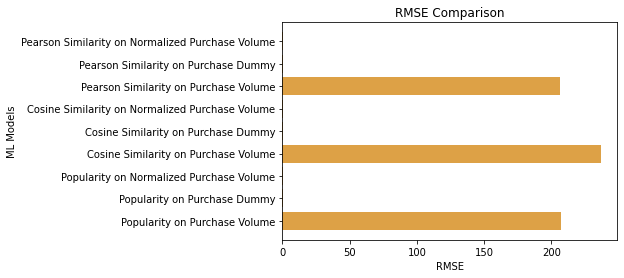

In [60]:
# Plot with no adjustment on axis scale
x = [popularity_rmse, pop_dummy_rmse, pop_norm_rmse, \
     cos_rmse, cos_dummy_rmse, cos_norm_rmse, \
     pear_rmse, pear_dummy_rmse, pear_norm_rmse]
y = ['Popularity on Purchase Volume', 'Popularity on Purchase Dummy', \
     'Popularity on Normalized Purchase Volume', 'Cosine Similarity on Purchase Volume', \
     'Cosine Similarity on Purchase Dummy', 'Cosine Similarity on Normalized Purchase Volume', \
     'Pearson Similarity on Purchase Volume', 'Pearson Similarity on Purchase Dummy', \
     'Pearson Similarity on Normalized Purchase Volume']

fig, ax = plt.subplots()
plt.barh(y, x, color='#dda146')
plt.ylabel('ML Models')
plt.xlabel('RMSE')
plt.title('RMSE Comparison')
plt.show()

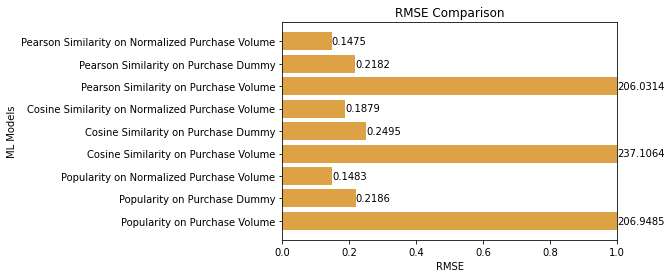

In [61]:
# Plot with adjusted on axis scale
x = [popularity_rmse, pop_dummy_rmse, pop_norm_rmse, \
     cos_rmse, cos_dummy_rmse, cos_norm_rmse, \
     pear_rmse, pear_dummy_rmse, pear_norm_rmse]
y = ['Popularity on Purchase Volume', 'Popularity on Purchase Dummy', \
     'Popularity on Normalized Purchase Volume', 'Cosine Similarity on Purchase Volume', \
     'Cosine Similarity on Purchase Dummy', 'Cosine Similarity on Normalized Purchase Volume', \
     'Pearson Similarity on Purchase Volume', 'Pearson Similarity on Purchase Dummy', \
     'Pearson Similarity on Normalized Purchase Volume']

fig, ax = plt.subplots()
plt.barh(y, x, color='#dda146')
plt.ylabel('ML Models')
plt.xlabel('RMSE')
plt.xlim(0, 1)
for i, v in enumerate(x):
  ax.text(min([v,1]), i, str(round(v,4)), va='center')
plt.title('RMSE Comparison')
plt.show()

**Precision-Recall**

In [62]:
# Get overall Precision-Recall values for each model
popularity_pc_sf = popularity.evaluate_precision_recall(test_data, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
pop_dummy_pc_sf = pop_dummy.evaluate_precision_recall(test_data_dummy, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
pop_norm_pc_sf = pop_norm.evaluate_precision_recall(test_data_norm, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
cos_pc_sf = cos.evaluate_precision_recall(test_data, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
cos_dummy_pc_sf = cos_dummy.evaluate_precision_recall(test_data_dummy, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
cos_norm_pc_sf = cos_norm.evaluate_precision_recall(test_data_norm, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
pear_pc_sf = pear.evaluate_precision_recall(test_data, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
pear_dummy_pc_sf = pear_dummy.evaluate_precision_recall(test_data_dummy, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
pear_norm_pc_sf = pear_norm.evaluate_precision_recall(test_data_norm, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']

recommendations finished on 1000/1835 queries. users per second: 9529.16

recommendations finished on 1000/1841 queries. users per second: 2562.54

recommendations finished on 1000/1833 queries. users per second: 9740.89

recommendations finished on 1000/1835 queries. users per second: 5303.91

recommendations finished on 1000/1841 queries. users per second: 529.642

recommendations finished on 1000/1833 queries. users per second: 4958.72

recommendations finished on 1000/1835 queries. users per second: 4753.51

recommendations finished on 1000/1841 queries. users per second: 499.65

recommendations finished on 1000/1833 queries. users per second: 4602.97

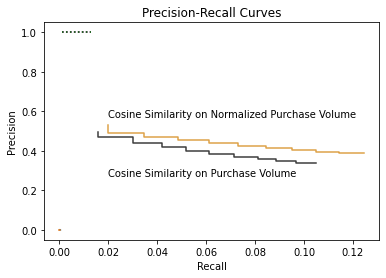

In [63]:
# Plot Precision-Recall Curve
fig, ax = plt.subplots()
ax.plot(list(popularity_pc_sf['recall']), list(popularity_pc_sf['precision']))
ax.step(list(pop_dummy_pc_sf['recall']), list(pop_dummy_pc_sf['precision']), ':k')
ax.step(list(pop_norm_pc_sf['recall']), list(pop_norm_pc_sf['precision']), ':y')
ax.step(list(cos_pc_sf['recall']), list(cos_pc_sf['precision']), color='#3A3A3A')
ax.step(list(cos_dummy_pc_sf['recall']), list(cos_dummy_pc_sf['precision']), ':m')
ax.step(list(cos_norm_pc_sf['recall']), list(cos_norm_pc_sf['precision']), color='#dda146')
ax.step(list(pear_pc_sf['recall']), list(pear_pc_sf['precision']))
ax.step(list(pear_dummy_pc_sf['recall']), list(pear_dummy_pc_sf['precision']), ':g')
ax.step(list(pear_norm_pc_sf['recall']), list(pear_norm_pc_sf['precision']))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.text(0.02, 0.57, 'Cosine Similarity on Normalized Purchase Volume')
plt.text(0.02, 0.27, 'Cosine Similarity on Purchase Volume')
plt.title('Precision-Recall Curves')
plt.show()

## Evaluation Summary

We select the ML model using **Cosine Similarity on Normalized Purchase Volume** approach as our final model for further tuning based on the following justifications:

1. Collaborative Filtering algorithms enable personalizations rather than providing the most popular items across all users (refer back to note on Baseline Summary).

2. This model has the highest precision and recall stats.

3. While the RMSE for this model is not the lowest at 0.19, we find that this is acceptable. The model with the lowest RMSE at 0.15 has significantly lower precision and recall and, and therefore is not a worthwhile trade-off. There is greater weight for a product recommender to have high precision and recall.

In [64]:
# Show the number of items observed for each user
cos_norm.get_num_items_per_user().sort('num_items', ascending = False)

CustomerID,num_items
2614,1388
4129,1327
2190,1317
2515,1199
2572,1181
2538,1173
2670,1171
4988,1142
2648,1120
5444,1100


In [65]:
# Show the number of users observed for each item
cos_norm.get_num_users_per_item().sort('num_users', ascending = False)

StockCode,num_users
11788,1298
26826,1232
38176,1225
36308,1184
11296,1176
10807,1161
11776,1123
19066,1112
42716,1107
64858,1102


In [66]:
# Get the 10 most similar items for each item in items (item-based collaborative filtering)
cos_norm.get_similar_items().print_rows(num_rows=20)

+-----------+---------+--------------------+------+
| StockCode | similar |       score        | rank |
+-----------+---------+--------------------+------+
|   34423   |  48099  | 0.5582977533340454 |  1   |
|   34423   |  66293  | 0.5407740473747253 |  2   |
|   34423   |  48105  | 0.5383647084236145 |  3   |
|   34423   |  10805  | 0.5329257845878601 |  4   |
|   34423   |  11294  | 0.5221921801567078 |  5   |
|   34423   |  36967  | 0.5170900225639343 |  6   |
|   34423   |  10804  | 0.5159453749656677 |  7   |
|   34423   |  88290  | 0.5127319693565369 |  8   |
|   34423   |  38174  | 0.5100008845329285 |  9   |
|   34423   |  87403  | 0.5093187689781189 |  10  |
|   37997   |  11297  | 0.7934050559997559 |  1   |
|   37997   |  89197  | 0.7780570983886719 |  2   |
|   37997   |  10808  | 0.7768657207489014 |  3   |
|   37997   |  28233  | 0.7719686031341553 |  4   |
|   37997   |  26827  | 0.7645321488380432 |  5   |
|   37997   |  19067  | 0.7614699006080627 |  6   |
|   37997   

# **Incorporating Pre-Defined Similar Items to our Chosen Model**

Based on our evaluation, we use our chosen model to provide nearest neighbors graph using the keyword argument nearest_items.

Using the function get_similar_items, we save an SFrame with a list of items, the nearest items for each item listed and the similarity score between them.

These similarity scores are then passed as a parameter in a new model to be used for recommendations.

In [67]:
name = 'cosine' 
target = 'scaled_purchase_freq' 

nn = cos_norm.get_similar_items()
m2 = tc.item_similarity_recommender.create(train_data_norm, user_id=user_id, item_id=item_id, 
                                           target=target, similarity_type=name, 
                                           nearest_items=nn)

Preparing data set.

Data has 354720 observations with 1839 users and 3035 items.

Data prepared in: 0.741998s

Loading user-provided nearest items.

Generating candidate set for working with new users.

Finished training in 0.042924s

In [68]:
# Evaluate the new model
m2.evaluate(test_data_norm)

recommendations finished on 1000/1833 queries. users per second: 6482.56


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.5722858701582109 | 0.022273264691068953 |
|   2    |  0.5201854882705942 | 0.036881865341694464 |
|   3    |  0.4815420985633752 | 0.04969309885075134  |
|   4    | 0.45349154391707586 | 0.061975618687961226 |
|   5    |  0.4292416803055101 | 0.07238416970054937  |
|   6    |  0.4081651209310782 | 0.08195123176564234  |
|   7    |  0.3915517107006469 | 0.09048899756714811  |
|   8    |  0.3775231860338244 | 0.09923112956590477  |
|   9    |  0.367460750439474  | 0.10760501123710907  |
|   10   |  0.3555373704309871 | 0.11450566236333622  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.19001128825873195

Per User RMSE (best)
+------------+-----------------------+-------+
| CustomerID |          rmse         |

{'precision_recall_by_user': Columns:
 	CustomerID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 32994
 
 Data:
 +------------+--------+--------------------+----------------------+-------+
 | CustomerID | cutoff |     precision      |        recall        | count |
 +------------+--------+--------------------+----------------------+-------+
 |    2641    |   1    |        0.0         |         0.0          |  111  |
 |    2641    |   2    |        0.0         |         0.0          |  111  |
 |    2641    |   3    | 0.3333333333333333 | 0.009009009009009009 |  111  |
 |    2641    |   4    |        0.25        | 0.009009009009009009 |  111  |
 |    2641    |   5    |        0.4         | 0.018018018018018018 |  111  |
 |    2641    |   6    | 0.3333333333333333 | 0.018018018018018018 |  111  |
 |    2641    |   7    | 0.2857142857142857 | 0.018018018018018018 |  111  |
 |    2641    |   8    |        0.25        | 0.018018018018018018 |  111  |
 |    2641    | 

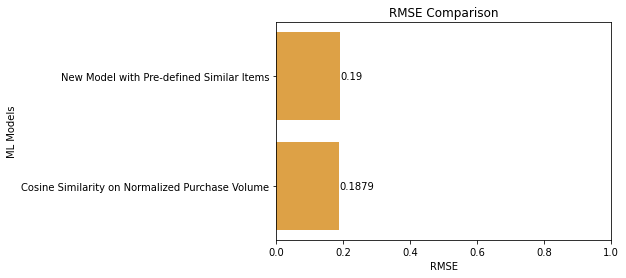

In [69]:
# Compare the 2 models (new model and chosen model) - RMSE
m2_rmse = m2.evaluate_rmse(test_data_norm, 'scaled_purchase_freq')['rmse_overall']

# Plot with adjusted on axis scale
x = [cos_norm_rmse, m2_rmse]
y = ['Cosine Similarity on Normalized Purchase Volume', \
     'New Model with Pre-defined Similar Items']

fig, ax = plt.subplots()
plt.barh(y, x, color='#dda146')
plt.ylabel('ML Models')
plt.xlabel('RMSE')
plt.xlim(0, 1)
for i, v in enumerate(x):
  ax.text(min([v,1]), i, str(round(v,4)), va='center')
plt.title('RMSE Comparison')
plt.show()

recommendations finished on 1000/1833 queries. users per second: 8428.36

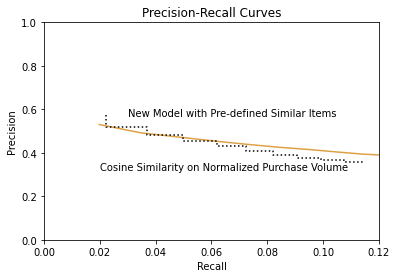

In [70]:
# Compare the 2 models (new model and chosen model) - Precision-Recall
m2_pc_sf = m2.evaluate_precision_recall(test_data_norm, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']

fig, ax = plt.subplots()
ax.plot(list(cos_norm_pc_sf['recall']), list(cos_norm_pc_sf['precision']), color='#dda146')
ax.step(list(m2_pc_sf['recall']), list(m2_pc_sf['precision']), ':k')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.text(0.03, 0.57, 'New Model with Pre-defined Similar Items')
plt.text(0.02, 0.32, 'Cosine Similarity on Normalized Purchase Volume')
plt.title('Precision-Recall Curves')
plt.xlim(0,0.12)
plt.ylim(0,1)
plt.show()

**Evaluation Summary**

We have decided to select the new model as the final model for our product recommender for the following reasons:
Given that the model accuracy is comparable

1.   Marginally higher Precision-Recall 
2.   Model accuracy is comparable 



In [71]:
# Input: Customer ID
m2.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1839 queries. users per second: 16411.2

+------------+-----------+-----------------------+------+
| CustomerID | StockCode |         score         | rank |
+------------+-----------+-----------------------+------+
|    2641    |   58838   |  0.005077296712413845 |  1   |
|    2641    |   10805   |  0.004384768596297924 |  2   |
|    2641    |   64864   |  0.004036876450769396 |  3   |
|    2641    |   58868   |  0.003674262596146708 |  4   |
|    2641    |   27783   |  0.003554169830469299 |  5   |
|    2641    |   10804   | 0.0032506218814237213 |  6   |
|    2641    |   72911   |  0.002800383966025244 |  7   |
|    2641    |   87408   |  0.002750714024333423 |  8   |
|    2641    |   28866   |  0.002256201855375629 |  9   |
|    2641    |   28236   |  0.002213273747830115 |  10  |
|    2595    |   72911   |  0.003412053307093227 |  1   |
|    2595    |   58868   | 0.0029016796786992616 |  2   |
|    2595    |   67526   | 0.0024097845667884464 |  3   |
|    2595    |   11296   |  0.002085747879322722 |  4   |
|    2595    |

In [72]:
# Input: StockCode
m2.recommend_from_interactions(test_items, k=10)

StockCode,score,rank
944650,0.4698757827281952,1
989289,0.46865880489349365,2
930746,0.4676094949245453,3
989291,0.4658859074115753,4
4000,0.4631192088127136,5
18348,0.4553278982639313,6
5349,0.4485301673412323,7
15628,0.4375404417514801,8
989287,0.43116676807403564,9
989292,0.43116676807403564,10


# **Final Output**

**Collaborative Filtering**

In [73]:
# Rerun the model using the whole dataset, as we came to a final model using train data and evaluated with test set
final_model = tc.item_similarity_recommender.create(tc.SFrame(norm_data), 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target='scaled_purchase_freq', 
                                            similarity_type='cosine',
                                            nearest_items=nn)
recom = final_model.recommend(users=users_to_recommend, k=n_rec)
recom.print_rows(n_display)

Preparing data set.

Data has 443400 observations with 1840 users and 3044 items.

Data prepared in: 0.782451s

Loading user-provided nearest items.

Generating candidate set for working with new users.

Finished training in 0.04774s

recommendations finished on 1000/446139 queries. users per second: 8450.09

recommendations finished on 2000/446139 queries. users per second: 8038.46

recommendations finished on 3000/446139 queries. users per second: 8259.28

recommendations finished on 4000/446139 queries. users per second: 8312.05

recommendations finished on 5000/446139 queries. users per second: 8303.51

recommendations finished on 6000/446139 queries. users per second: 8258.66

recommendations finished on 7000/446139 queries. users per second: 8267.37

recommendations finished on 8000/446139 queries. users per second: 8122.06

recommendations finished on 9000/446139 queries. users per second: 8128.8

recommendations finished on 10000/446139 queries. users per second: 8195.53

recommendations finished on 11000/446139 queries. users per second: 8177.9

recommendations finished on 12000/446139 queries. users per second: 8029.55

recommendations finished on 13000/446139 queries. users per second: 8117.46

recommendations finished on 14000/446139 queries. users per second: 8112.34

recommendations finished on 15000/446139 queries. users per second: 8114.43

recommendations finished on 16000/446139 queries. users per second: 8049.89

recommendations finished on 17000/446139 queries. users per second: 8087.84

recommendations finished on 18000/446139 queries. users per second: 8140.5

recommendations finished on 19000/446139 queries. users per second: 8127.82

recommendations finished on 20000/446139 queries. users per second: 8149.04

recommendations finished on 21000/446139 queries. users per second: 8173.85

recommendations finished on 22000/446139 queries. users per second: 8153.49

recommendations finished on 23000/446139 queries. users per second: 8203.12

recommendations finished on 24000/446139 queries. users per second: 8221.68

recommendations finished on 25000/446139 queries. users per second: 8218.28

recommendations finished on 26000/446139 queries. users per second: 8237.46

recommendations finished on 27000/446139 queries. users per second: 8178.94

recommendations finished on 28000/446139 queries. users per second: 8223.04

recommendations finished on 29000/446139 queries. users per second: 8273.71

recommendations finished on 30000/446139 queries. users per second: 8303.11

recommendations finished on 31000/446139 queries. users per second: 8329.63

recommendations finished on 32000/446139 queries. users per second: 8357.46

recommendations finished on 33000/446139 queries. users per second: 8420.7

recommendations finished on 34000/446139 queries. users per second: 8406.48

recommendations finished on 35000/446139 queries. users per second: 8425.32

recommendations finished on 36000/446139 queries. users per second: 8462.51

recommendations finished on 37000/446139 queries. users per second: 8479.57

recommendations finished on 38000/446139 queries. users per second: 8505.75

recommendations finished on 39000/446139 queries. users per second: 8532.39

recommendations finished on 40000/446139 queries. users per second: 8560.08

recommendations finished on 41000/446139 queries. users per second: 8593.7

recommendations finished on 42000/446139 queries. users per second: 8608.79

recommendations finished on 43000/446139 queries. users per second: 8640.11

recommendations finished on 44000/446139 queries. users per second: 8675.79

recommendations finished on 45000/446139 queries. users per second: 8697.91

recommendations finished on 46000/446139 queries. users per second: 8700.12

recommendations finished on 47000/446139 queries. users per second: 8698.65

recommendations finished on 48000/446139 queries. users per second: 8739.63

recommendations finished on 49000/446139 queries. users per second: 8728.67

recommendations finished on 50000/446139 queries. users per second: 8743.55

recommendations finished on 51000/446139 queries. users per second: 8750.07

recommendations finished on 52000/446139 queries. users per second: 8752.42

recommendations finished on 53000/446139 queries. users per second: 8734.19

recommendations finished on 54000/446139 queries. users per second: 8707.49

recommendations finished on 55000/446139 queries. users per second: 8705.6

recommendations finished on 56000/446139 queries. users per second: 8688.73

recommendations finished on 57000/446139 queries. users per second: 8688.8

recommendations finished on 58000/446139 queries. users per second: 8684.53

recommendations finished on 59000/446139 queries. users per second: 8642.85

recommendations finished on 60000/446139 queries. users per second: 8599.48

recommendations finished on 61000/446139 queries. users per second: 8551.21

recommendations finished on 62000/446139 queries. users per second: 8515.56

recommendations finished on 63000/446139 queries. users per second: 8454.25

recommendations finished on 64000/446139 queries. users per second: 8418.84

recommendations finished on 65000/446139 queries. users per second: 8373.76

recommendations finished on 66000/446139 queries. users per second: 8337.68

recommendations finished on 67000/446139 queries. users per second: 8289.98

recommendations finished on 68000/446139 queries. users per second: 8254.53

recommendations finished on 69000/446139 queries. users per second: 8230.1

recommendations finished on 70000/446139 queries. users per second: 8190.91

recommendations finished on 71000/446139 queries. users per second: 8165.37

recommendations finished on 72000/446139 queries. users per second: 8137.27

recommendations finished on 73000/446139 queries. users per second: 8121.89

recommendations finished on 74000/446139 queries. users per second: 8096.89

recommendations finished on 75000/446139 queries. users per second: 8070

recommendations finished on 76000/446139 queries. users per second: 8036.32

recommendations finished on 77000/446139 queries. users per second: 8016.2

recommendations finished on 78000/446139 queries. users per second: 7990.5

recommendations finished on 79000/446139 queries. users per second: 7960.92

recommendations finished on 80000/446139 queries. users per second: 7941.14

recommendations finished on 81000/446139 queries. users per second: 7929.4

recommendations finished on 82000/446139 queries. users per second: 7908.32

recommendations finished on 83000/446139 queries. users per second: 7876.86

recommendations finished on 84000/446139 queries. users per second: 7861.26

recommendations finished on 85000/446139 queries. users per second: 7835.62

recommendations finished on 86000/446139 queries. users per second: 7820.69

recommendations finished on 87000/446139 queries. users per second: 7798.89

recommendations finished on 88000/446139 queries. users per second: 7777.76

recommendations finished on 89000/446139 queries. users per second: 7742.78

recommendations finished on 90000/446139 queries. users per second: 7720.7

recommendations finished on 91000/446139 queries. users per second: 7693.44

recommendations finished on 92000/446139 queries. users per second: 7686.71

recommendations finished on 93000/446139 queries. users per second: 7675.86

recommendations finished on 94000/446139 queries. users per second: 7666.5

recommendations finished on 95000/446139 queries. users per second: 7651.84

recommendations finished on 96000/446139 queries. users per second: 7632.21

recommendations finished on 97000/446139 queries. users per second: 7624.98

recommendations finished on 98000/446139 queries. users per second: 7614.85

recommendations finished on 99000/446139 queries. users per second: 7605.56

recommendations finished on 100000/446139 queries. users per second: 7593.14

recommendations finished on 101000/446139 queries. users per second: 7573.83

recommendations finished on 102000/446139 queries. users per second: 7558.57

recommendations finished on 103000/446139 queries. users per second: 7540.24

recommendations finished on 104000/446139 queries. users per second: 7529.79

recommendations finished on 105000/446139 queries. users per second: 7520.7

recommendations finished on 106000/446139 queries. users per second: 7507.98

recommendations finished on 107000/446139 queries. users per second: 7495.72

recommendations finished on 108000/446139 queries. users per second: 7490.2

recommendations finished on 109000/446139 queries. users per second: 7482.23

recommendations finished on 110000/446139 queries. users per second: 7469.03

recommendations finished on 111000/446139 queries. users per second: 7465.48

recommendations finished on 112000/446139 queries. users per second: 7460.35

recommendations finished on 113000/446139 queries. users per second: 7448.06

recommendations finished on 114000/446139 queries. users per second: 7449.09

recommendations finished on 115000/446139 queries. users per second: 7444.08

recommendations finished on 116000/446139 queries. users per second: 7438.73

recommendations finished on 117000/446139 queries. users per second: 7429.23

recommendations finished on 118000/446139 queries. users per second: 7420.04

recommendations finished on 119000/446139 queries. users per second: 7412.24

recommendations finished on 120000/446139 queries. users per second: 7404.18

recommendations finished on 121000/446139 queries. users per second: 7398.76

recommendations finished on 122000/446139 queries. users per second: 7393.55

recommendations finished on 123000/446139 queries. users per second: 7393.29

recommendations finished on 124000/446139 queries. users per second: 7396.02

recommendations finished on 125000/446139 queries. users per second: 7403.52

recommendations finished on 126000/446139 queries. users per second: 7413

recommendations finished on 127000/446139 queries. users per second: 7419.51

recommendations finished on 128000/446139 queries. users per second: 7428.06

recommendations finished on 129000/446139 queries. users per second: 7433.65

recommendations finished on 130000/446139 queries. users per second: 7441.45

recommendations finished on 131000/446139 queries. users per second: 7444.05

recommendations finished on 132000/446139 queries. users per second: 7450.31

recommendations finished on 133000/446139 queries. users per second: 7453.64

recommendations finished on 134000/446139 queries. users per second: 7455.6

recommendations finished on 135000/446139 queries. users per second: 7457.96

recommendations finished on 136000/446139 queries. users per second: 7460

recommendations finished on 137000/446139 queries. users per second: 7461.98

recommendations finished on 138000/446139 queries. users per second: 7471.88

recommendations finished on 139000/446139 queries. users per second: 7476.34

recommendations finished on 140000/446139 queries. users per second: 7482.69

recommendations finished on 141000/446139 queries. users per second: 7492.74

recommendations finished on 142000/446139 queries. users per second: 7503.01

recommendations finished on 143000/446139 queries. users per second: 7514.64

recommendations finished on 144000/446139 queries. users per second: 7523.65

recommendations finished on 145000/446139 queries. users per second: 7540.91

recommendations finished on 146000/446139 queries. users per second: 7554.87

recommendations finished on 147000/446139 queries. users per second: 7567.91

recommendations finished on 148000/446139 queries. users per second: 7569.89

recommendations finished on 149000/446139 queries. users per second: 7565.58

recommendations finished on 150000/446139 queries. users per second: 7569.77

recommendations finished on 151000/446139 queries. users per second: 7570.29

recommendations finished on 152000/446139 queries. users per second: 7561.56

recommendations finished on 153000/446139 queries. users per second: 7562.2

recommendations finished on 154000/446139 queries. users per second: 7565.48

recommendations finished on 155000/446139 queries. users per second: 7556.05

recommendations finished on 156000/446139 queries. users per second: 7559.49

recommendations finished on 157000/446139 queries. users per second: 7570.71

recommendations finished on 158000/446139 queries. users per second: 7574.55

recommendations finished on 159000/446139 queries. users per second: 7581.31

recommendations finished on 160000/446139 queries. users per second: 7587.06

recommendations finished on 161000/446139 queries. users per second: 7583.4

recommendations finished on 162000/446139 queries. users per second: 7589.06

recommendations finished on 163000/446139 queries. users per second: 7596.01

recommendations finished on 164000/446139 queries. users per second: 7583.92

recommendations finished on 165000/446139 queries. users per second: 7571.36

recommendations finished on 166000/446139 queries. users per second: 7561.47

recommendations finished on 167000/446139 queries. users per second: 7555.99

recommendations finished on 168000/446139 queries. users per second: 7552.36

recommendations finished on 169000/446139 queries. users per second: 7548.63

recommendations finished on 170000/446139 queries. users per second: 7545.63

recommendations finished on 171000/446139 queries. users per second: 7539.44

recommendations finished on 172000/446139 queries. users per second: 7534.22

recommendations finished on 173000/446139 queries. users per second: 7535.03

recommendations finished on 174000/446139 queries. users per second: 7533.02

recommendations finished on 175000/446139 queries. users per second: 7535.44

recommendations finished on 176000/446139 queries. users per second: 7538.31

recommendations finished on 177000/446139 queries. users per second: 7539.4

recommendations finished on 178000/446139 queries. users per second: 7543.03

recommendations finished on 179000/446139 queries. users per second: 7545.44

recommendations finished on 180000/446139 queries. users per second: 7539.29

recommendations finished on 181000/446139 queries. users per second: 7534.11

recommendations finished on 182000/446139 queries. users per second: 7534.04

recommendations finished on 183000/446139 queries. users per second: 7532.62

recommendations finished on 184000/446139 queries. users per second: 7531.36

recommendations finished on 185000/446139 queries. users per second: 7523.38

recommendations finished on 186000/446139 queries. users per second: 7517

recommendations finished on 187000/446139 queries. users per second: 7505.42

recommendations finished on 188000/446139 queries. users per second: 7505.91

recommendations finished on 189000/446139 queries. users per second: 7508.16

recommendations finished on 190000/446139 queries. users per second: 7511.16

recommendations finished on 191000/446139 queries. users per second: 7512.9

recommendations finished on 192000/446139 queries. users per second: 7518.54

recommendations finished on 193000/446139 queries. users per second: 7519.07

recommendations finished on 194000/446139 queries. users per second: 7523.29

recommendations finished on 195000/446139 queries. users per second: 7523.05

recommendations finished on 196000/446139 queries. users per second: 7525.11

recommendations finished on 197000/446139 queries. users per second: 7527.9

recommendations finished on 198000/446139 queries. users per second: 7529.48

recommendations finished on 199000/446139 queries. users per second: 7531.21

recommendations finished on 200000/446139 queries. users per second: 7529.88

recommendations finished on 201000/446139 queries. users per second: 7532.21

recommendations finished on 202000/446139 queries. users per second: 7535.78

recommendations finished on 203000/446139 queries. users per second: 7532.37

recommendations finished on 204000/446139 queries. users per second: 7532.46

recommendations finished on 205000/446139 queries. users per second: 7531.9

recommendations finished on 206000/446139 queries. users per second: 7530.03

recommendations finished on 207000/446139 queries. users per second: 7528.82

recommendations finished on 208000/446139 queries. users per second: 7529.07

recommendations finished on 209000/446139 queries. users per second: 7533.04

recommendations finished on 210000/446139 queries. users per second: 7529.56

recommendations finished on 211000/446139 queries. users per second: 7524.11

recommendations finished on 212000/446139 queries. users per second: 7523.05

recommendations finished on 213000/446139 queries. users per second: 7521.62

recommendations finished on 214000/446139 queries. users per second: 7521.5

recommendations finished on 215000/446139 queries. users per second: 7520.01

recommendations finished on 216000/446139 queries. users per second: 7520.4

recommendations finished on 217000/446139 queries. users per second: 7524.84

recommendations finished on 218000/446139 queries. users per second: 7528.55

recommendations finished on 219000/446139 queries. users per second: 7535.03

recommendations finished on 220000/446139 queries. users per second: 7539.5

recommendations finished on 221000/446139 queries. users per second: 7543.75

recommendations finished on 222000/446139 queries. users per second: 7547.46

recommendations finished on 223000/446139 queries. users per second: 7552.08

recommendations finished on 224000/446139 queries. users per second: 7551.82

recommendations finished on 225000/446139 queries. users per second: 7551.88

recommendations finished on 226000/446139 queries. users per second: 7553.68

recommendations finished on 227000/446139 queries. users per second: 7554.5

recommendations finished on 228000/446139 queries. users per second: 7553.4

recommendations finished on 229000/446139 queries. users per second: 7551.31

recommendations finished on 230000/446139 queries. users per second: 7554.21

recommendations finished on 231000/446139 queries. users per second: 7556.64

recommendations finished on 232000/446139 queries. users per second: 7560.85

recommendations finished on 233000/446139 queries. users per second: 7561.24

recommendations finished on 234000/446139 queries. users per second: 7564.69

recommendations finished on 235000/446139 queries. users per second: 7566.74

recommendations finished on 236000/446139 queries. users per second: 7569.31

recommendations finished on 237000/446139 queries. users per second: 7570.33

recommendations finished on 238000/446139 queries. users per second: 7573.25

recommendations finished on 239000/446139 queries. users per second: 7577.48

recommendations finished on 240000/446139 queries. users per second: 7580.53

recommendations finished on 241000/446139 queries. users per second: 7586.75

recommendations finished on 242000/446139 queries. users per second: 7588.01

recommendations finished on 243000/446139 queries. users per second: 7588.6

recommendations finished on 244000/446139 queries. users per second: 7587.11

recommendations finished on 245000/446139 queries. users per second: 7586.64

recommendations finished on 246000/446139 queries. users per second: 7579.81

recommendations finished on 247000/446139 queries. users per second: 7571.82

recommendations finished on 248000/446139 queries. users per second: 7566.78

recommendations finished on 249000/446139 queries. users per second: 7562.42

recommendations finished on 250000/446139 queries. users per second: 7556.83

recommendations finished on 251000/446139 queries. users per second: 7553.91

recommendations finished on 252000/446139 queries. users per second: 7550.2

recommendations finished on 253000/446139 queries. users per second: 7546.23

recommendations finished on 254000/446139 queries. users per second: 7543.57

recommendations finished on 255000/446139 queries. users per second: 7539.45

recommendations finished on 256000/446139 queries. users per second: 7538.11

recommendations finished on 257000/446139 queries. users per second: 7535.72

recommendations finished on 258000/446139 queries. users per second: 7533.31

recommendations finished on 259000/446139 queries. users per second: 7529.84

recommendations finished on 260000/446139 queries. users per second: 7527.03

recommendations finished on 261000/446139 queries. users per second: 7527.06

recommendations finished on 262000/446139 queries. users per second: 7528.38

recommendations finished on 263000/446139 queries. users per second: 7532.52

recommendations finished on 264000/446139 queries. users per second: 7534.65

recommendations finished on 265000/446139 queries. users per second: 7536.35

recommendations finished on 266000/446139 queries. users per second: 7540.16

recommendations finished on 267000/446139 queries. users per second: 7543.71

recommendations finished on 268000/446139 queries. users per second: 7544.5

recommendations finished on 269000/446139 queries. users per second: 7548.56

recommendations finished on 270000/446139 queries. users per second: 7550.15

recommendations finished on 271000/446139 queries. users per second: 7554.21

recommendations finished on 272000/446139 queries. users per second: 7559.08

recommendations finished on 273000/446139 queries. users per second: 7564.66

recommendations finished on 274000/446139 queries. users per second: 7564.11

recommendations finished on 275000/446139 queries. users per second: 7568.39

recommendations finished on 276000/446139 queries. users per second: 7572.22

recommendations finished on 277000/446139 queries. users per second: 7575.13

recommendations finished on 278000/446139 queries. users per second: 7575.66

recommendations finished on 279000/446139 queries. users per second: 7578.06

recommendations finished on 280000/446139 queries. users per second: 7579.86

recommendations finished on 281000/446139 queries. users per second: 7578.98

recommendations finished on 282000/446139 queries. users per second: 7579.05

recommendations finished on 283000/446139 queries. users per second: 7578.88

recommendations finished on 284000/446139 queries. users per second: 7577.79

recommendations finished on 285000/446139 queries. users per second: 7574.46

recommendations finished on 286000/446139 queries. users per second: 7575.46

recommendations finished on 287000/446139 queries. users per second: 7576.28

recommendations finished on 288000/446139 queries. users per second: 7575.73

recommendations finished on 289000/446139 queries. users per second: 7575.73

recommendations finished on 290000/446139 queries. users per second: 7573.04

recommendations finished on 291000/446139 queries. users per second: 7572.69

recommendations finished on 292000/446139 queries. users per second: 7573.52

recommendations finished on 293000/446139 queries. users per second: 7568.4

recommendations finished on 294000/446139 queries. users per second: 7563.66

recommendations finished on 295000/446139 queries. users per second: 7558.23

recommendations finished on 296000/446139 queries. users per second: 7554.47

recommendations finished on 297000/446139 queries. users per second: 7549.93

recommendations finished on 298000/446139 queries. users per second: 7548.08

recommendations finished on 299000/446139 queries. users per second: 7545.22

recommendations finished on 300000/446139 queries. users per second: 7541.61

recommendations finished on 301000/446139 queries. users per second: 7536.37

recommendations finished on 302000/446139 queries. users per second: 7532.46

recommendations finished on 303000/446139 queries. users per second: 7526.78

recommendations finished on 304000/446139 queries. users per second: 7522.72

recommendations finished on 305000/446139 queries. users per second: 7516.69

recommendations finished on 306000/446139 queries. users per second: 7513.63

recommendations finished on 307000/446139 queries. users per second: 7510.33

recommendations finished on 308000/446139 queries. users per second: 7507.29

recommendations finished on 309000/446139 queries. users per second: 7503.76

recommendations finished on 310000/446139 queries. users per second: 7499.58

recommendations finished on 311000/446139 queries. users per second: 7496.47

recommendations finished on 312000/446139 queries. users per second: 7491.64

recommendations finished on 313000/446139 queries. users per second: 7489.17

recommendations finished on 314000/446139 queries. users per second: 7486.94

recommendations finished on 315000/446139 queries. users per second: 7486.41

recommendations finished on 316000/446139 queries. users per second: 7484.92

recommendations finished on 317000/446139 queries. users per second: 7485.02

recommendations finished on 318000/446139 queries. users per second: 7482.87

recommendations finished on 319000/446139 queries. users per second: 7478.99

recommendations finished on 320000/446139 queries. users per second: 7473.68

recommendations finished on 321000/446139 queries. users per second: 7470.91

recommendations finished on 322000/446139 queries. users per second: 7468.77

recommendations finished on 323000/446139 queries. users per second: 7465.44

recommendations finished on 324000/446139 queries. users per second: 7460.69

recommendations finished on 325000/446139 queries. users per second: 7457.54

recommendations finished on 326000/446139 queries. users per second: 7458.42

recommendations finished on 327000/446139 queries. users per second: 7457.14

recommendations finished on 328000/446139 queries. users per second: 7457.77

recommendations finished on 329000/446139 queries. users per second: 7459.62

recommendations finished on 330000/446139 queries. users per second: 7461.7

recommendations finished on 331000/446139 queries. users per second: 7460.04

recommendations finished on 332000/446139 queries. users per second: 7461.58

recommendations finished on 333000/446139 queries. users per second: 7461.25

recommendations finished on 334000/446139 queries. users per second: 7461.26

recommendations finished on 335000/446139 queries. users per second: 7458.31

recommendations finished on 336000/446139 queries. users per second: 7461.46

recommendations finished on 337000/446139 queries. users per second: 7465.08

recommendations finished on 338000/446139 queries. users per second: 7466.65

recommendations finished on 339000/446139 queries. users per second: 7467.14

recommendations finished on 340000/446139 queries. users per second: 7466.86

recommendations finished on 341000/446139 queries. users per second: 7467.14

recommendations finished on 342000/446139 queries. users per second: 7465.16

recommendations finished on 343000/446139 queries. users per second: 7466.68

recommendations finished on 344000/446139 queries. users per second: 7466.05

recommendations finished on 345000/446139 queries. users per second: 7467.92

recommendations finished on 346000/446139 queries. users per second: 7469.41

recommendations finished on 347000/446139 queries. users per second: 7471.39

recommendations finished on 348000/446139 queries. users per second: 7476.08

recommendations finished on 349000/446139 queries. users per second: 7482.38

recommendations finished on 350000/446139 queries. users per second: 7485.81

recommendations finished on 351000/446139 queries. users per second: 7491.12

recommendations finished on 352000/446139 queries. users per second: 7497.64

recommendations finished on 353000/446139 queries. users per second: 7503.67

recommendations finished on 354000/446139 queries. users per second: 7507.37

recommendations finished on 355000/446139 queries. users per second: 7510.03

recommendations finished on 356000/446139 queries. users per second: 7513.15

recommendations finished on 357000/446139 queries. users per second: 7515.92

recommendations finished on 358000/446139 queries. users per second: 7517.3

recommendations finished on 359000/446139 queries. users per second: 7518.99

recommendations finished on 360000/446139 queries. users per second: 7520.44

recommendations finished on 361000/446139 queries. users per second: 7520.67

recommendations finished on 362000/446139 queries. users per second: 7523.03

recommendations finished on 363000/446139 queries. users per second: 7525.08

recommendations finished on 364000/446139 queries. users per second: 7528.04

recommendations finished on 365000/446139 queries. users per second: 7528.57

recommendations finished on 366000/446139 queries. users per second: 7528.19

recommendations finished on 367000/446139 queries. users per second: 7530.19

recommendations finished on 368000/446139 queries. users per second: 7529.72

recommendations finished on 369000/446139 queries. users per second: 7529.41

recommendations finished on 370000/446139 queries. users per second: 7529.28

recommendations finished on 371000/446139 queries. users per second: 7526.24

recommendations finished on 372000/446139 queries. users per second: 7523.73

recommendations finished on 373000/446139 queries. users per second: 7519.25

recommendations finished on 374000/446139 queries. users per second: 7516.66

recommendations finished on 375000/446139 queries. users per second: 7512.73

recommendations finished on 376000/446139 queries. users per second: 7510.04

recommendations finished on 377000/446139 queries. users per second: 7508.17

recommendations finished on 378000/446139 queries. users per second: 7506.7

recommendations finished on 379000/446139 queries. users per second: 7502.86

recommendations finished on 380000/446139 queries. users per second: 7503.18

recommendations finished on 381000/446139 queries. users per second: 7500.81

recommendations finished on 382000/446139 queries. users per second: 7496.63

recommendations finished on 383000/446139 queries. users per second: 7494.69

recommendations finished on 384000/446139 queries. users per second: 7491.58

recommendations finished on 385000/446139 queries. users per second: 7489.13

recommendations finished on 386000/446139 queries. users per second: 7486.44

recommendations finished on 387000/446139 queries. users per second: 7483.7

recommendations finished on 388000/446139 queries. users per second: 7481.15

recommendations finished on 389000/446139 queries. users per second: 7480.8

recommendations finished on 390000/446139 queries. users per second: 7478.67

recommendations finished on 391000/446139 queries. users per second: 7476.87

recommendations finished on 392000/446139 queries. users per second: 7472.65

recommendations finished on 393000/446139 queries. users per second: 7469.11

recommendations finished on 394000/446139 queries. users per second: 7469.54

recommendations finished on 395000/446139 queries. users per second: 7469.25

recommendations finished on 396000/446139 queries. users per second: 7469.98

recommendations finished on 397000/446139 queries. users per second: 7469.51

recommendations finished on 398000/446139 queries. users per second: 7472.38

recommendations finished on 399000/446139 queries. users per second: 7474.66

recommendations finished on 400000/446139 queries. users per second: 7474.09

recommendations finished on 401000/446139 queries. users per second: 7473.37

recommendations finished on 402000/446139 queries. users per second: 7473.89

recommendations finished on 403000/446139 queries. users per second: 7475.27

recommendations finished on 404000/446139 queries. users per second: 7474.33

recommendations finished on 405000/446139 queries. users per second: 7473.85

recommendations finished on 406000/446139 queries. users per second: 7471.05

recommendations finished on 407000/446139 queries. users per second: 7464.6

recommendations finished on 408000/446139 queries. users per second: 7453.35

recommendations finished on 409000/446139 queries. users per second: 7444.15

recommendations finished on 410000/446139 queries. users per second: 7435.53

recommendations finished on 411000/446139 queries. users per second: 7430.11

recommendations finished on 412000/446139 queries. users per second: 7426.26

recommendations finished on 413000/446139 queries. users per second: 7421.95

recommendations finished on 414000/446139 queries. users per second: 7417.09

recommendations finished on 415000/446139 queries. users per second: 7409.87

recommendations finished on 416000/446139 queries. users per second: 7405.35

recommendations finished on 417000/446139 queries. users per second: 7399.93

recommendations finished on 418000/446139 queries. users per second: 7390.91

recommendations finished on 419000/446139 queries. users per second: 7382.78

recommendations finished on 420000/446139 queries. users per second: 7376.69

recommendations finished on 421000/446139 queries. users per second: 7370.2

recommendations finished on 422000/446139 queries. users per second: 7360.77

recommendations finished on 423000/446139 queries. users per second: 7359.82

recommendations finished on 424000/446139 queries. users per second: 7359.95

recommendations finished on 425000/446139 queries. users per second: 7359.8

recommendations finished on 426000/446139 queries. users per second: 7359.9

recommendations finished on 427000/446139 queries. users per second: 7359.06

recommendations finished on 428000/446139 queries. users per second: 7359.01

recommendations finished on 429000/446139 queries. users per second: 7360.44

recommendations finished on 430000/446139 queries. users per second: 7359.45

recommendations finished on 431000/446139 queries. users per second: 7357.86

recommendations finished on 432000/446139 queries. users per second: 7354.44

recommendations finished on 433000/446139 queries. users per second: 7352.93

recommendations finished on 434000/446139 queries. users per second: 7351.83

recommendations finished on 435000/446139 queries. users per second: 7349.22

recommendations finished on 436000/446139 queries. users per second: 7341.33

recommendations finished on 437000/446139 queries. users per second: 7331.47

recommendations finished on 438000/446139 queries. users per second: 7323.65

recommendations finished on 439000/446139 queries. users per second: 7318.63

recommendations finished on 440000/446139 queries. users per second: 7314.8

recommendations finished on 441000/446139 queries. users per second: 7310.82

recommendations finished on 442000/446139 queries. users per second: 7313.32

recommendations finished on 443000/446139 queries. users per second: 7316.15

recommendations finished on 444000/446139 queries. users per second: 7318.54

recommendations finished on 445000/446139 queries. users per second: 7314.11

recommendations finished on 446000/446139 queries. users per second: 7316.5

+------------+-----------+----------------------+------+
| CustomerID | StockCode |        score         | rank |
+------------+-----------+----------------------+------+
|    3814    |   21236   | 0.03184150440105493  |  1   |
|    3814    |    4184   | 0.027741272380386574 |  2   |
|    3814    |   28867   | 0.018419165542160255 |  3   |
|    3814    |   58875   | 0.017430895480556763 |  4   |
|    3814    |   100165  | 0.017193288906760838 |  5   |
|    3814    |   26828   | 0.01678896641385728  |  6   |
|    3814    |   87280   | 0.01608525324558866  |  7   |
|    3814    |   64601   | 0.01600185511768728  |  8   |
|    3814    |    4716   | 0.014792920022770979 |  9   |
|    3814    |   45278   | 0.012715756893157959 |  10  |
+------------+-----------+----------------------+------+
[4461390 rows x 4 columns]



In [74]:
# Save final model for collaborative filtering
final_model.save("gdrive/My Drive/drinkupiowa-C")

**Popularity**

In [75]:
# Save popularity model to recommend "Best Selling Items"
popularity.save("gdrive/My Drive/drinkupiowa-C-popular")